# Variables With Prediction Modelling

Variables with future predictions are used to predict the Absorbance.

The variables are:
* Air temperature
* Daily Cumulated Rainfall
* Water Temperature
* Flow River (River Discharge in the Projections folder)


3 different models are used:
* linear regression
* random forest
* neural network

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import (
    variance_inflation_factor,
)

import statsmodels.api as sm

from quantile_forest import RandomForestQuantileRegressor

import xgboost as xgb
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import model_selection
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Hyperparameter Optimization
import optuna

# Neural Network
from sklearn.neural_network import MLPRegressor

# MAPiE
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.metrics import regression_coverage_score

# Define paths

In [3]:
data_folder = os.path.join("..", "..", "data")

raw_data_folder = os.path.join(data_folder, "raw_data")

# Load dataset

In [4]:
full_df = pd.read_excel(
    os.path.join(raw_data_folder, "raw_full_dataset.xlsx")
)

In [5]:
full_df

DateTime  nitrate    pH  turbidity  Ammonium  dissolvedoxygen  \
0    2012-08-29     5.54  8.31       3.42      0.01             4.71   
1    2012-08-30     5.56  8.29       3.10      0.02             4.75   
2    2012-08-31     5.51  8.31       3.60      0.04             5.08   
3    2012-09-01     5.49  8.40       4.00      0.06             5.68   
4    2012-09-02     5.39  8.43       3.97      0.15             5.98   
...         ...      ...   ...        ...       ...              ...   
4045 2023-09-26     7.56  8.30       3.96      0.03             5.46   
4046 2023-09-27     7.28  8.29       4.16      0.02             5.33   
4047 2023-09-28     7.34  8.27       3.80      0.02             5.23   
4048 2023-09-29     7.64  8.25       3.89      0.03             5.17   
4049 2023-09-30     8.14  8.23       3.93      0.02             5.12   

      watertemperature  Conductivity  redoxpotential  ABS254  \
0                28.10       1144.98          220.47    9.07   
1                27.57       1205.67          225.81   15.13   
2                26.37       1237.20          229.83   15.95   
3                25.04       1254.15          231.82     NaN   
4                24.75       1244.10          234.80   15.10   
...                ...           ...             ...     ...   
4045             25.95       1628.49          227.69    3.97   
4046             26.37       1610.67          227.02    3.81   
4047             26.60       1602.33          228.25    3.76   
4048             26.73       1613.81          230.54    4.18   
4049             26.74       1623.03          232.39    4.11   

      cumulated_rainfall_24h  flowriver  environmental_temperature  
0                        0.0     100.82                      27.02  
1                        0.4      97.40                      22.49  
2                        0.0      95.59                      21.03  
3                        0.0      94.97                      17.81  
4                        0.0      95.48                      19.43  
...                      ...        ...                        ...  
4045                     0.0      83.50                      20.50  
4046                     0.0      81.17                      21.76  
4047                     0.0      81.42                      22.17  
4048                     0.0      80.71                      22.03  
4049                     0.0      81.00                      22.28  

[4050 rows x 13 columns]

In [6]:
full_df.rename(
    columns={
        "flowriver": "Flow River",
        "cumulated_rainfall_24h": "Daily Cumulated Rainfall",
        "environmental_temperature": "Air Temperature",
        "nitrate": "Nitrate",
        "dissolvedoxygen": "Dissolved Oxygen",
        "turbidity": "Turbidity",
        "watertemperature": "Water Temperature",
        "redoxpotential": "Redox Potential",
        "ABS254": "Absorbance 254nm",
    },
    inplace=True,
)

In [7]:
full_df.isna().sum()

DateTime                      0
Nitrate                     176
pH                           99
Turbidity                   218
Ammonium                    413
Dissolved Oxygen            325
Water Temperature            86
Conductivity                141
Redox Potential             273
Absorbance 254nm            551
Daily Cumulated Rainfall     10
Flow River                   46
Air Temperature               1
dtype: int64

In [8]:
full_df = full_df.dropna()

# Remove Variables with no future projections

They are:
- Nitrate
- pH
- Ammonium
- Dissolved Oxygen
- Conductivity
- Redox Potential

In [9]:
full_df.drop(
    columns=[
        "Nitrate",
        "pH",
        "Ammonium",
        "Dissolved Oxygen",
        "Conductivity",
        "Redox Potential",
        "Turbidity",
    ],
    inplace=True,
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_5876/3233586891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df.drop(


## Take the Monthly Average

In [10]:
full_df["Year"] = full_df["DateTime"].dt.year
full_df["Month"] = full_df["DateTime"].dt.month

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_5876/1126604800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Year'] = full_df['DateTime'].dt.year
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_5876/1126604800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Month'] = full_df['DateTime'].dt.month


In [11]:
# take the monthly average
monthly_avg_df = full_df.groupby(["Year", "Month"]).mean().reset_index()

In [12]:
full_df = monthly_avg_df

In [13]:
full_df["Season"] = full_df["Month"].apply(
    lambda x: "Winter"
    if x in [12, 1, 2]
    else "Spring"
    if x in [3, 4, 5]
    else "Summer"
    if x in [6, 7, 8]
    else "Autumn"
)

# convert Season to integer
full_df["Season"] = full_df["Season"].apply(
    lambda x: 1
    if x == "Winter"
    else 2
    if x == "Spring"
    else 3
    if x == "Summer"
    else 4
)

full_df["Timestamp"] = full_df["DateTime"].apply(
    lambda x: x.timestamp()
)

# Multicollinearity Test

In [89]:
X = full_df[full_df.columns.difference(["DateTime"])]


vif_test = pd.DataFrame()
vif_test["variable"] = X.columns
vif_test["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

In [90]:
vif_test

variable        VIF
0          Absorbance 254nm   5.652617
1           Air Temperature  25.228983
2  Daily Cumulated Rainfall   1.058010
3                Flow River   4.038236
4                 Turbidity   2.856780
5         Water Temperature  29.284617

In [92]:
X = full_df[full_df.columns.difference(["DateTime"])]


vif_test = pd.DataFrame()
vif_test["variable"] = X.columns
vif_test["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

In [93]:
vif_test

variable         VIF
0          Absorbance 254nm    2.736589
1           Air Temperature    8.465803
2  Daily Cumulated Rainfall    1.021903
3                Flow River    3.437137
4                     Month    1.804270
5                    Season    2.987791
6                 Timestamp  465.184339
7                 Turbidity    2.500266
8         Water Temperature   14.963725
9                      Year  578.769754

# Linear Regression

## All Features + Year

In [94]:
setting = "All Features + Year"

### Split Data

In [95]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Month", "Season"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [96]:
# split data such that 2022 and 2023 are test data
X_train = X[X["DateTime"] < "2022-01-01"]
X_test = X[X["DateTime"] >= "2022-01-01"]

y_train = y[y["DateTime"] < "2022-01-01"]
y_test = y[y["DateTime"] >= "2022-01-01"]

In [97]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

In [98]:
scaler = StandardScaler()

X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

X_train_fit = pd.DataFrame(
    X_train_fit, columns=X_train.columns.difference(["DateTime"])
)
X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_test.columns.difference(["DateTime"])
)

### With available future projections

#### Train Model

In [99]:
model = sm.OLS(y_train_fit.values, sm.add_constant(X_train_fit)).fit()

In [100]:
results = model.summary2()

#### Results

In [101]:
print(results)

                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.581     
Dependent Variable:   y                  AIC:                  12693.8756
Date:                 2024-03-18 18:07   BIC:                  12733.6239
No. Observations:     2161               Log-Likelihood:       -6339.9   
Df Model:             6                  F-statistic:          499.6     
Df Residuals:         2154               Prob (F-statistic):   0.00      
R-squared:            0.582              Scale:                20.759    
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                    12.4422   0.0980 126.9474 0.0000 12.2500 12.6344
Air Temperature           0.0248   0.2443   0.1015 0.9191 -0.4543  0.5039
Daily Cumulated Rainfall  0.0285   0.0990   0.2878 0.7735 -

#### Predictions

In [102]:
# predict the model
predictions = model.get_prediction(
    sm.add_constant(X_test_fit)
).summary_frame(alpha=0.05)

In [103]:
train_res = model.resid

#### Plots

In [104]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions["mean"]))
r2 = r2_score(y_test_fit, predictions["mean"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 2.9072816278827873
R2: 0.3324574238171951


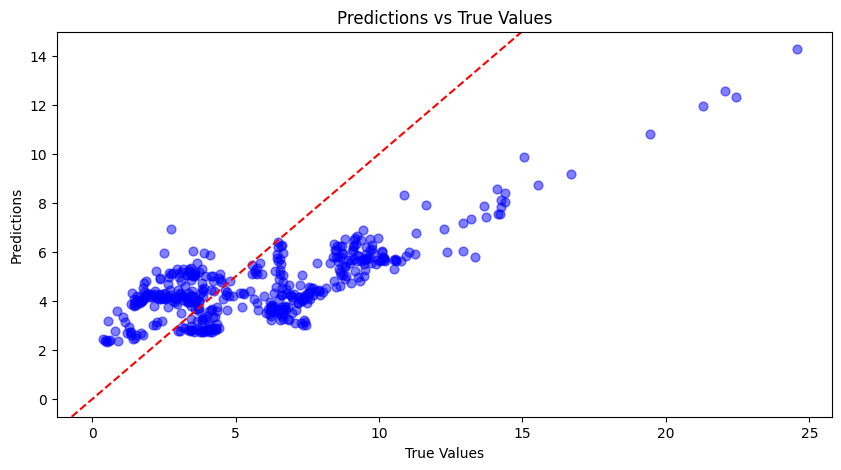

In [105]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions["mean"], c="b", s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

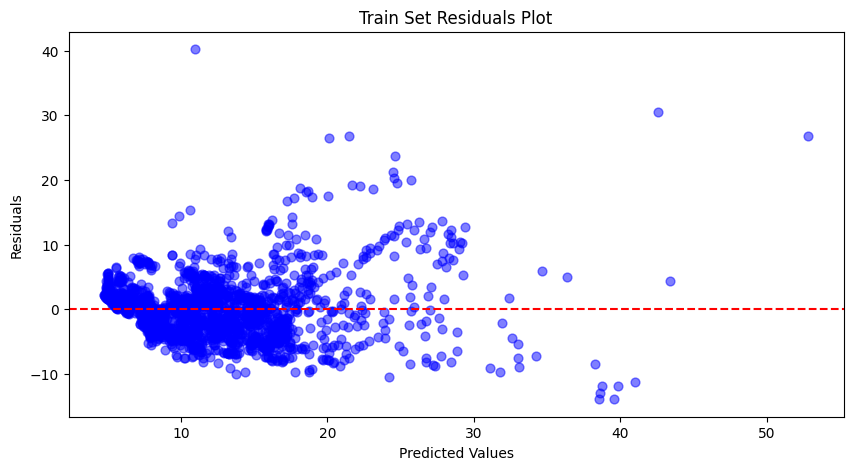

In [106]:
# plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(model.fittedvalues, train_res, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Train Set Residuals Plot")
plt.show()

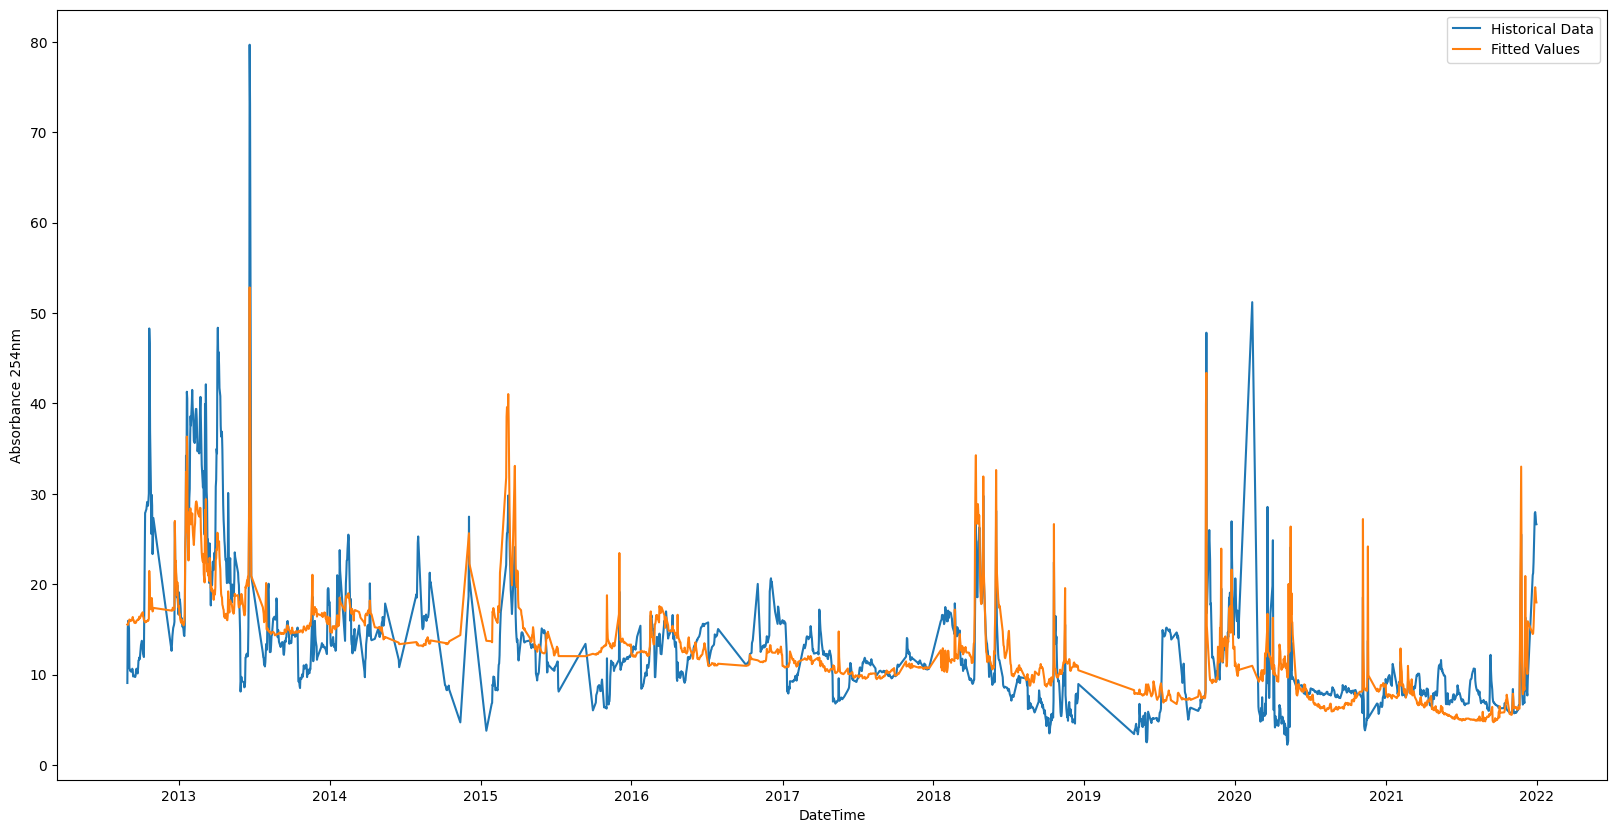

In [107]:
# plot the fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train["DateTime"],
    y=model.fittedvalues.values,
    label="Fitted Values",
)

plt.show()

In [108]:
residuals = (
    y_test_fit["Absorbance 254nm"].values - predictions["mean"].values
)

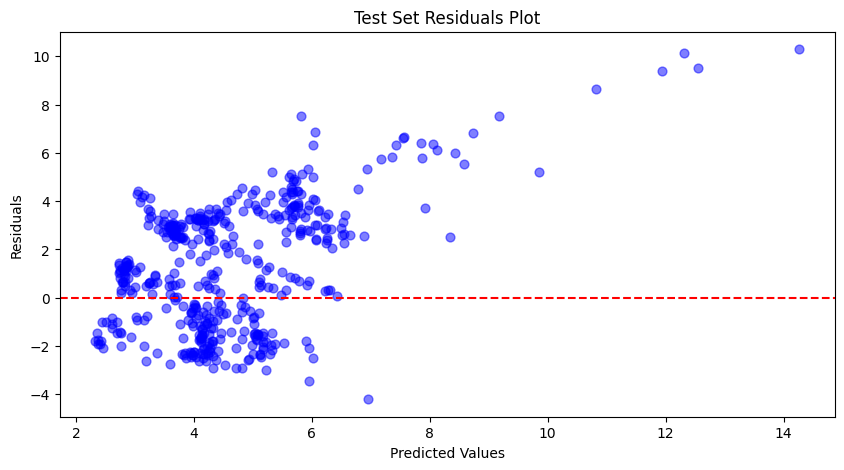

In [109]:
# plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(predictions["mean"], residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

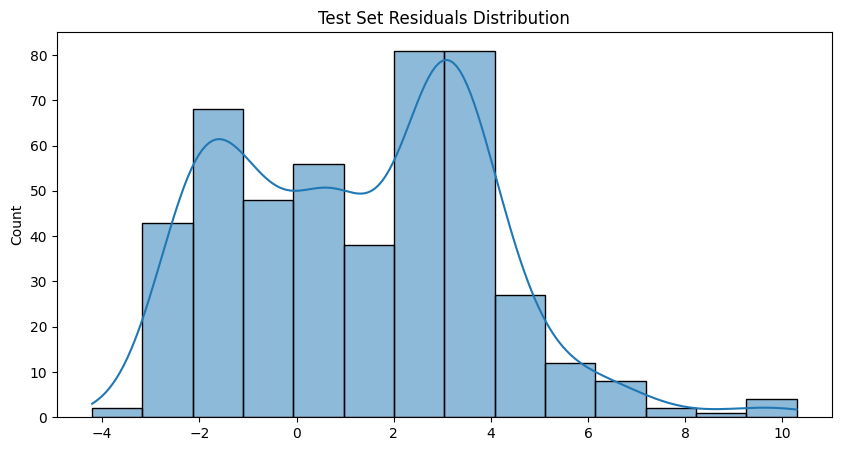

In [110]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

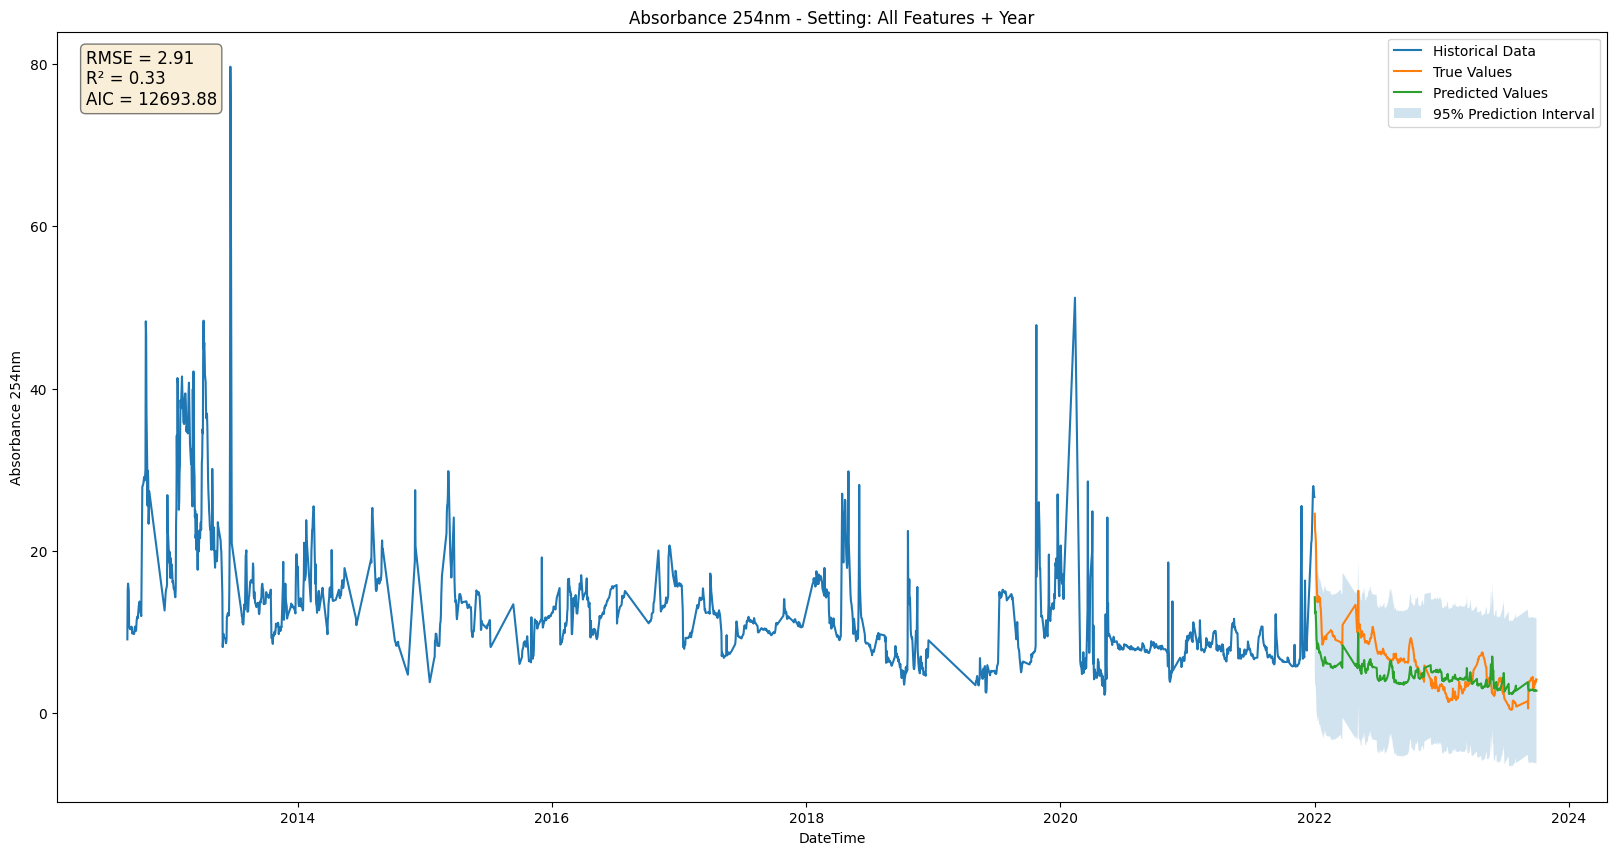

In [111]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
# sns.lineplot(x=y_train['DateTime'], y=model.fittedvalues.values, label='Fitted Values')
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=predictions["mean"].values,
    label="Predicted Values",
)
plt.fill_between(
    y_test["DateTime"],
    predictions["obs_ci_lower"],
    predictions["obs_ci_upper"],
    alpha=0.2,
    label="95% Prediction Interval",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
        f"AIC = {model.aic:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    75,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Setting: {setting}")

plt.legend()
plt.show()

#### Store Results

In [112]:
lr_pred = predictions["mean"]
lr_lower_bound = predictions["obs_ci_lower"]
lr_upper_bound = predictions["obs_ci_upper"]
lr_rmse = rmse
lr_r2 = r2

## All Features + Year w/ log(y)

In [113]:
setting = "Ammonium + Flow River + Redox Potential + Turbidity + Year"

### Split Data

In [114]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Month", "Season"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

# scale y to ln(y)
y["Absorbance 254nm"] = np.log(y["Absorbance 254nm"])

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87631/122478304.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Absorbance 254nm'] = np.log(y['Absorbance 254nm'])


In [115]:
# split data such that 2022 and 2023 are test data
X_train = X[X["DateTime"] < "2022-01-01"]
X_test = X[X["DateTime"] >= "2022-01-01"]

y_train = y[y["DateTime"] < "2022-01-01"]
y_test = y[y["DateTime"] >= "2022-01-01"]

In [116]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

# scale the data
scaler = StandardScaler()

X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

X_train_fit = pd.DataFrame(
    X_train_fit, columns=X_train.columns.difference(["DateTime"])
)
X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_test.columns.difference(["DateTime"])
)

### Train Model

In [117]:
model = sm.OLS(y_train_fit.values, sm.add_constant(X_train_fit)).fit()

In [118]:
results = model.summary2()

### Results

In [119]:
print(results)

                     Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.547    
Dependent Variable:    y                  AIC:                  1200.2536
Date:                  2024-03-18 18:07   BIC:                  1240.0019
No. Observations:      2161               Log-Likelihood:       -593.13  
Df Model:              6                  F-statistic:          436.2    
Df Residuals:          2154               Prob (F-statistic):   0.00     
R-squared:             0.549              Scale:                0.10170  
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                     2.4011   0.0069 350.0076 0.0000  2.3877  2.4146
Air Temperature           0.0214   0.0171   1.2518 0.2108 -0.0121  0.0549
Daily Cumulated Rainfall  0.0005   0.0069   0.0726 0.9422 -

### Predictions

In [120]:
# predict the model
predictions = model.get_prediction(
    sm.add_constant(X_test_fit)
).summary_frame(alpha=0.05)

In [121]:
predictions

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0    2.394700  0.030809       2.334282       2.455118      1.766386   
1    2.289045  0.028071       2.233995       2.344095      1.661224   
2    2.303265  0.026626       2.251049       2.355481      1.675687   
3    2.276653  0.024689       2.228237       2.325069      1.649379   
4    2.215597  0.022373       2.171723       2.259471      1.588657   
..        ...       ...            ...            ...           ...   
466  1.677675  0.019871       1.638706       1.716644      1.051059   
467  1.677684  0.019360       1.639718       1.715650      1.051130   
468  1.671963  0.019444       1.633831       1.710095      1.045399   
469  1.670677  0.019789       1.631870       1.709485      1.044072   
470  1.671748  0.019579       1.633352       1.710144      1.045168   

     obs_ci_upper  
0        3.023014  
1        2.916865  
2        2.930844  
3        2.903927  
4        2.842537  
..            ...  
466      2.304290  
467      2.304238  
468      2.298527  
469      2.297283  
470      2.298328  

[471 rows x 6 columns]

In [122]:
# rescale the data
y_train["Absorbance 254nm"] = np.exp(y_train["Absorbance 254nm"])
y_test["Absorbance 254nm"] = np.exp(y_test["Absorbance 254nm"])
y_test_fit = np.exp(y_test_fit)

predictions["mean"] = np.exp(predictions["mean"])
predictions["obs_ci_lower"] = np.exp(predictions["obs_ci_lower"])
predictions["obs_ci_upper"] = np.exp(predictions["obs_ci_upper"])

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87631/1204093844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Absorbance 254nm'] = np.exp(y_train['Absorbance 254nm'])
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87631/1204093844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Absorbance 254nm'] = np.exp(y_test['Absorbance 254nm'])


### Plots

In [123]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions["mean"]))
r2 = r2_score(y_test_fit, predictions["mean"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 3.093586558777291
R2: 0.2441609826522303


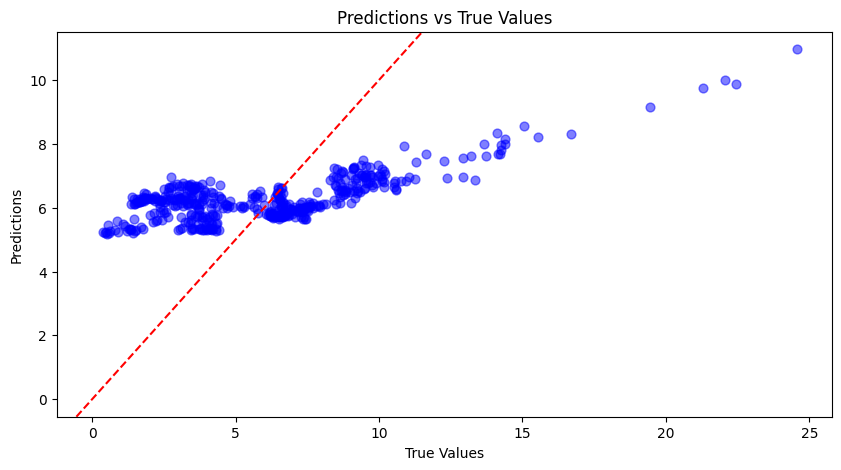

In [124]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions["mean"], c="b", s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

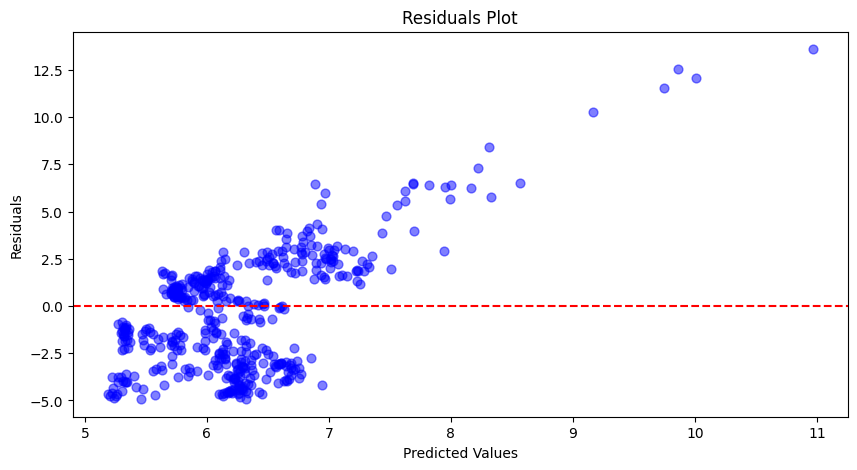

In [125]:
# plot the residuals
residuals = (
    y_test_fit["Absorbance 254nm"].values - predictions["mean"].values
)
plt.figure(figsize=(10, 5))
plt.scatter(predictions["mean"], residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

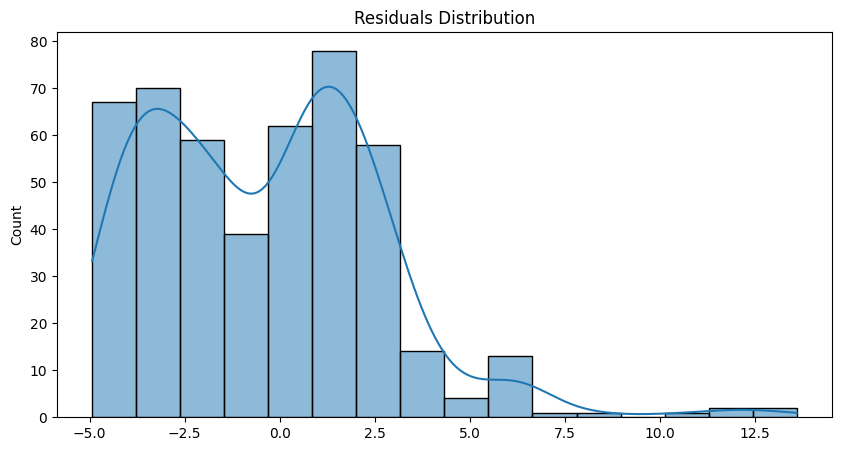

In [126]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

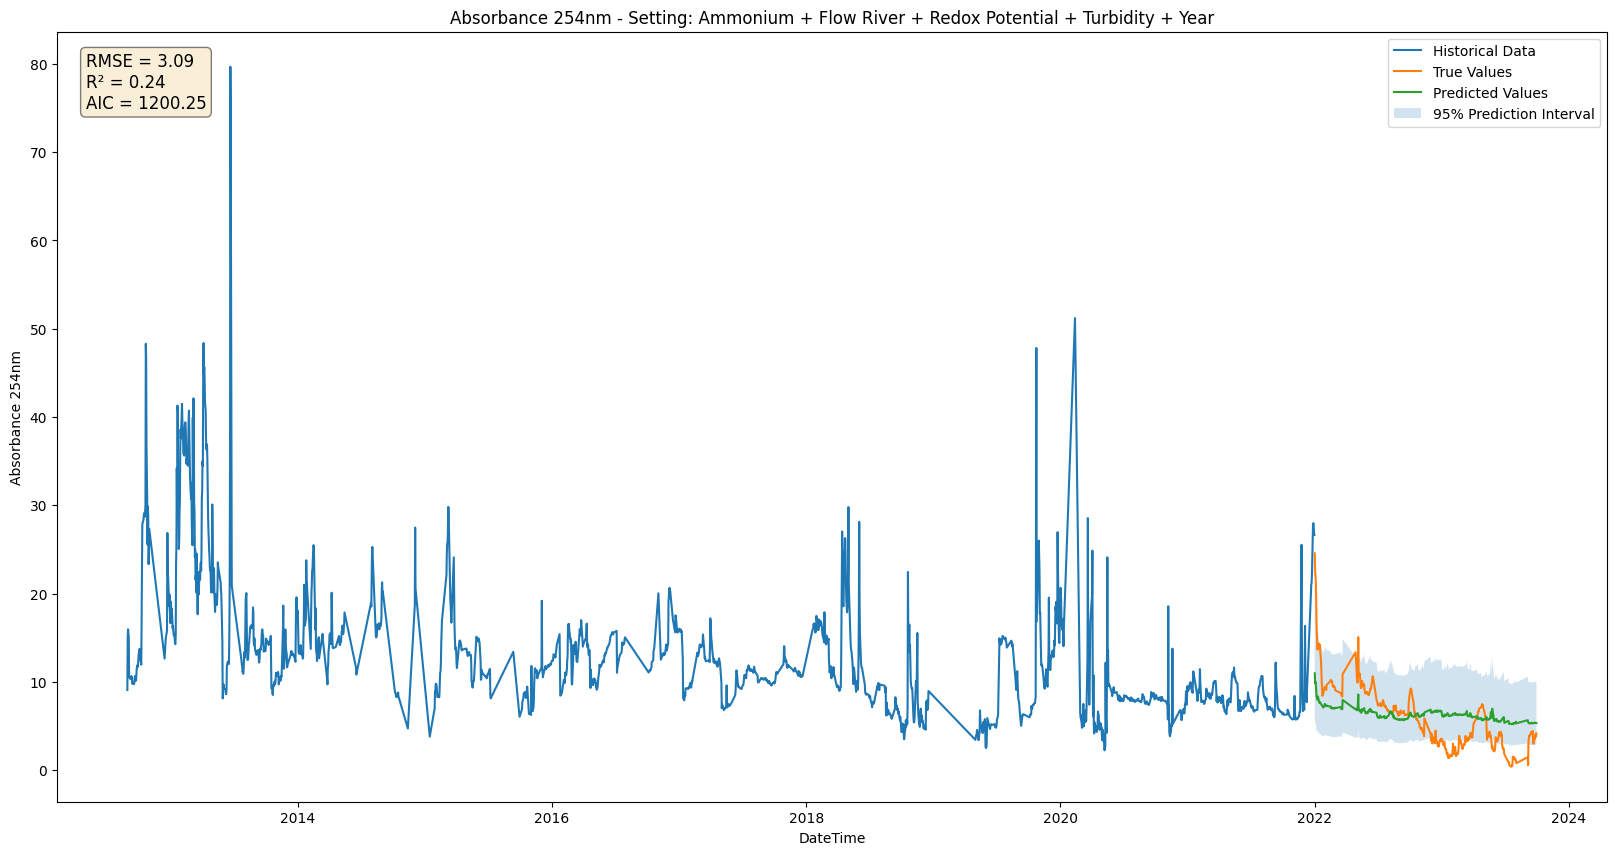

In [127]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=predictions["mean"].values,
    label="Predicted Values",
)
plt.fill_between(
    y_test["DateTime"],
    predictions["obs_ci_lower"],
    predictions["obs_ci_upper"],
    alpha=0.2,
    label="95% Prediction Interval",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
        f"AIC = {model.aic:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    75,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Setting: {setting}")

plt.legend()
plt.show()

### Store Results

In [128]:
log_pred = predictions["mean"]
log_lower_bound = predictions["obs_ci_lower"]
log_upper_bound = predictions["obs_ci_upper"]
log_rmse = rmse
log_r2 = r2

## All Features + Year + Polynomial Features

### Split Data

In [129]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Month", "Season"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [130]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    X[X.columns.difference(["DateTime"] + further_features)]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        X.columns.difference(["DateTime"] + further_features)
    ),
)

X_poly["DateTime"] = X["DateTime"].values

X_poly[further_features] = X[further_features].values

In [131]:
# split data such that 2022 and 2023 are test data
X_train = X_poly[X_poly["DateTime"] < "2022-01-01"]
X_test = X_poly[X_poly["DateTime"] >= "2022-01-01"]

y_train = y[y["DateTime"] < "2022-01-01"]
y_test = y[y["DateTime"] >= "2022-01-01"]

In [132]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

In [133]:
scaler = StandardScaler()

X_train_fit = scaler.fit_transform(
    X_train_fit[X_train_fit.columns.difference(further_features)]
)
X_test_fit = scaler.transform(
    X_test_fit[X_test_fit.columns.difference(further_features)]
)

X_train_fit = pd.DataFrame(
    X_train_fit,
    columns=X_train.columns.difference(["DateTime"] + further_features),
)
X_test_fit = pd.DataFrame(
    X_test_fit,
    columns=X_test.columns.difference(["DateTime"] + further_features),
)

X_train_fit[further_features] = X_train[further_features].values
X_test_fit[further_features] = X_test[further_features].values

### Train Model

In [134]:
model = sm.OLS(y_train_fit.values, sm.add_constant(X_train_fit)).fit()

In [135]:
results = model.summary2()

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


### Results

In [136]:
print(results)

                                 Results: Ordinary least squares
Model:                        OLS                        Adj. R-squared:               0.603     
Dependent Variable:           y                          AIC:                          12588.3330
Date:                         2024-03-18 18:07           BIC:                          12713.2562
No. Observations:             2161                       Log-Likelihood:               -6272.2   
Df Model:                     21                         F-statistic:                  157.5     
Df Residuals:                 2139                       Prob (F-statistic):           0.00      
R-squared:                    0.607                      Scale:                        19.633    
-------------------------------------------------------------------------------------------------
                                             Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-----------------------------------------------------

### Predictions

In [137]:
# predict the model
predictions = model.get_prediction(
    sm.add_constant(X_test_fit)
).summary_frame(alpha=0.05)

In [138]:
train_res = model.resid

### Plots

In [139]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions["mean"]))
r2 = r2_score(y_test_fit, predictions["mean"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 2.7247439366613966
R2: 0.41365104916716355


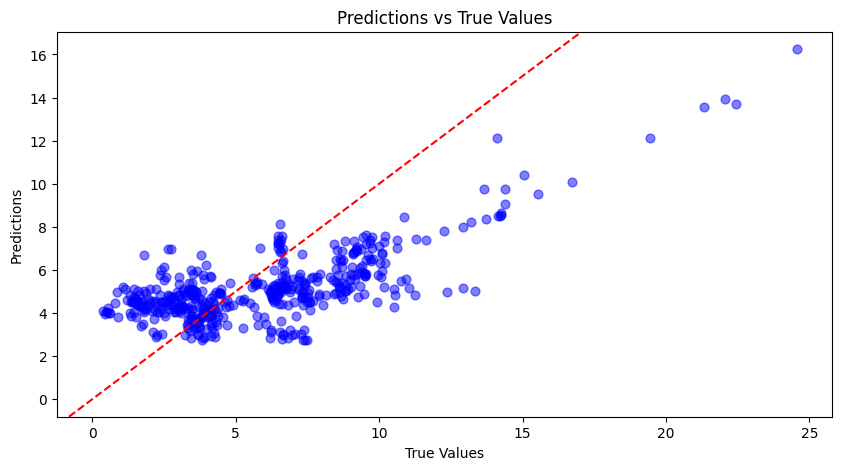

In [140]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions["mean"], c="b", s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

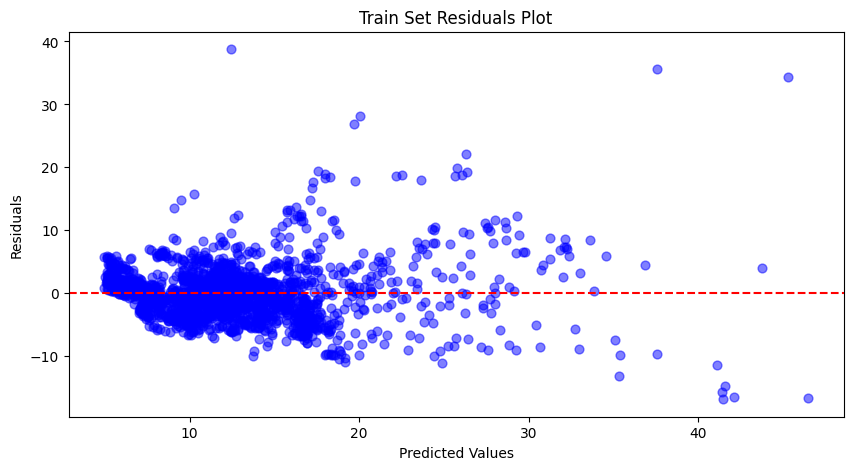

In [141]:
# plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(model.fittedvalues, train_res, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Train Set Residuals Plot")
plt.show()

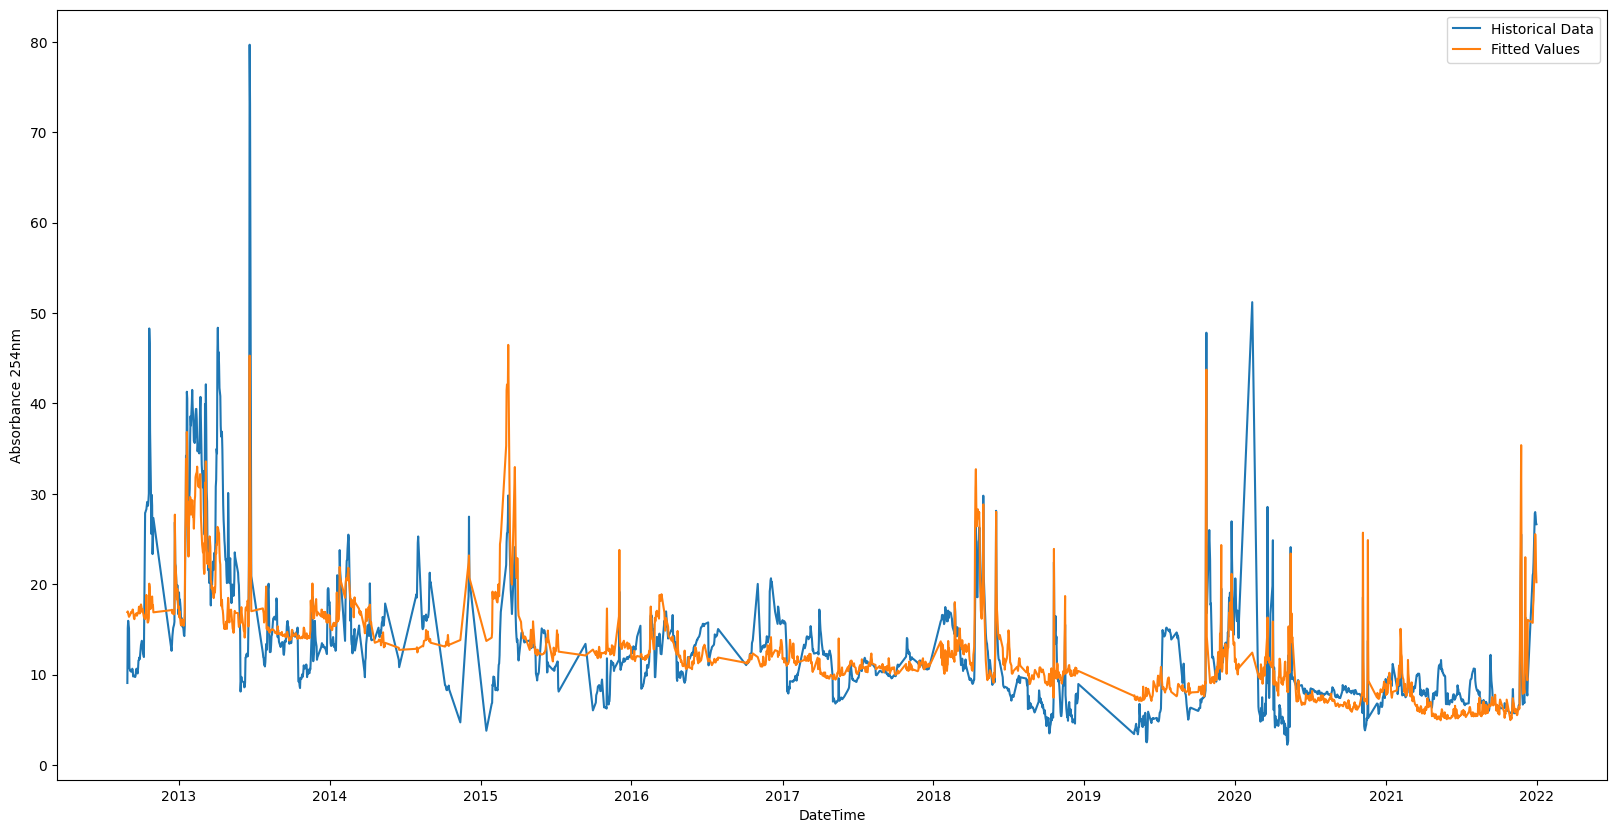

In [142]:
# plot the fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train["DateTime"],
    y=model.fittedvalues.values,
    label="Fitted Values",
)

plt.show()

In [143]:
residuals = (
    y_test_fit["Absorbance 254nm"].values - predictions["mean"].values
)

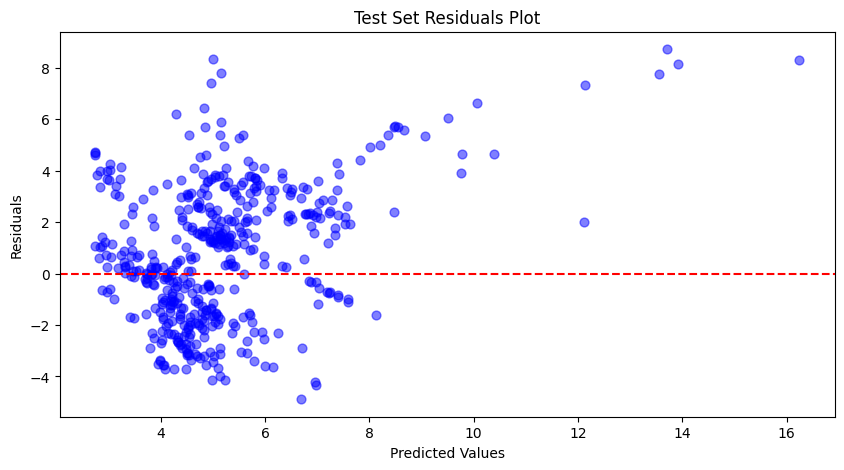

In [144]:
# plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(predictions["mean"], residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

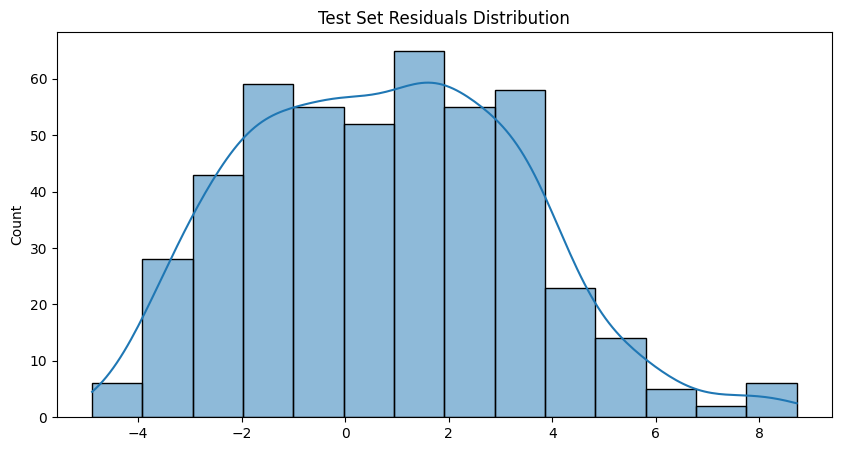

In [145]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

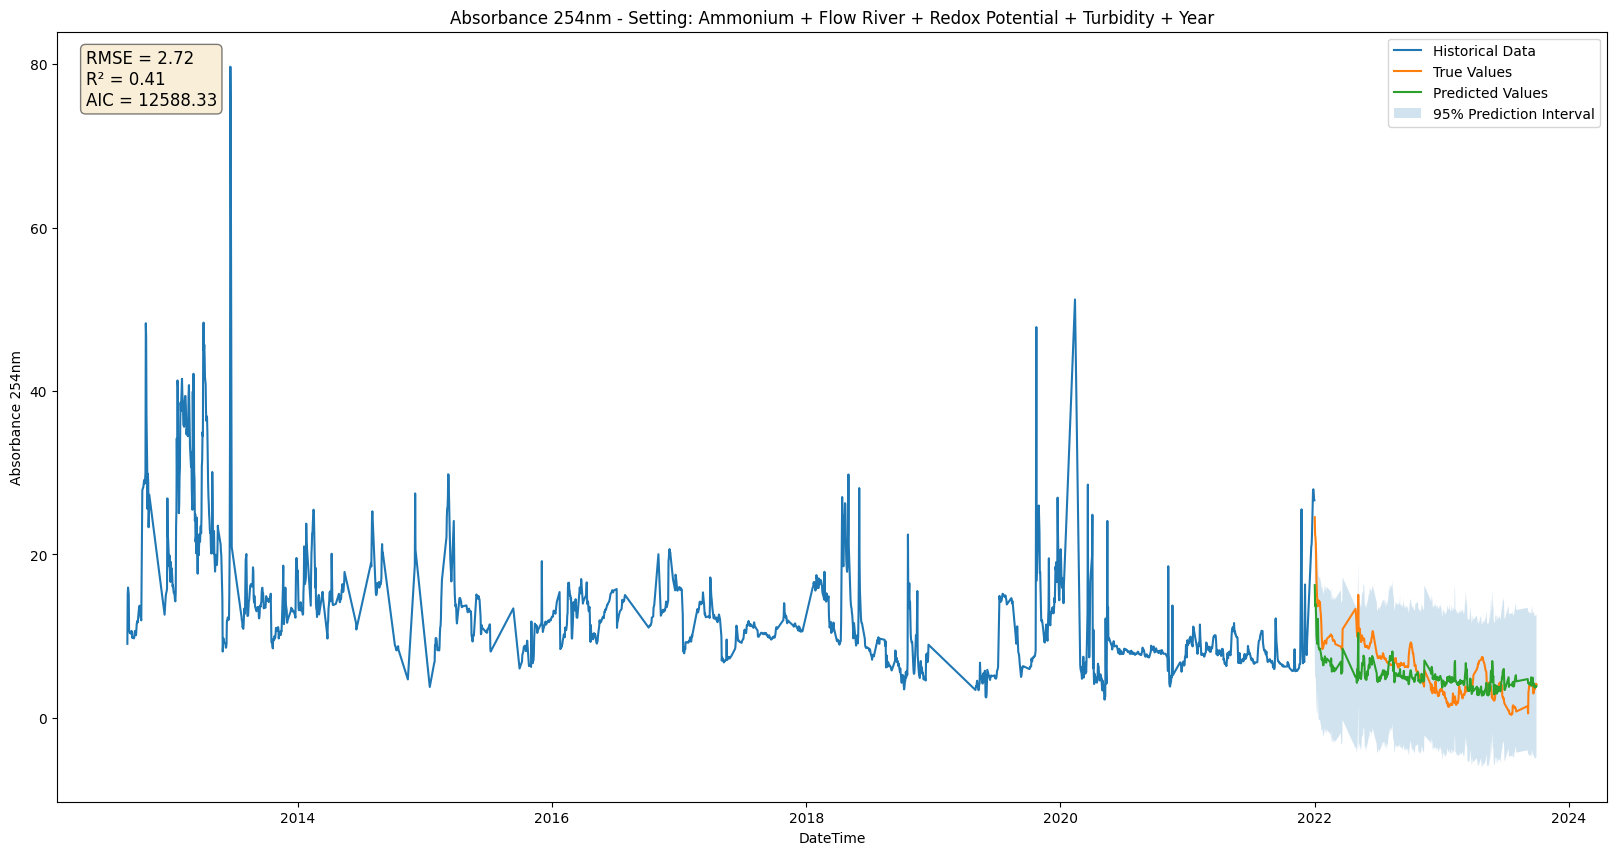

In [146]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
# sns.lineplot(x=y_train['DateTime'], y=model.fittedvalues.values, label='Fitted Values')
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=predictions["mean"].values,
    label="Predicted Values",
)
plt.fill_between(
    y_test["DateTime"],
    predictions["obs_ci_lower"],
    predictions["obs_ci_upper"],
    alpha=0.2,
    label="95% Prediction Interval",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
        f"AIC = {model.aic:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    75,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Setting: {setting}")

plt.legend()
plt.show()

### Store Results

In [147]:
poly_pred = predictions["mean"]
poly_lower_bound = predictions["obs_ci_lower"]
poly_upper_bound = predictions["obs_ci_upper"]
poly_rmse = rmse
poly_r2 = r2

## Final Plot

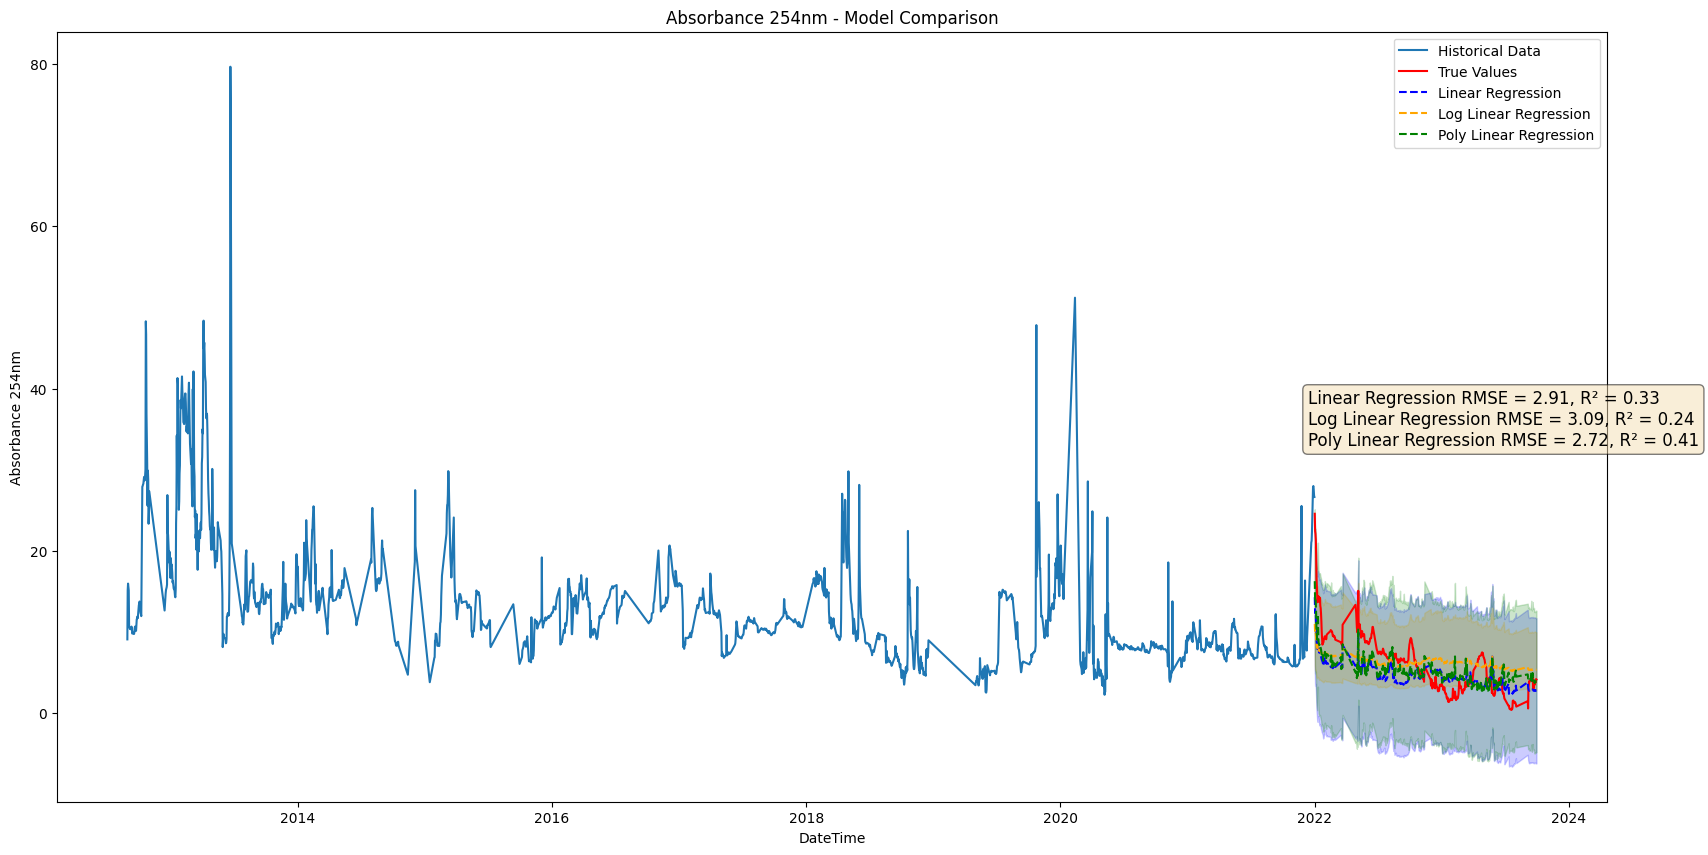

In [148]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
    color="red",
)

# Linear Regression
sns.lineplot(
    x=y_test["DateTime"],
    y=lr_pred.values,
    label="Linear Regression",
    linestyle="--",
    color="blue",
)
plt.fill_between(
    y_test["DateTime"],
    lr_lower_bound,
    lr_upper_bound,
    alpha=0.2,
    color="blue",
)

# Linear Regression Log
sns.lineplot(
    x=y_test["DateTime"],
    y=log_pred.values,
    label="Log Linear Regression",
    linestyle="--",
    color="orange",
)
plt.fill_between(
    y_test["DateTime"],
    log_lower_bound,
    log_upper_bound,
    alpha=0.2,
    color="orange",
)

# Linear Regression Poly
sns.lineplot(
    x=y_test["DateTime"],
    y=poly_pred.values,
    label="Poly Linear Regression",
    linestyle="--",
    color="green",
)
plt.fill_between(
    y_test["DateTime"],
    poly_lower_bound,
    poly_upper_bound,
    alpha=0.2,
    color="green",
)

plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"Linear Regression RMSE = {lr_rmse:.2f}, R\u00b2 = {lr_r2:.2f}",
        f"Log Linear Regression RMSE = {log_rmse:.2f}, R\u00b2 = {log_r2:.2f}",
        f"Poly Linear Regression RMSE = {poly_rmse:.2f}, R\u00b2 = {poly_r2:.2f}",
    )
)

plt.text(
    y_test["DateTime"].iloc[0] - pd.Timedelta(days=20),
    33,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Model Comparison")

plt.legend()
plt.show()

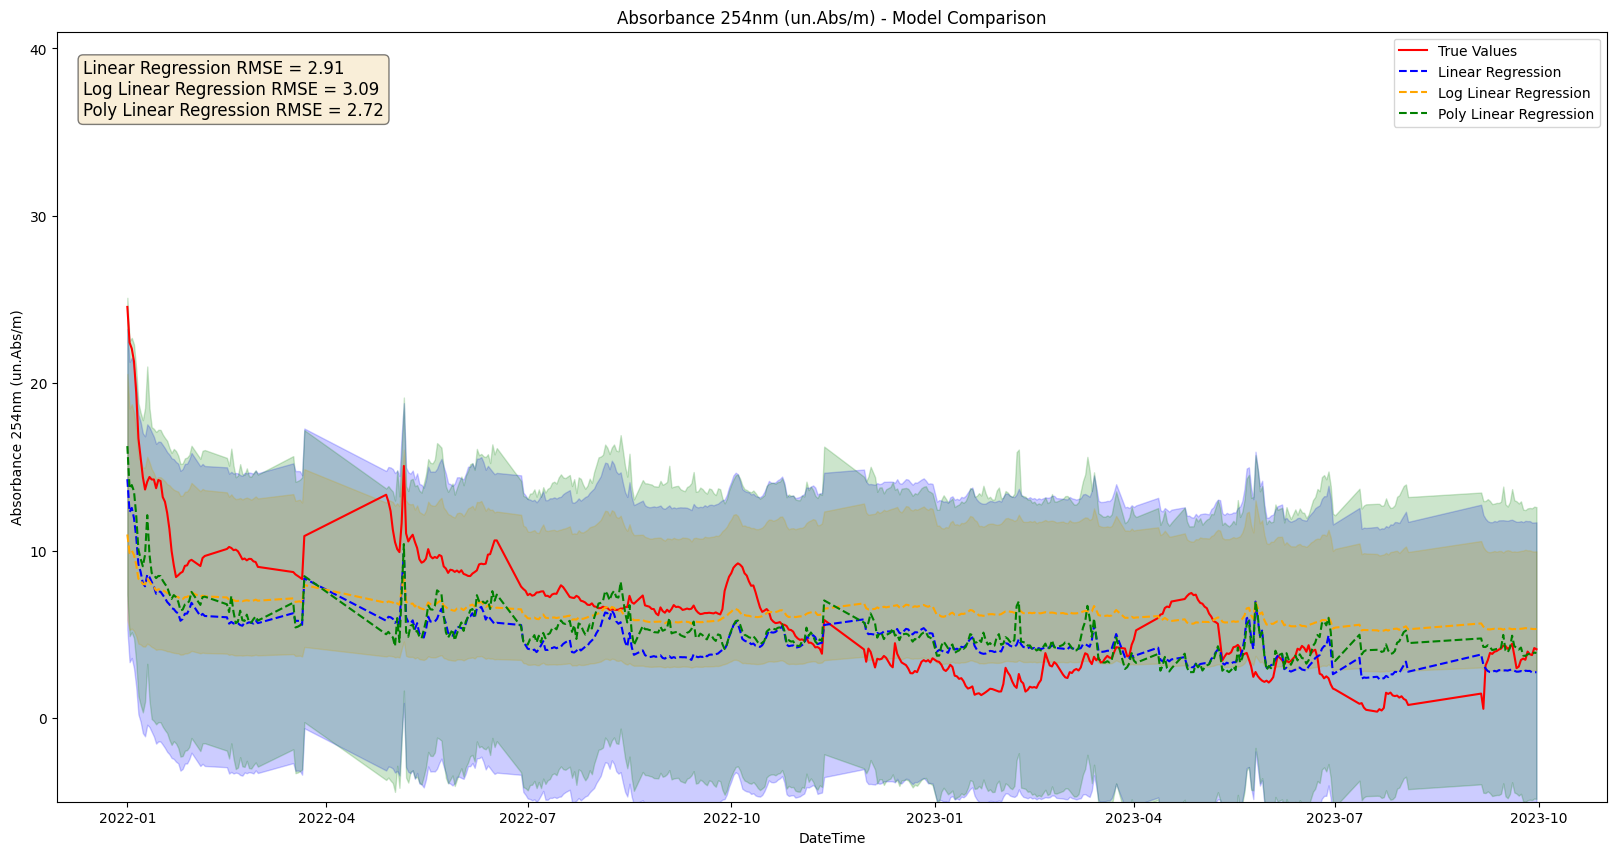

In [149]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
# sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
    color="red",
)

# Linear Regression
sns.lineplot(
    x=y_test["DateTime"],
    y=lr_pred.values,
    label="Linear Regression",
    linestyle="--",
    color="blue",
)
plt.fill_between(
    y_test["DateTime"],
    lr_lower_bound,
    lr_upper_bound,
    alpha=0.2,
    color="blue",
)

# Linear Regression Log
sns.lineplot(
    x=y_test["DateTime"],
    y=log_pred.values,
    label="Log Linear Regression",
    linestyle="--",
    color="orange",
)
plt.fill_between(
    y_test["DateTime"],
    log_lower_bound,
    log_upper_bound,
    alpha=0.2,
    color="orange",
)

# Linear Regression Poly
sns.lineplot(
    x=y_test["DateTime"],
    y=poly_pred.values,
    label="Poly Linear Regression",
    linestyle="--",
    color="green",
)
plt.fill_between(
    y_test["DateTime"],
    poly_lower_bound,
    poly_upper_bound,
    alpha=0.2,
    color="green",
)

# change the y range to see the differences
plt.ylim(-5, 41)

plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm (un.Abs/m)")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"Linear Regression RMSE = {lr_rmse:.2f}",
        f"Log Linear Regression RMSE = {log_rmse:.2f}",
        f"Poly Linear Regression RMSE = {poly_rmse:.2f}",
    )
)

plt.text(
    y_test["DateTime"].iloc[0] - pd.Timedelta(days=20),
    36,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm (un.Abs/m) - Model Comparison")

plt.legend()
plt.show()

# Random Forest

In [44]:
setting = "All Features + Year"

### Split Data

In [45]:
X = full_df[
    full_df.columns.difference(
        ["Absorbance 254nm", "Season", "Month", "Timestamp"]
    )
]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [46]:
# split data such that 2022 and 2023 are test data
X_train = X[X["DateTime"] < "2022-01-01"]
X_test = X[X["DateTime"] >= "2022-01-01"]

y_train = y[y["DateTime"] < "2022-01-01"]
y_test = y[y["DateTime"] >= "2022-01-01"]

In [47]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

### Train Model

#### Perform K-Fold Cross-Validation

K = 10 since the training set is composed of 10 years (almost).

In [48]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [49]:
rf_model = RandomForestQuantileRegressor(
    n_estimators=20, max_features="log2", max_depth=7, random_state=42
)

cv = KFold(n_splits=10)

rf_ensemble = cross_validate(
    rf_model,
    X_train_fit,
    y_train_fit.values.flatten(),
    cv=cv,
    scoring="neg_mean_squared_error",
    return_estimator=True,
    return_train_score=True,
)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted wit

### Results

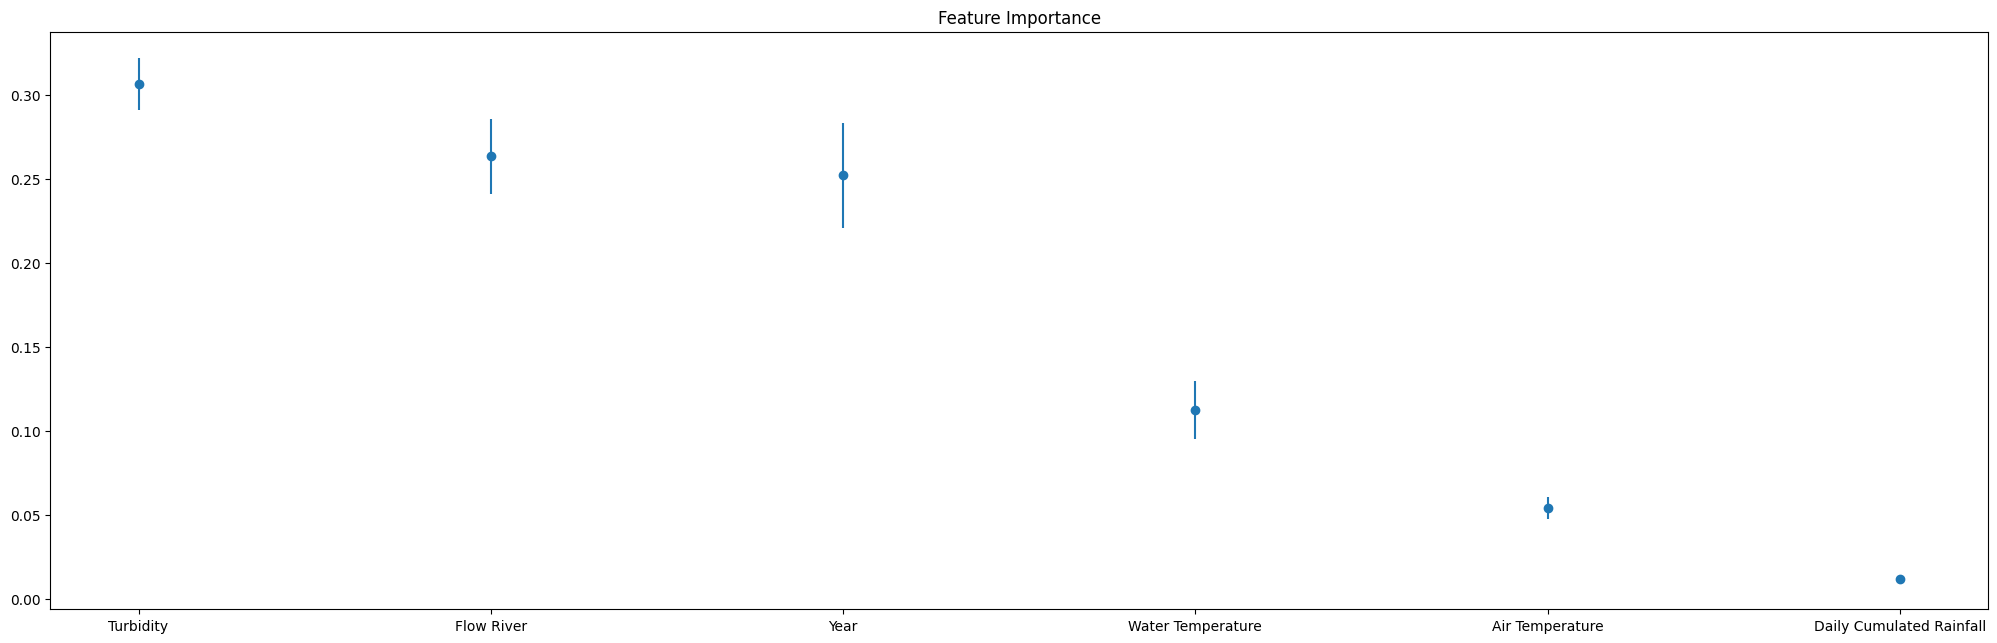

In [50]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train_fit.columns
feature_importance["importance_mean"] = np.mean(
    [
        estimator.feature_importances_
        for estimator in rf_ensemble["estimator"]
    ],
    axis=0,
)
feature_importance["importance_std"] = np.std(
    [
        estimator.feature_importances_
        for estimator in rf_ensemble["estimator"]
    ],
    axis=0,
)

feature_importance = feature_importance.sort_values(
    by="importance_mean", ascending=False
)

# plot the importance of each feature with the std
plt.figure(figsize=(25, 7.5))
plt.errorbar(
    x=feature_importance["feature"],
    y=feature_importance["importance_mean"],
    yerr=feature_importance["importance_std"],
    fmt="o",
)
plt.title("Feature Importance")
plt.show()

### Predictions

In [51]:
# get predictions
mean_predictions = np.array(
    [
        estimator.predict(X_test_fit, quantiles=0.5)
        for estimator in rf_ensemble["estimator"]
    ]
)
lower_bound_predictions = np.array(
    [
        estimator.predict(X_test_fit, quantiles=0.05)
        for estimator in rf_ensemble["estimator"]
    ]
)
upper_bound_predictions = np.array(
    [
        estimator.predict(X_test_fit, quantiles=0.95)
        for estimator in rf_ensemble["estimator"]
    ]
)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted wit

In [52]:
mean_predictions = np.mean(mean_predictions, axis=0)
lower_bound_predictions = np.mean(lower_bound_predictions, axis=0)
upper_bound_predictions = np.mean(upper_bound_predictions, axis=0)

In [53]:
rmse = np.sqrt(mean_squared_error(y_test_fit, mean_predictions))
r2 = r2_score(y_test_fit, mean_predictions)

print(f"RMSE: {rmse:.2f}")
print(f"R\u00b2: {r2:.2f}")

RMSE: 4.27
R²: -0.44


### Plots

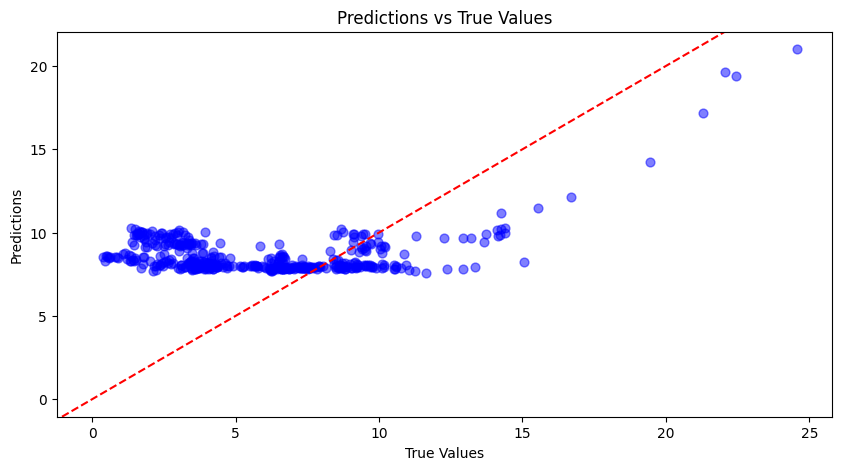

In [54]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit.values, mean_predictions, c="b", s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

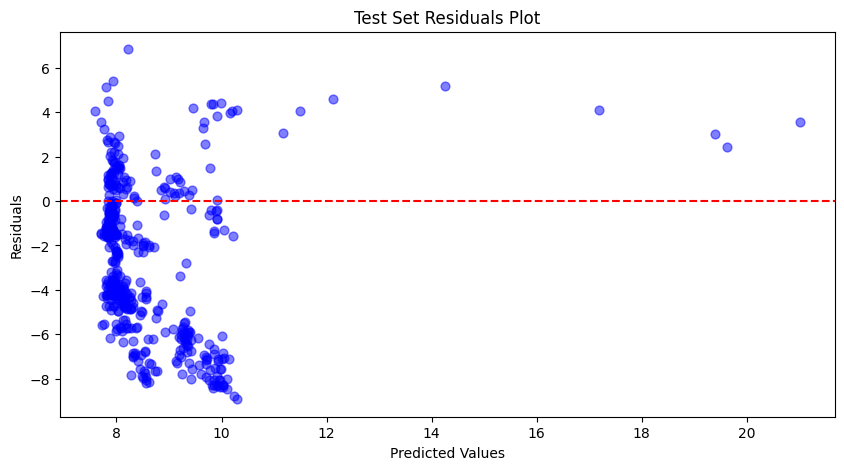

In [55]:
# plot the residuals
residuals = y_test_fit["Absorbance 254nm"] - mean_predictions
plt.figure(figsize=(10, 5))
plt.scatter(mean_predictions, residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

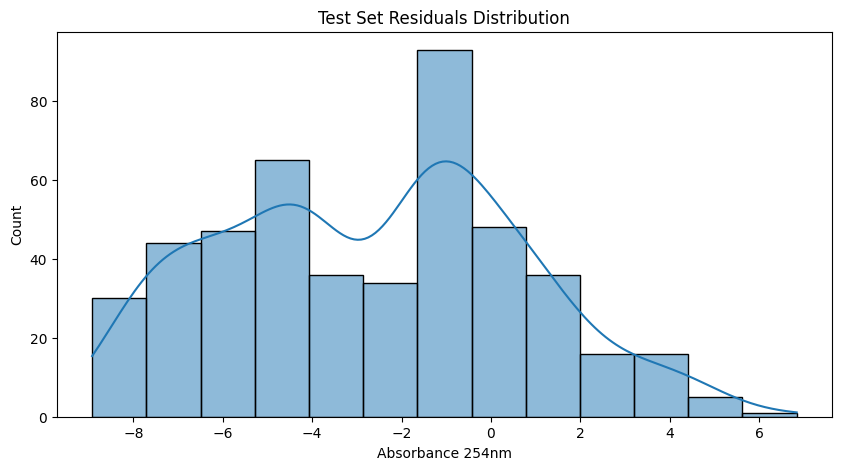

In [56]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

In [57]:
# get training residuals
train_predictions = np.array(
    [
        estimator.predict(X_train_fit, quantiles=0.5)
        for estimator in rf_ensemble["estimator"]
    ]
)
train_predictions = np.mean(train_predictions, axis=0)

train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted wit

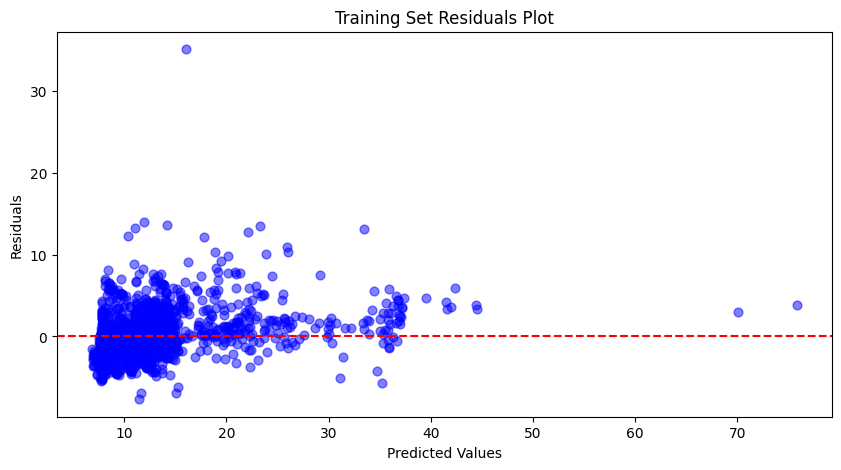

In [58]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

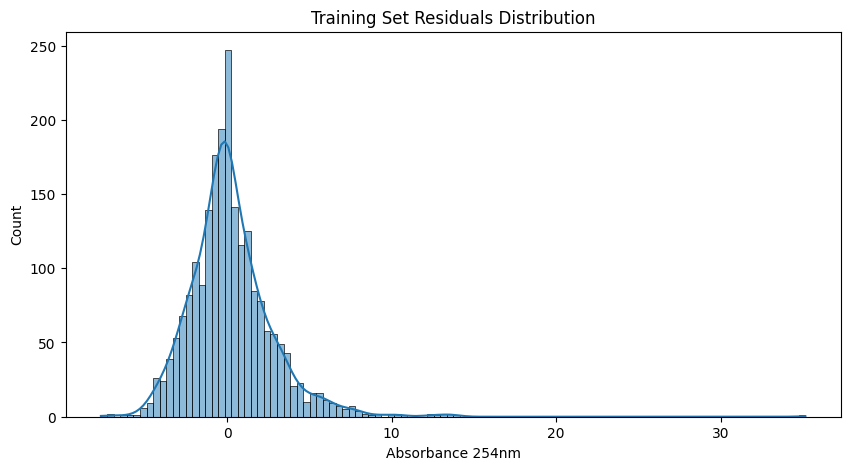

In [59]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

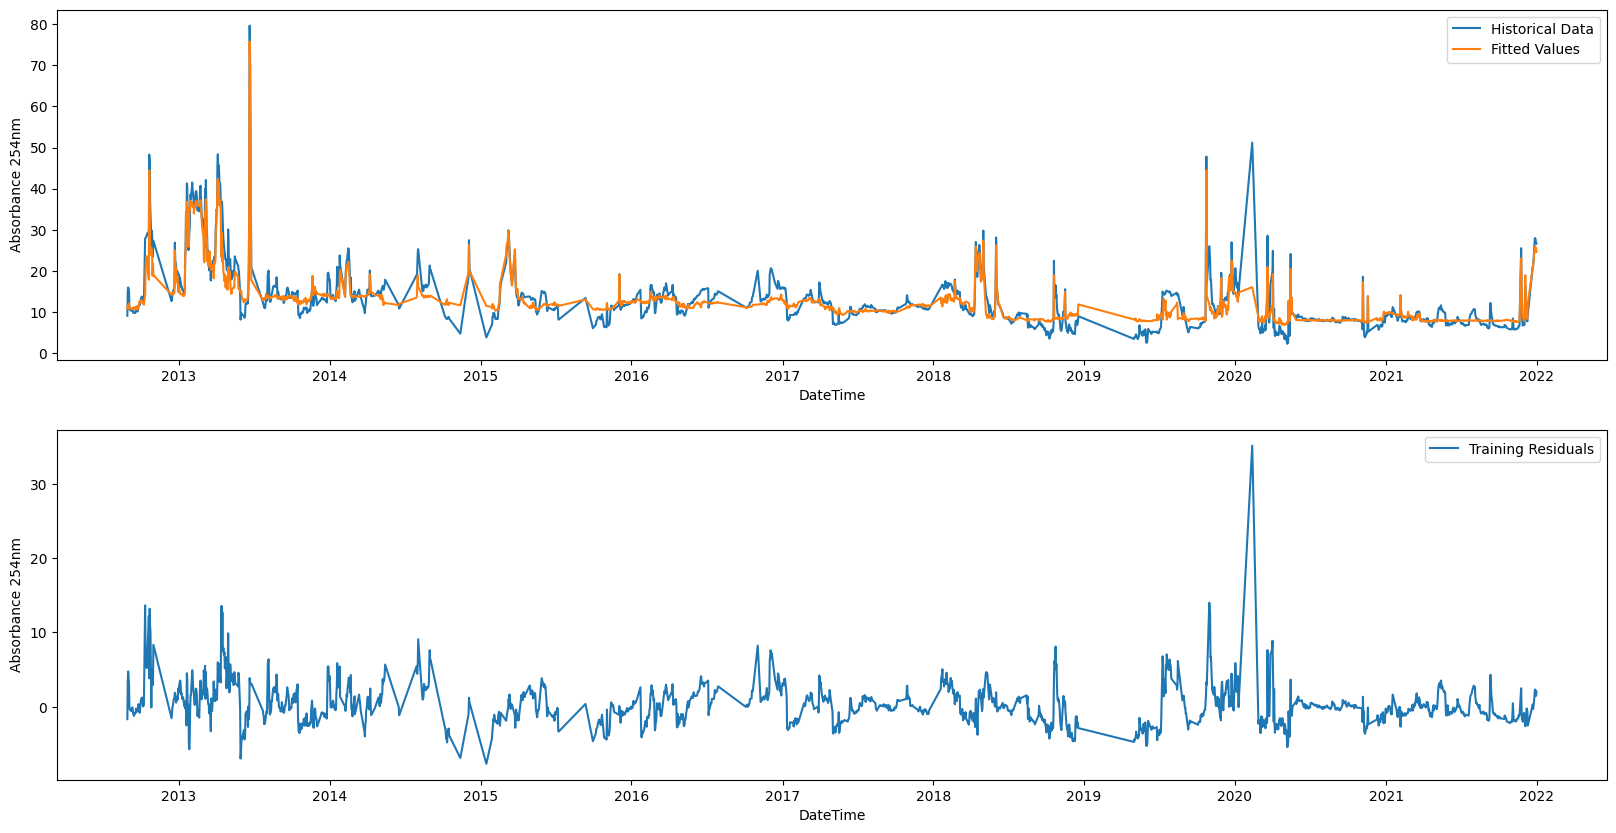

In [60]:
# plot the time series of the residuals and of the train set
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
    ax=ax[0],
)
sns.lineplot(
    x=y_train["DateTime"],
    y=train_predictions,
    label="Fitted Values",
    ax=ax[0],
)

sns.lineplot(
    x=y_train["DateTime"],
    y=train_residuals,
    label="Training Residuals",
    ax=ax[1],
)

plt.show()

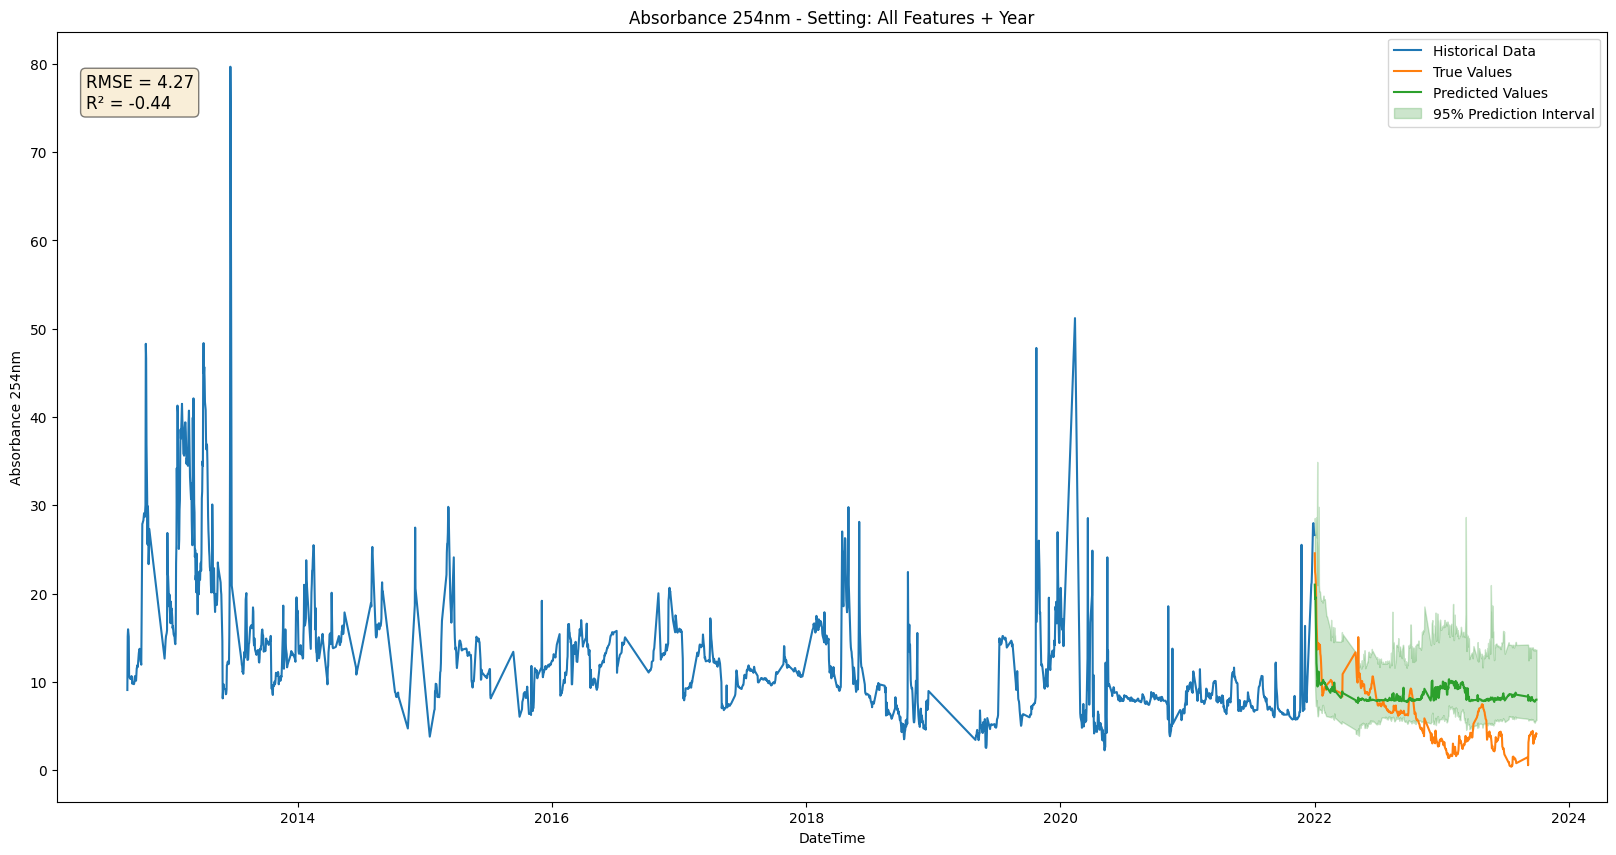

In [61]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test["DateTime"], y=mean_predictions, label="Predicted Values"
)
# plot std of predictions
plt.fill_between(
    y_test["DateTime"],
    lower_bound_predictions,
    y2=upper_bound_predictions,
    alpha=0.2,
    label="95% Prediction Interval",
    color="g",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    75,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Setting: {setting}")

plt.legend()
plt.show()

Comment: prevede un trend crescente, probabilmente dato da qualche feature 

### Store Results

In [62]:
rf_pred = mean_predictions
rf_lower_bound = lower_bound_predictions
rf_upper_bound = upper_bound_predictions
rf_rmse = rmse
rf_r2 = r2

# XGBoost

### Split Data

In [139]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Season", "Month"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [143]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    X[X.columns.difference(["DateTime"] + further_features)]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        X.columns.difference(["DateTime"] + further_features)
    ),
)

X_poly["DateTime"] = X["DateTime"].values

X_poly[further_features] = X[further_features].values

In [144]:
# split data such that 2022 and 2023 are test data
X_train = X_poly[X_poly["DateTime"] < "2021-01-01"]
X_test = X_poly[X_poly["DateTime"] >= "2021-01-01"]

y_train = y[y["DateTime"] < "2021-01-01"]
y_test = y[y["DateTime"] >= "2021-01-01"]

In [145]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

In [146]:
%%script false --no-raise-error
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2021-01-01']
X_test = X[X['DateTime'] >= '2021-01-01']

y_train = y[y['DateTime'] < '2021-01-01']
y_test = y[y['DateTime'] >= '2021-01-01']

In [147]:
%%script false --no-raise-error
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train.copy()
y_test_fit = y_test.copy()

In [148]:
scaler = StandardScaler()
# scale the data and keep the column names
X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

X_train_fit = pd.DataFrame(
    X_train_fit, columns=X_train.columns.difference(["DateTime"])
)
X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_test.columns.difference(["DateTime"])
)

### Train Model

#### Learning and Validation Curves

In [149]:
def learning_curves(
    estimator,
    title,
    X,
    y,
    cv=None,
    train_sizes=np.linspace(0.3, 1.0, 5),
):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator,
        X,
        y,
        train_sizes=train_sizes,
        cv=cv,
        scoring="neg_mean_squared_error",
    )

    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    train_scores_std = np.sqrt(np.std(train_scores, axis=1))
    validation_scores_mean = np.sqrt(
        -np.mean(validation_scores, axis=1)
    )
    validation_scores_std = np.sqrt(np.std(validation_scores, axis=1))

    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(20, 7.5))
    plt.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="r",
        label="Training error",
    )
    plt.plot(
        train_sizes,
        validation_scores_mean,
        "o-",
        color="g",
        label="Validation error",
    )
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.rcParams["font.size"] = 10
    plt.ylabel("RMSE", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    title = title
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    plt.show()

In [150]:
def validation_curves(
    estimator,
    title,
    X,
    y,
    cv=None,
    param_name=None,
    param_range=None,
    fit_params=None,
):
    train_scores, test_scores = validation_curve(
        estimator,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        fit_params=fit_params,
        cv=cv,
        scoring="neg_mean_squared_error",  #'roc_auc'
        n_jobs=4,
    )
    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    train_scores_std = np.sqrt(np.std(train_scores, axis=1))
    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))
    test_scores_std = np.sqrt(np.std(test_scores, axis=1))

    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(20, 7.5))
    plt.title(title, fontsize=20)
    plt.xlabel(param_name, fontsize=14)
    plt.ylabel("Score", fontsize=14)
    lw = 2
    plt.plot(
        param_range,
        train_scores_mean,
        label="Training score",
        color="darkorange",
        lw=lw,
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        param_range,
        test_scores_mean,
        label="Cross-validation score",
        color="navy",
        lw=lw,
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.rcParams["font.size"] = 10
    plt.legend(loc="best")
    # plt.ylim(4, 8)
    plt.grid(visible=True)
    plt.show()

    # print param value with lowest test score
    print(
        f"{param_name} with lowest score:",
        param_range[np.argmin(test_scores_mean)],
    )

In [269]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    booster="gblinear",
    random_state=42,
)

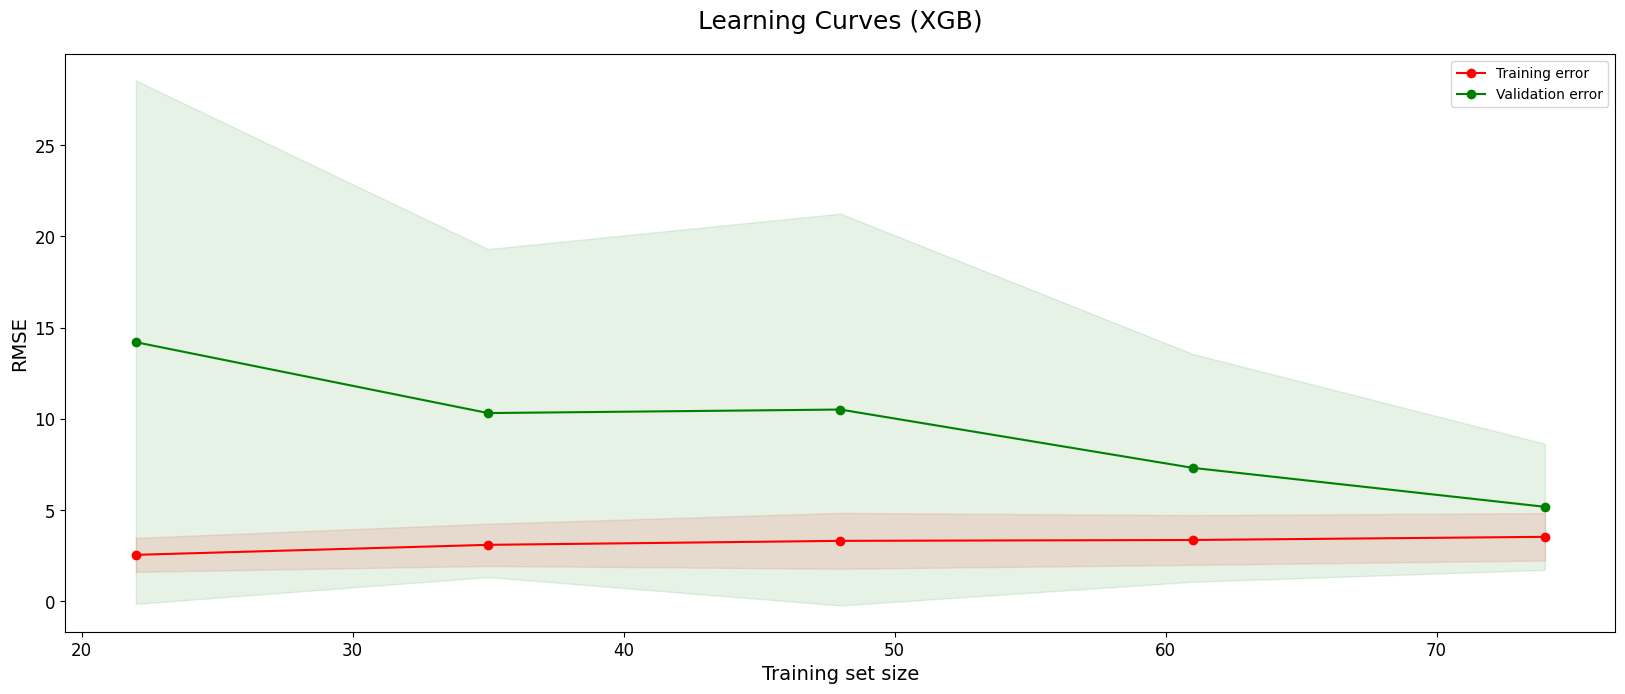

In [270]:
title = "Learning Curves (XGB)"
learning_curves(
    model, title, X_train_fit, y_train_fit["Absorbance 254nm"], cv=5
)

In [271]:
param_name = "n_estimators"
param_range = np.arange(1, 100, 5)

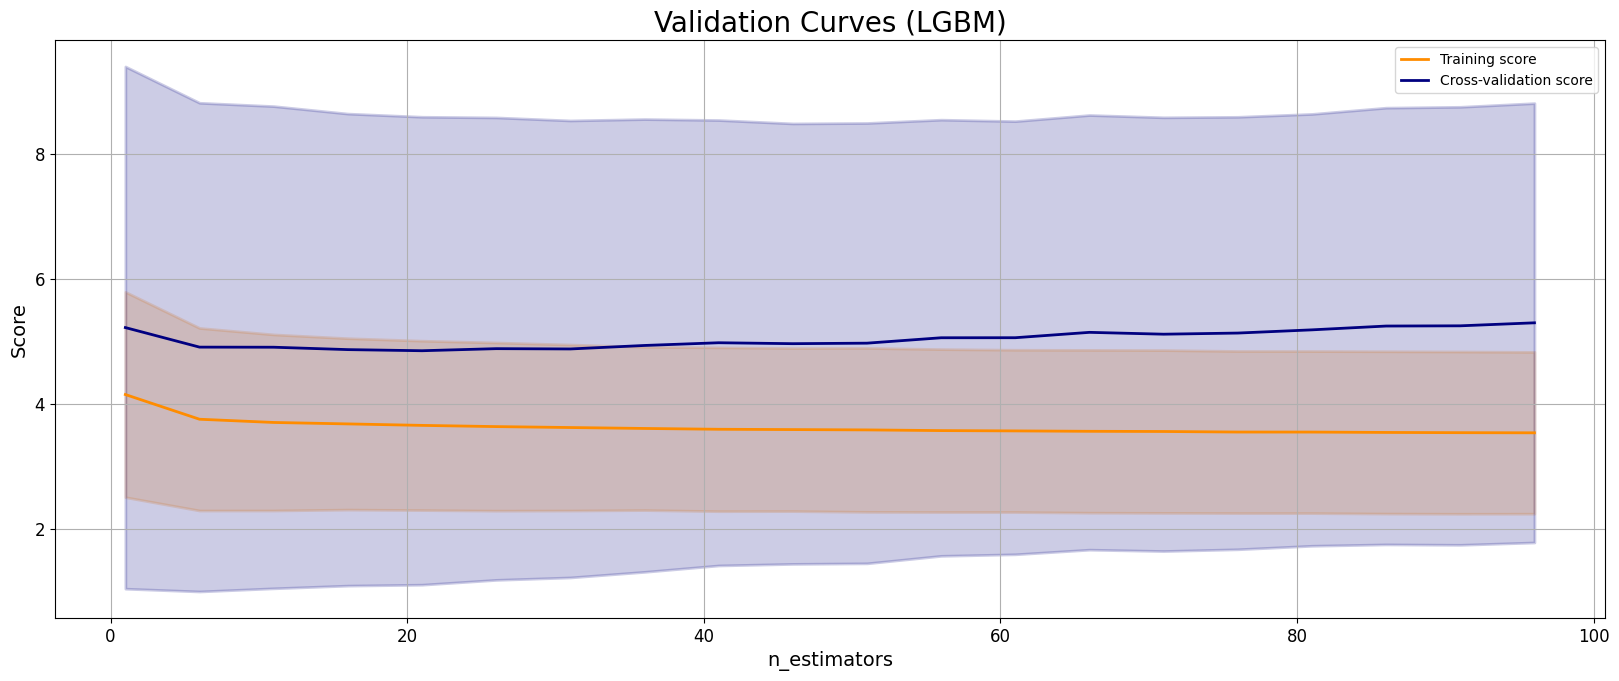

n_estimators with lowest score: 21


In [272]:
title = "Validation Curves (LGBM)"
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [273]:
param_name = "learning_rate"
param_range = np.logspace(-3, -1, 10)

In [274]:
np.logspace(-3, -1, 10)

array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])

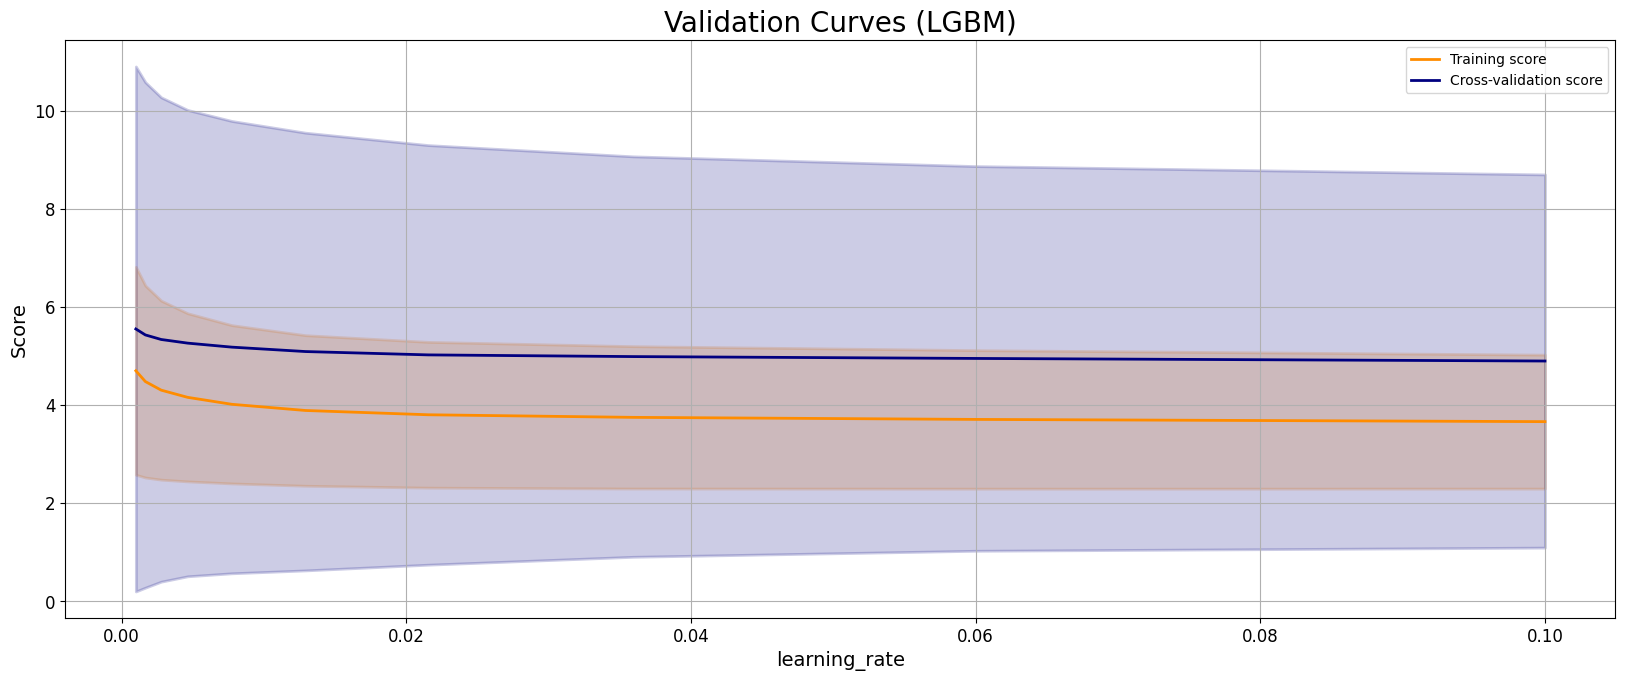

learning_rate with lowest score: 0.1


In [275]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [276]:
param_name = "eta"
param_range = np.logspace(-5, 0, 10)

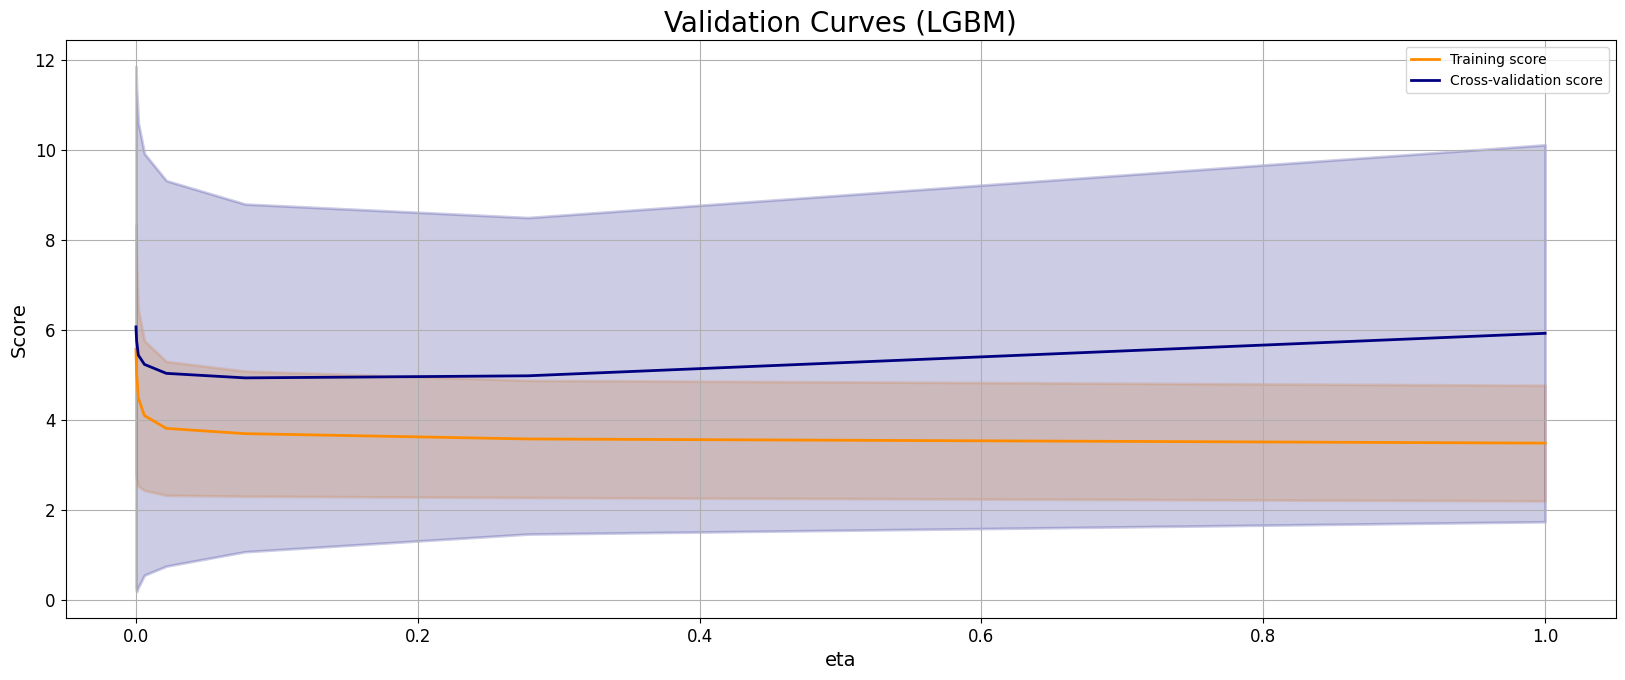

eta with lowest score: 0.07742636826811278


In [277]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [106]:
param_name = "reg_alpha"
param_range = np.logspace(-8, 0, 10)

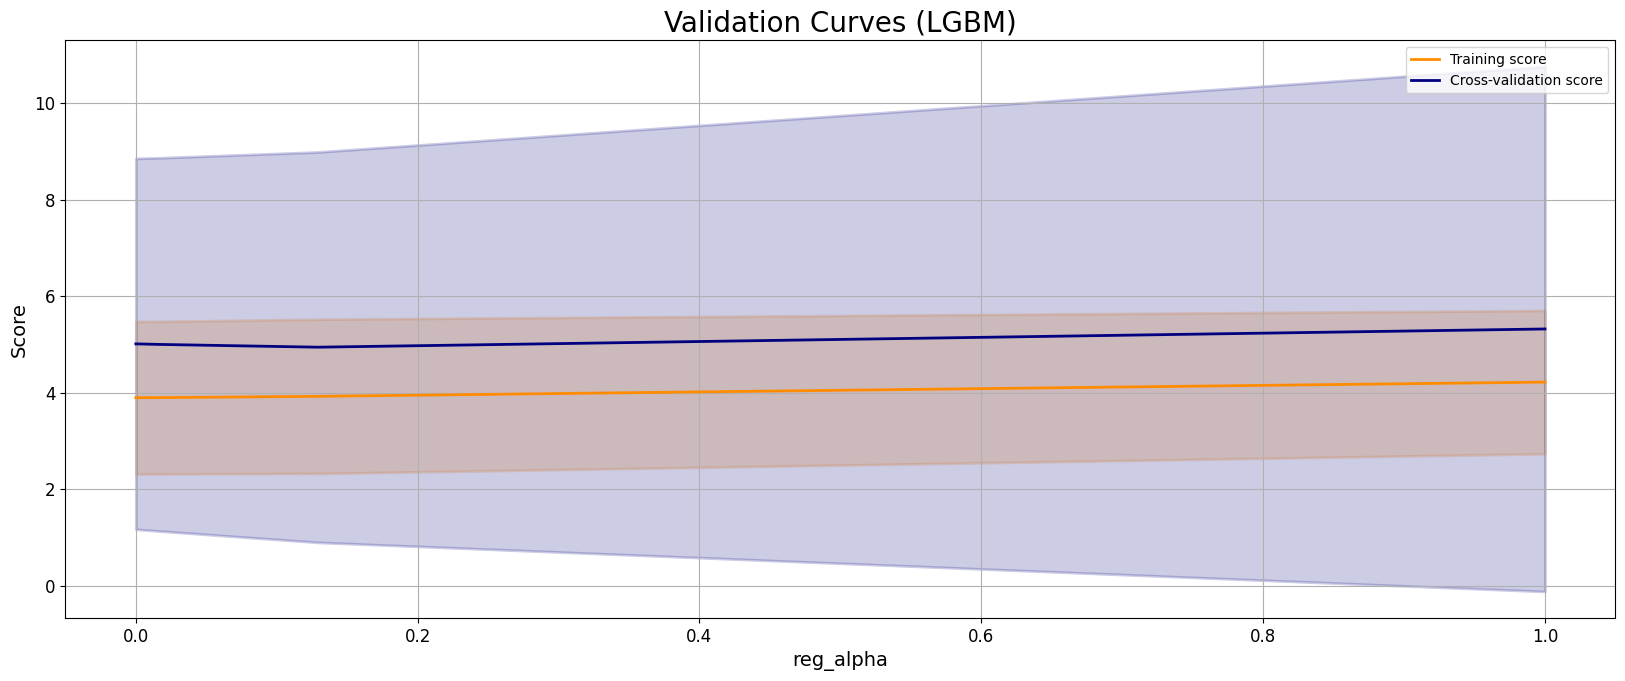

reg_alpha with lowest score: 0.12915496650148828


In [107]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [108]:
param_name = "reg_lambda"
param_range = np.logspace(-5, -1, 10)

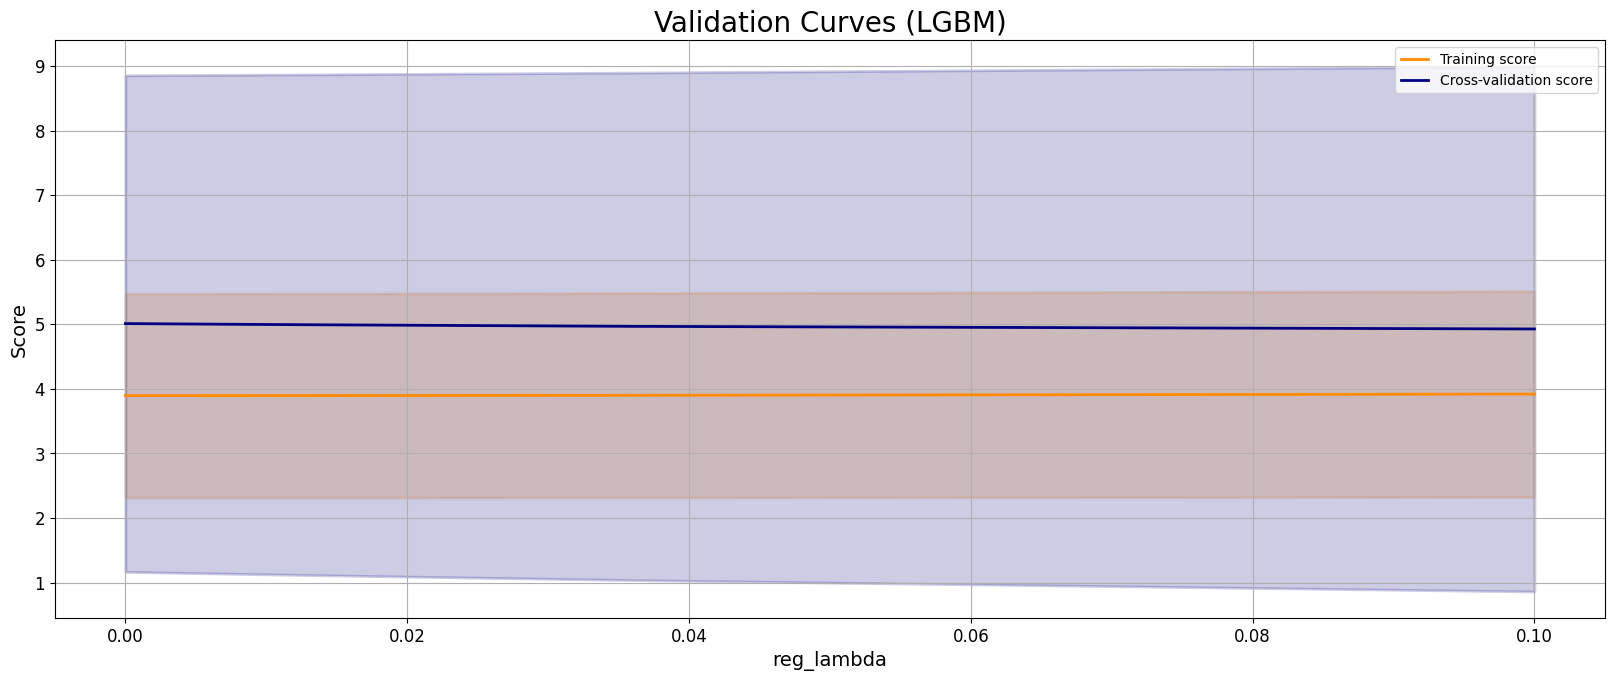

reg_lambda with lowest score: 0.1


In [109]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [110]:
param_name = "scale_pos_weight"
param_range = np.logspace(-5, 0, 10)

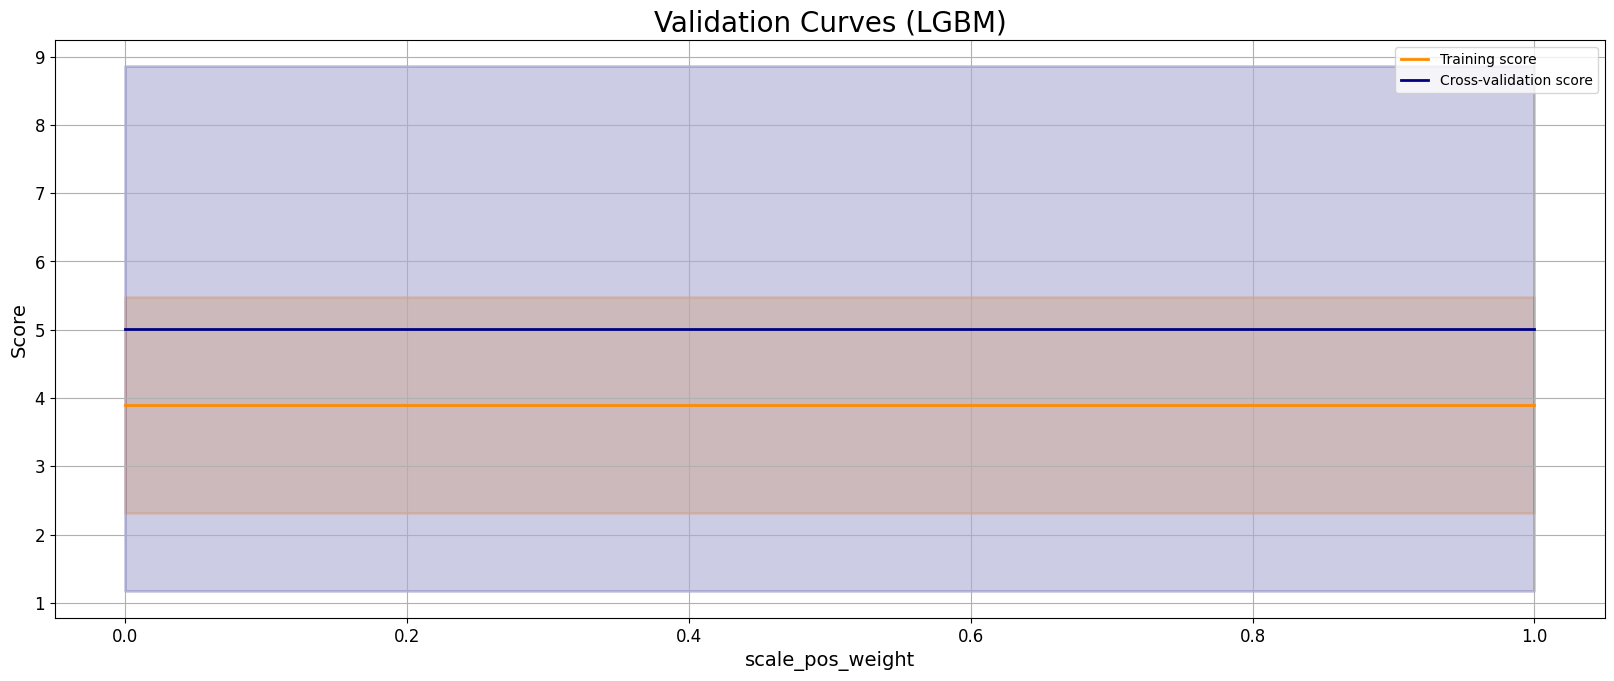

scale_pos_weight with lowest score: 0.0016681005372000592


In [111]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [112]:
param_name = "base_score"
param_range = np.linspace(0.1, 10, 10)

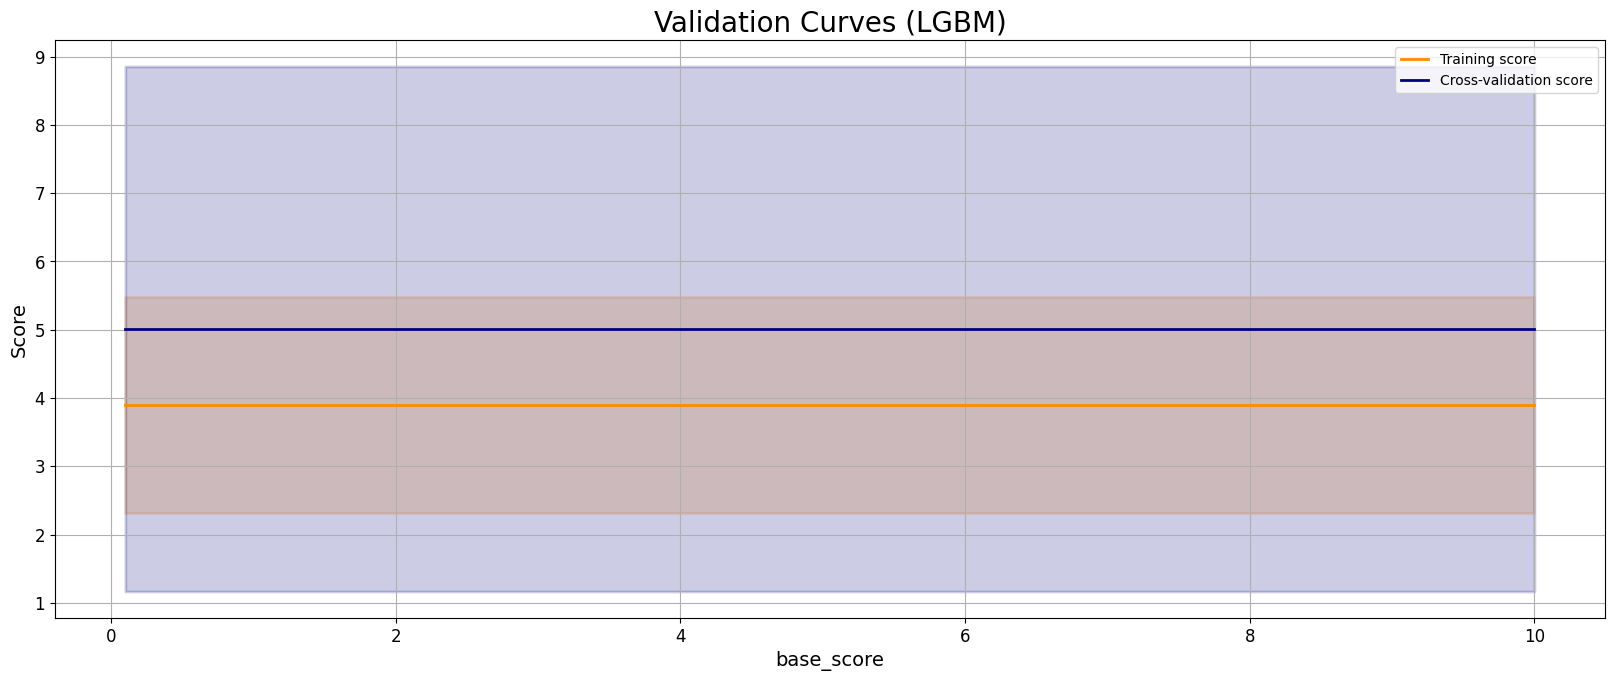

base_score with lowest score: 5.6


In [113]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [114]:
param_name = "importance_type"
param_range = ["gain", "weight", "cover", "total_gain", "total_cover"]

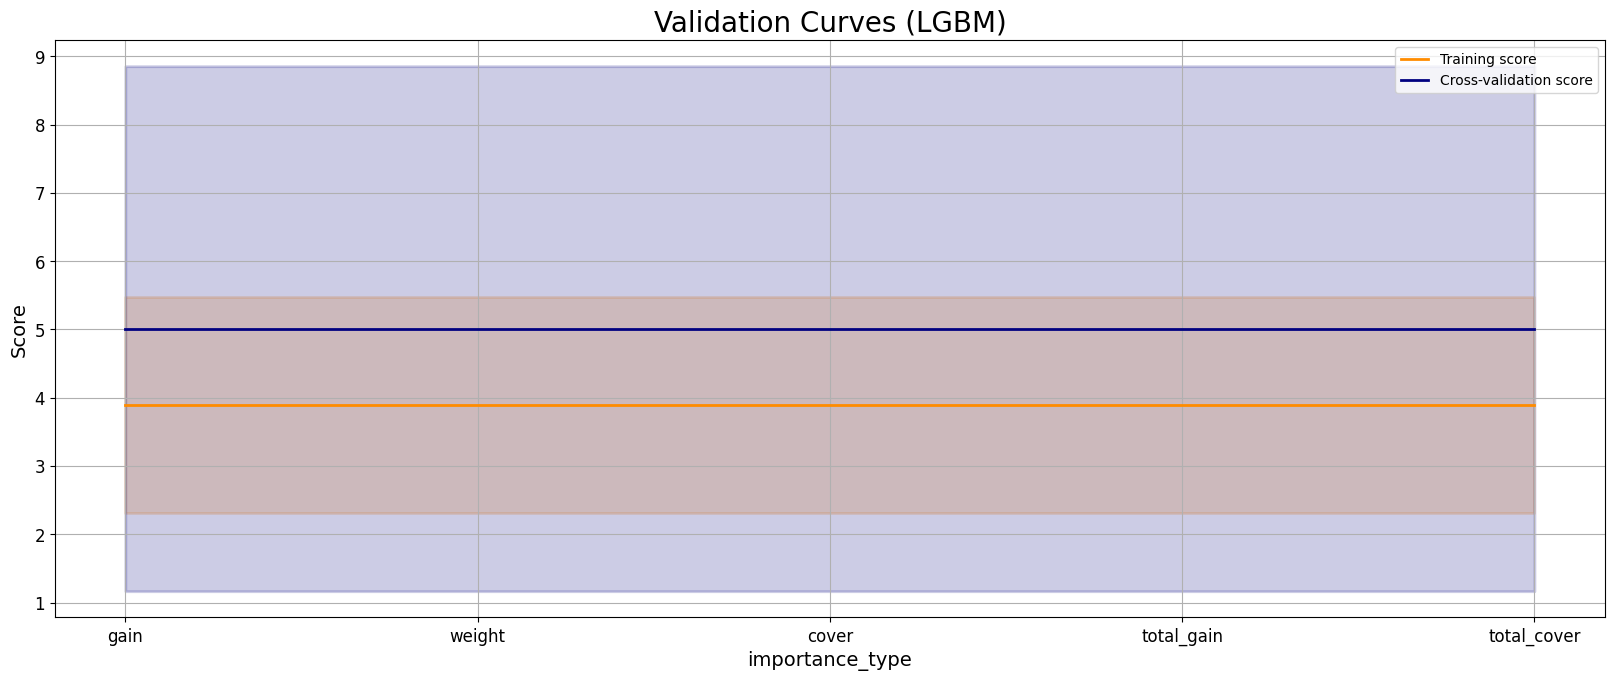

importance_type with lowest score: total_gain


In [115]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

#### Hyperparameter Tuning

In [151]:
def fit_and_validate_xgb_model(
    X,
    y,
    train_index,
    val_index,
    params,
):
    X_tr, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]

    model = xgb.XGBRegressor(random_state=42, **params)

    # train model
    _ = model.fit(X_tr, y_tr)

    # obtain predictions
    y_val_pred = model.predict(X_val)

    # return metrics
    return mean_squared_error(y_val, y_val_pred, squared=False)

In [152]:
def objective(trial: optuna.trial.Trial) -> float:
    eta = trial.suggest_float("eta", 1e-5, 1, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 1, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 1, log=True)
    learning_rate = trial.suggest_float(
        "learning_rate", 1e-5, 1, log=True
    )
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    updater = trial.suggest_categorical(
        "updater", ["shotgun", "coord_descent"]
    )

    params = {
        "objective": "reg:squarederror",
        "booster": "gblinear",
        "eta": eta,
        "reg_lambda": reg_lambda,
        "reg_alpha": reg_alpha,
        "learning_rate": learning_rate,
        "updater": updater,
        "n_estimators": n_estimators,
        "eval_metric": "rmse",
    }

    n_splits = 5
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    cv_mae = [None] * n_splits
    for i, (train_index, test_index) in enumerate(
        cv.split(X_train_fit, y_train_fit["Absorbance 254nm"])
    ):
        cv_mae[i] = fit_and_validate_xgb_model(
            X_train_fit,
            y_train_fit["Absorbance 254nm"],
            train_index,
            test_index,
            params,
        )

    # saving the individual fold holdout metrics
    # uncomment this line if you don't want this
    trial.set_user_attr("split_mae", cv_mae)

    return np.mean(cv_mae)

In [153]:
study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///XGBoost.sqlite3",
    study_name="Hyperparameter Tuning - All Features"
    + " + "
    + str(further_features),
    load_if_exists=True,
)
study.optimize(
    objective,
    n_trials=200,
    show_progress_bar=True,
)

[I 2024-04-04 12:44:25,033] Using an existing study with name 'Hyperparameter Tuning - All Features + ['Year']' instead of creating a new one.


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-04 12:44:25,339] Trial 211 finished with value: 4.397541298239507 and parameters: {'eta': 0.00812405784666797, 'reg_lambda': 3.445457555700908e-07, 'reg_alpha': 0.1198414474886981, 'learning_rate': 0.015129347538285395, 'n_estimators': 187, 'updater': 'shotgun'}. Best is trial 131 with value: 4.377072380200963.
[I 2024-04-04 12:44:25,461] Trial 212 finished with value: 4.398021260099383 and parameters: {'eta': 0.006972099758917894, 'reg_lambda': 3.3906356855878784e-08, 'reg_alpha': 0.06608570252725159, 'learning_rate': 0.01730945617736477, 'n_estimators': 150, 'updater': 'shotgun'}. Best is trial 131 with value: 4.377072380200963.
[I 2024-04-04 12:44:25,595] Trial 213 finished with value: 4.406539315317891 and parameters: {'eta': 0.0076414647264407415, 'reg_lambda': 5.725276619981511e-08, 'reg_alpha': 0.00011155687653081228, 'learning_rate': 0.017223544249379913, 'n_estimators': 158, 'updater': 'shotgun'}. Best is trial 131 with value: 4.377072380200963.
[I 2024-04-04 12:44:

KeyboardInterrupt: 

In [154]:
study.best_params

{'eta': 0.009723354799984037,
 'reg_lambda': 3.357709103739226e-08,
 'reg_alpha': 0.0923114780922092,
 'learning_rate': 0.018831885769480094,
 'n_estimators': 152,
 'updater': 'shotgun'}

In [155]:
params = study.best_params
params["objective"] = "reg:squarederror"
params["booster"] = "gblinear"

In [156]:
# params['n_estimators'] = 1000
# params['learning_rate'] = 0.7

In [157]:
param = {}
param["objective"] = "reg:squarederror"
param["booster"] = "gblinear"
param["n_estimators"] = 10
param["learning_rate"] = 0.5

In [158]:
booster = xgb.XGBRegressor(
    random_state=42,
    **params,
)

booster.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.009723354799984037,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.018831885769480094, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=152, n_jobs=None,
             num_parallel_tree=None, ...)

### Feature Importance

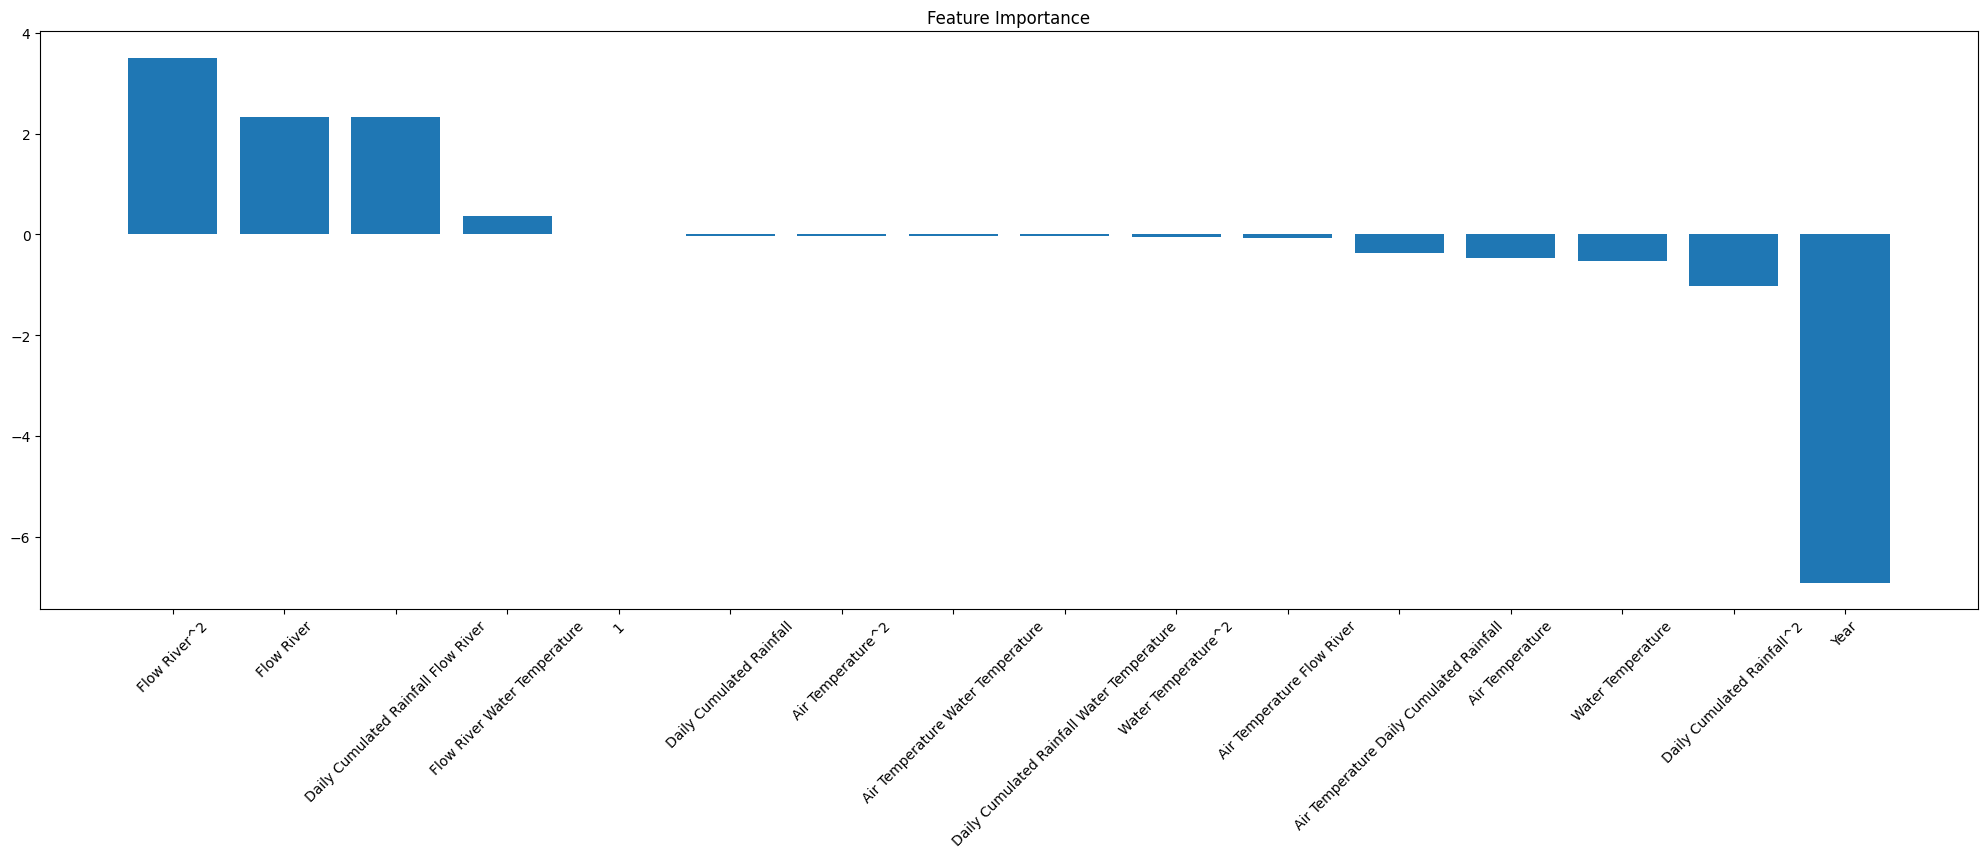

In [159]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance["feature"] = booster.feature_names_in_
feature_importance["importance"] = -booster.feature_importances_

feature_importance = feature_importance.sort_values(
    by="importance", ascending=False
)

# plot the importance of each feature
plt.figure(figsize=(25, 7.5))
plt.bar(
    x=feature_importance["feature"],
    height=feature_importance["importance"],
)

# rotate the x axis words by 45°
plt.xticks(rotation=45)

plt.title("Feature Importance")
plt.show()

### Predictions

In [160]:
mapie_cqr = MapieRegressor(booster, cv="prefit", random_state=42)
mapie_cqr.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

MapieRegressor(cv='prefit',
               estimator=XGBRegressor(base_score=None, booster='gblinear',
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eta=0.009723354799984037,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=0.018831885769480094,
                                      max_bin=None, max_cat_threshold=None,
                                      max_cat_to_onehot=None,
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=152,
                                      n_jobs=None, num_parallel_tree=None, ...),
               method='base', random_state=42)

In [161]:
alpha = 0.1

# Evaluate prediction and coverage level on testing set
y_med, y_pis_cqr = mapie_cqr.predict(X_test_fit, alpha=alpha)
y_lower = y_pis_cqr[:, 0, 0]
y_upper = y_pis_cqr[:, 1, 0]

coverage_cqr = regression_coverage_score(
    y_test_fit["Absorbance 254nm"], y_lower, y_upper
)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


In [162]:
print(f"Coverage: {coverage_cqr}")

Coverage: 0.9696969696969697


#### Compute Measures

In [163]:
rmse = np.sqrt(
    mean_squared_error(y_test_fit["Absorbance 254nm"], y_med)
)
r2 = r2_score(y_test_fit["Absorbance 254nm"], y_med)

print(f"RMSE: {rmse:.2f}")
print(f"R\u00b2: {r2:.2f}")

RMSE: 2.85
R²: 0.36


### Plots

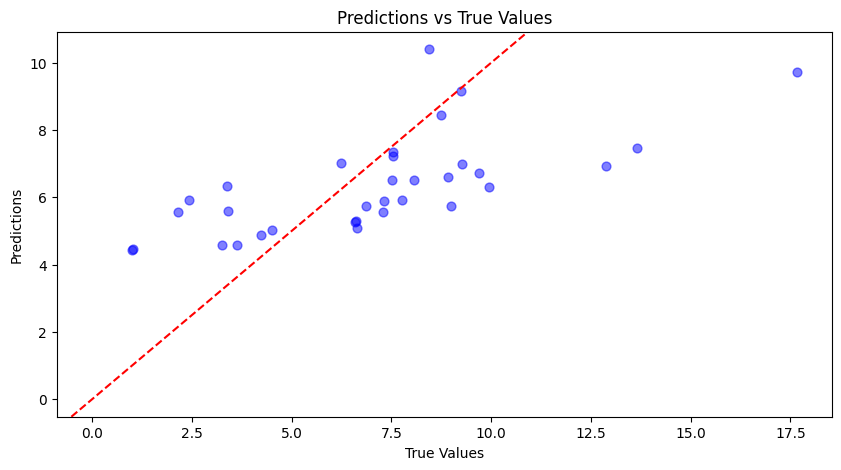

In [164]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(
    y_test_fit["Absorbance 254nm"], y_med, c="b", s=40, alpha=0.5
)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

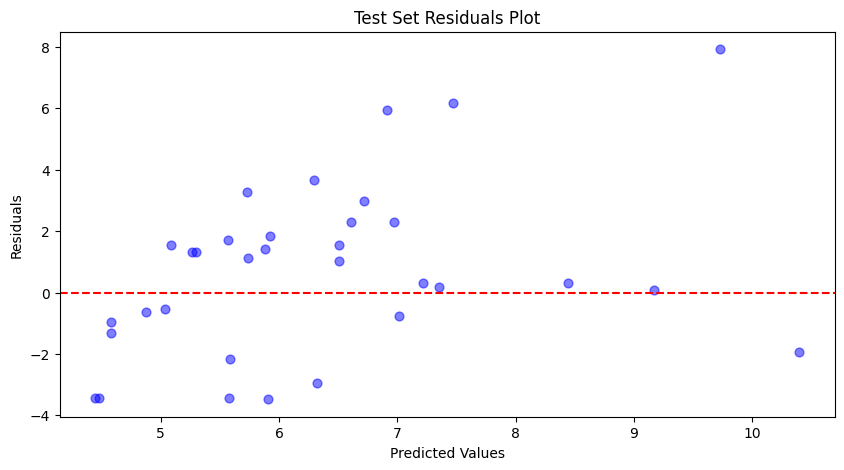

In [165]:
# plot the residuals
residuals = y_test_fit["Absorbance 254nm"] - y_med
plt.figure(figsize=(10, 5))
plt.scatter(y_med, residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

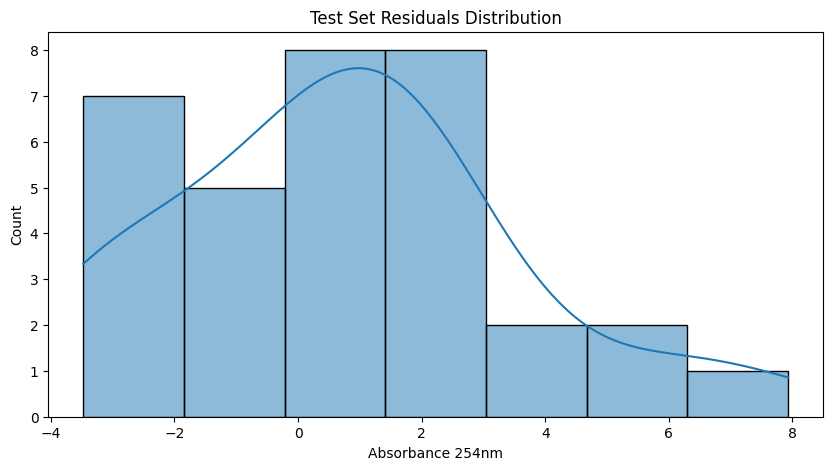

In [166]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

In [167]:
# get training residuals
train_predictions = booster.predict(X_train_fit)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

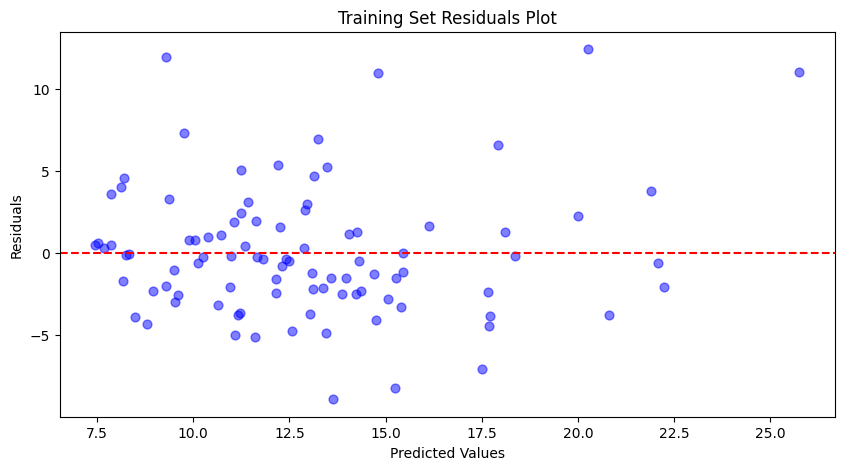

In [168]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

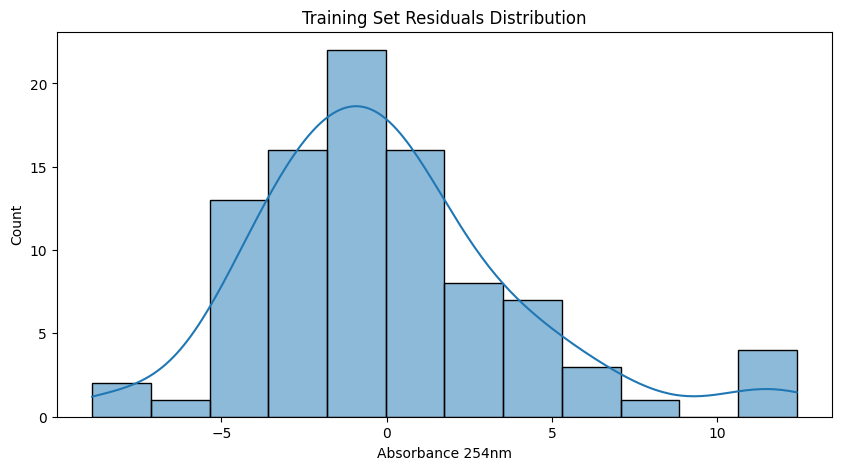

In [169]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

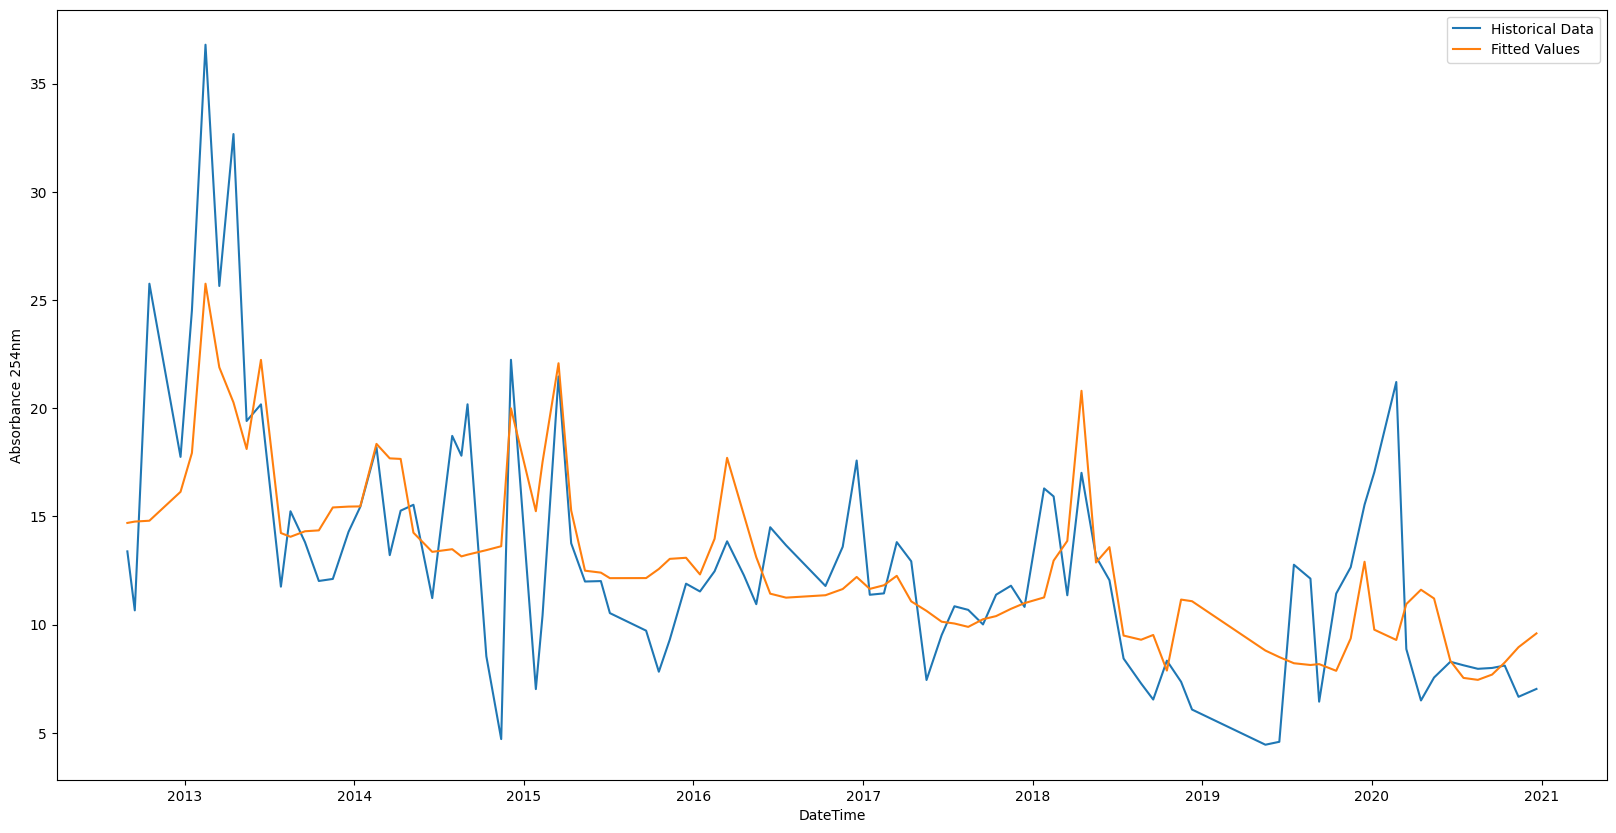

In [170]:
# plot the time series fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train["DateTime"], y=train_predictions, label="Fitted Values"
)

plt.show()

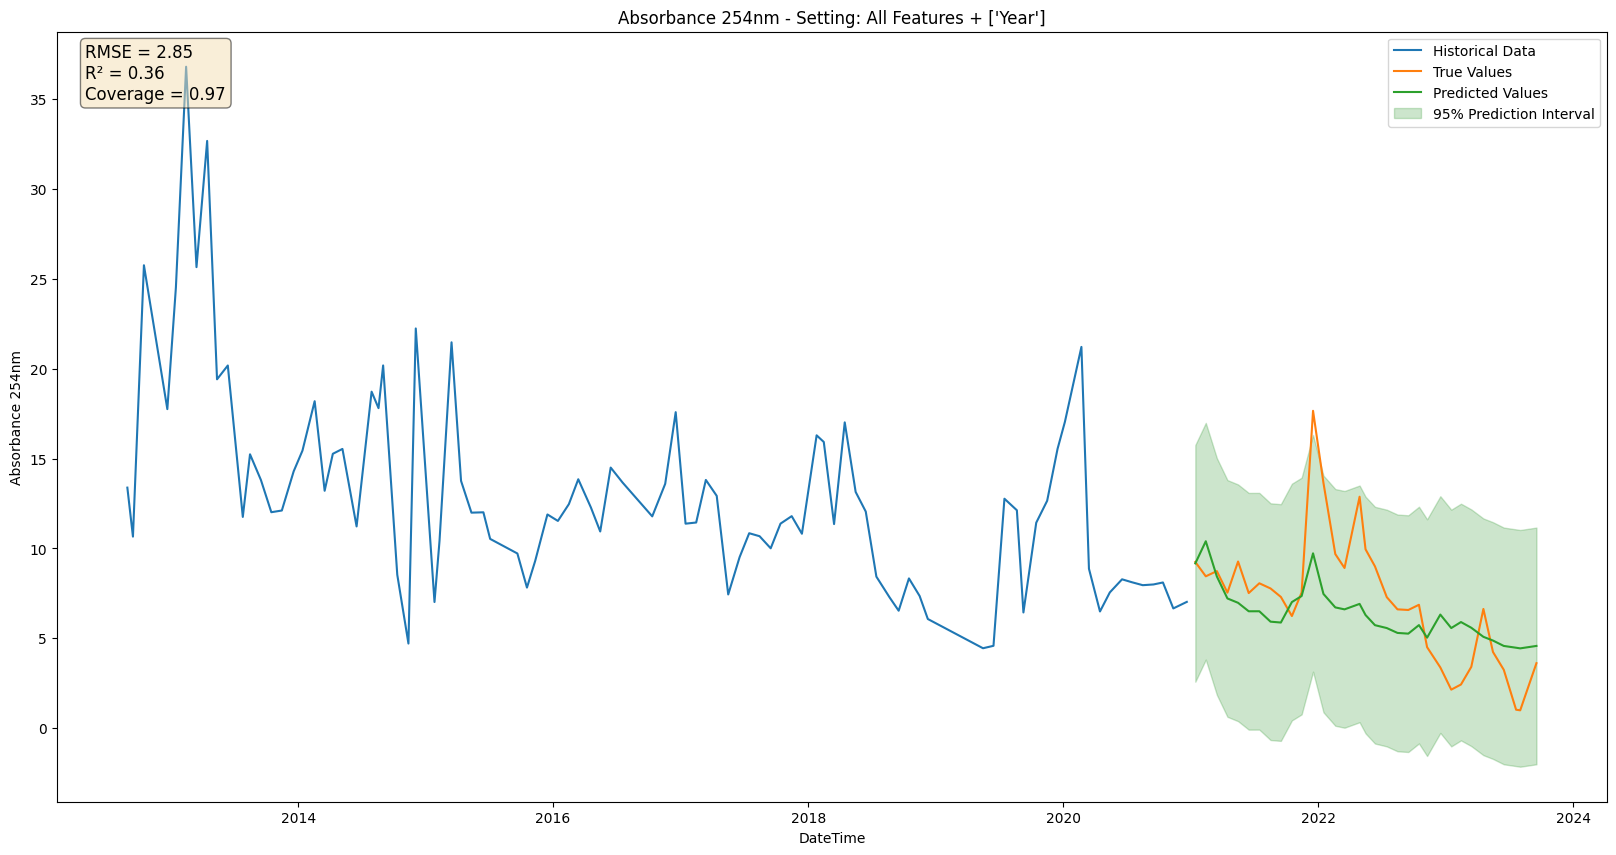

In [171]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(x=y_test["DateTime"], y=y_med, label="Predicted Values")
# plot std of predictions
plt.fill_between(
    y_test["DateTime"],
    y_lower,
    y2=y_upper,
    alpha=0.2,
    label="95% Prediction Interval",
    color="g",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
        f"Coverage = {coverage_cqr:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    35,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(
    f"Absorbance 254nm - Setting: All Features + {further_features}"
)

plt.legend()
plt.show()

Comment: prevede un trend crescente, probabilmente dato da qualche feature 

### Store Results

In [172]:
boost_pred = y_med
boost_lower_bound = y_lower
boost_upper_bound = y_upper
boost_rmse = rmse
boost_r2 = r2

# LightGBM (Random Forest with Linear Regressors on leaves)

### Split Data

In [44]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Season", "Month"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [45]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    X[X.columns.difference(["DateTime"] + further_features)]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        X.columns.difference(["DateTime"] + further_features)
    ),
)

X_poly["DateTime"] = X["DateTime"].values

X_poly[further_features] = X[further_features].values

In [46]:
# split data such that 2022 and 2023 are test data
X_train = X_poly[X_poly["DateTime"] < "2021-01-01"]
X_test = X_poly[X_poly["DateTime"] >= "2021-01-01"]

y_train = y[y["DateTime"] < "2021-01-01"]
y_test = y[y["DateTime"] >= "2021-01-01"]

In [47]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

In [48]:
# %%script false --no-raise-error
# split data such that 2022 and 2023 are test data
X_train = X[X["DateTime"] < "2021-01-01"]
X_test = X[X["DateTime"] >= "2021-01-01"]

y_train = y[y["DateTime"] < "2021-01-01"]
y_test = y[y["DateTime"] >= "2021-01-01"]

In [49]:
# %%script false --no-raise-error
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train.copy()
y_test_fit = y_test.copy()

In [50]:
scaler = StandardScaler()
# scale the data and keep the column names
X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

X_train_fit = pd.DataFrame(
    X_train_fit, columns=X_train.columns.difference(["DateTime"])
)
X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_test.columns.difference(["DateTime"])
)

### Train Model

#### Learning and Validation Curves

In [391]:
def learning_curves(
    estimator,
    title,
    X,
    y,
    cv=None,
    train_sizes=np.linspace(0.3, 1.0, 5),
):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator,
        X,
        y,
        train_sizes=train_sizes,
        cv=cv,
        scoring="neg_mean_squared_error",
    )

    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    train_scores_std = np.sqrt(np.std(train_scores, axis=1))
    validation_scores_mean = np.sqrt(
        -np.mean(validation_scores, axis=1)
    )
    validation_scores_std = np.sqrt(np.std(validation_scores, axis=1))

    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(20, 7.5))
    plt.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="r",
        label="Training error",
    )
    plt.plot(
        train_sizes,
        validation_scores_mean,
        "o-",
        color="g",
        label="Validation error",
    )
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.rcParams["font.size"] = 10
    plt.ylabel("RMSE", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    title = title
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    plt.show()

In [392]:
def validation_curves(
    estimator,
    title,
    X,
    y,
    cv=None,
    param_name=None,
    param_range=None,
    fit_params=None,
):
    train_scores, test_scores = validation_curve(
        estimator,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        fit_params=fit_params,
        cv=cv,
        scoring="neg_mean_squared_error",  #'roc_auc'
        n_jobs=4,
    )
    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    train_scores_std = np.sqrt(np.std(train_scores, axis=1))
    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))
    test_scores_std = np.sqrt(np.std(test_scores, axis=1))

    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(20, 7.5))
    plt.title(title, fontsize=20)
    plt.xlabel(param_name, fontsize=14)
    plt.ylabel("Score", fontsize=14)
    lw = 2
    plt.plot(
        param_range,
        train_scores_mean,
        label="Training score",
        color="darkorange",
        lw=lw,
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        param_range,
        test_scores_mean,
        label="Cross-validation score",
        color="navy",
        lw=lw,
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.rcParams["font.size"] = 10
    plt.legend(loc="best")
    # plt.ylim(4, 8)
    plt.grid(visible=True)
    plt.show()

    # print param value with lowest test score
    print(
        f"{param_name} with lowest score:",
        param_range[np.argmin(test_scores_mean)],
    )

In [393]:
params_lgb = {
    "objective": "regression",
    "linear_tree": True,
    "random_state": 42,
}

In [394]:
model = LGBMRegressor(**params_lgb)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 22, number of used features: 0
[LightGBM] [Info] Start training from score 12.915934
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

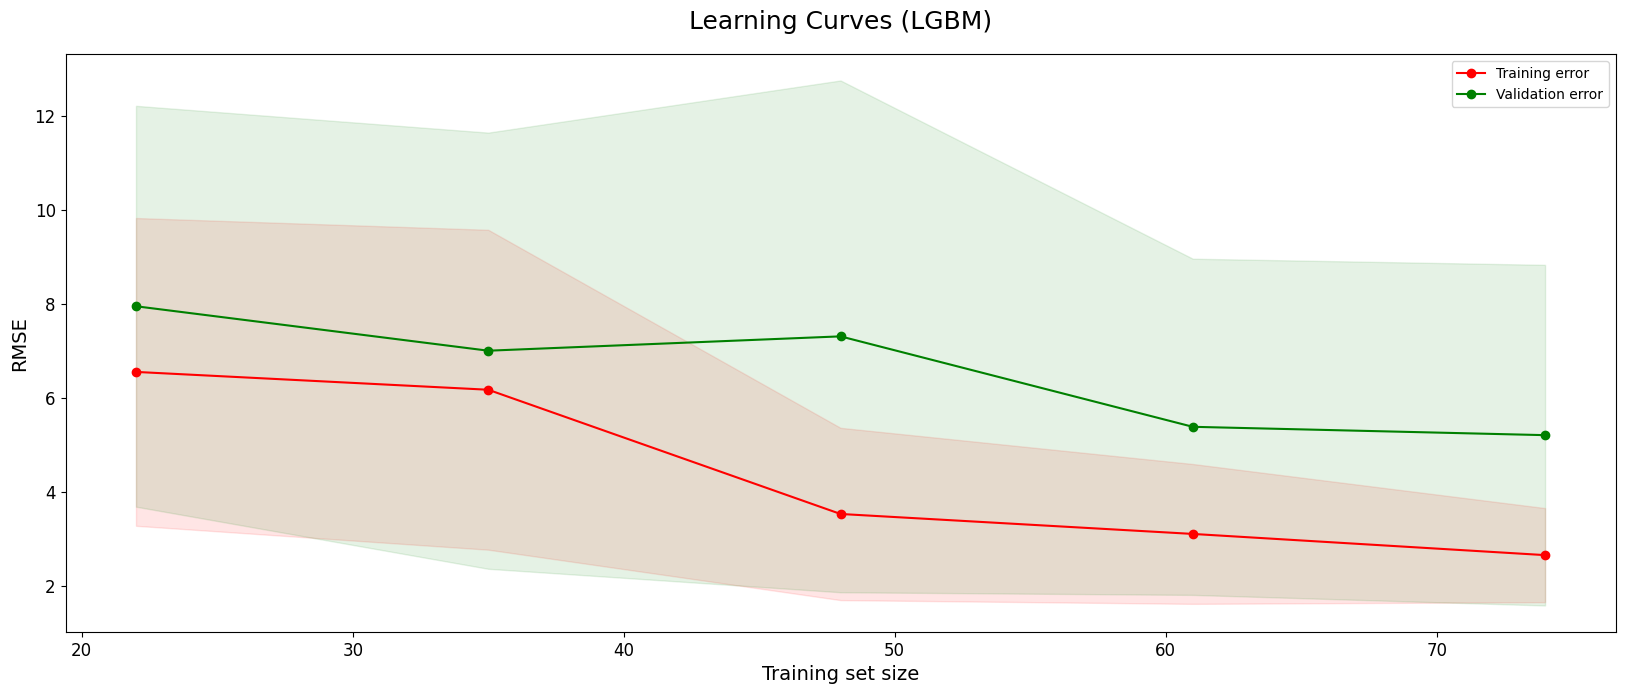

In [395]:
title = "Learning Curves (LGBM)"
learning_curves(
    model, title, X_train_fit, y_train_fit["Absorbance 254nm"], cv=5
)

In [ ]:
param_name = "n_estimators"
param_range = np.arange(1, 100, 5)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219

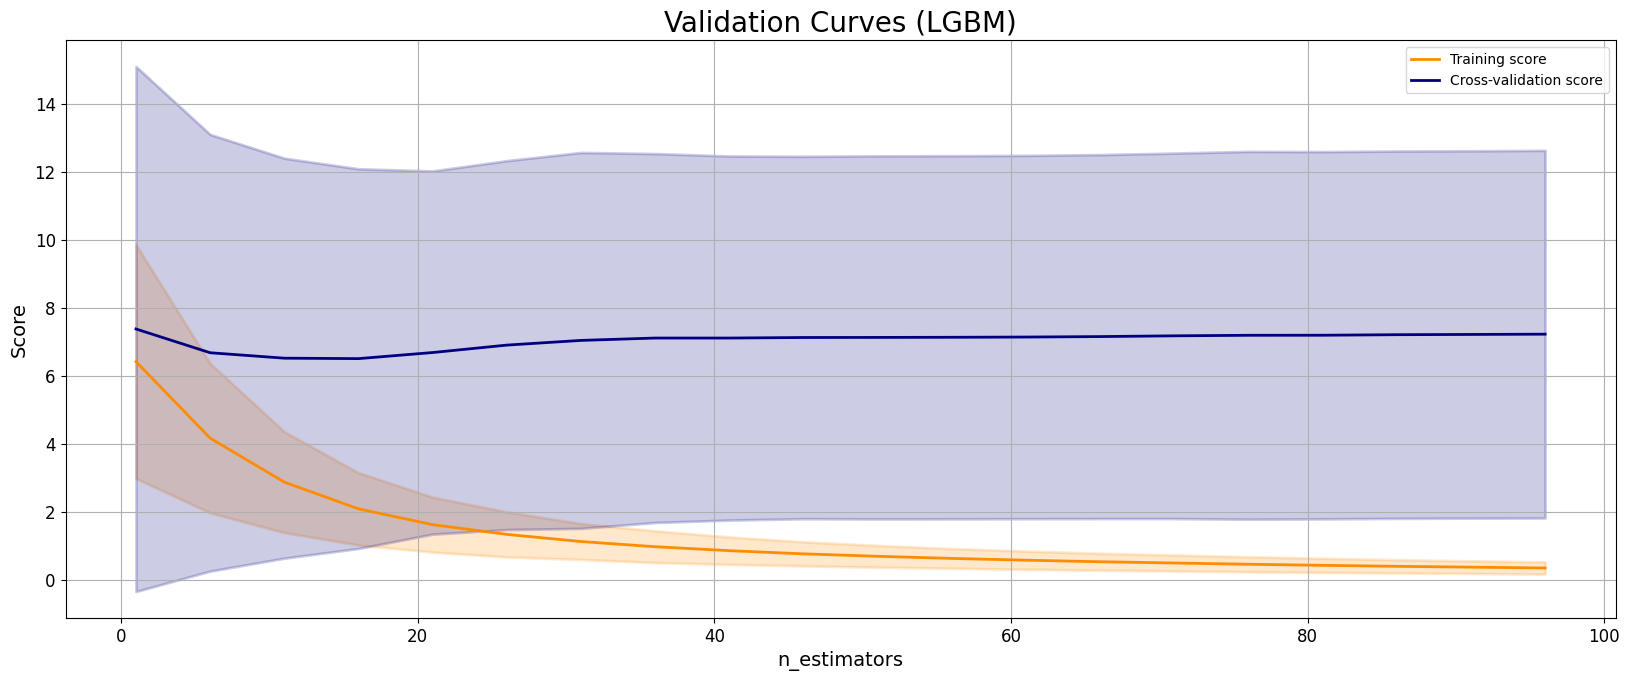

n_estimators with lowest score: 16


In [ ]:
title = "Validation Curves (LGBM)"
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [ ]:
param_name = "learning_rate"
param_range = np.logspace(-3, -1, 10)

In [ ]:
np.logspace(-3, -1, 10)

array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

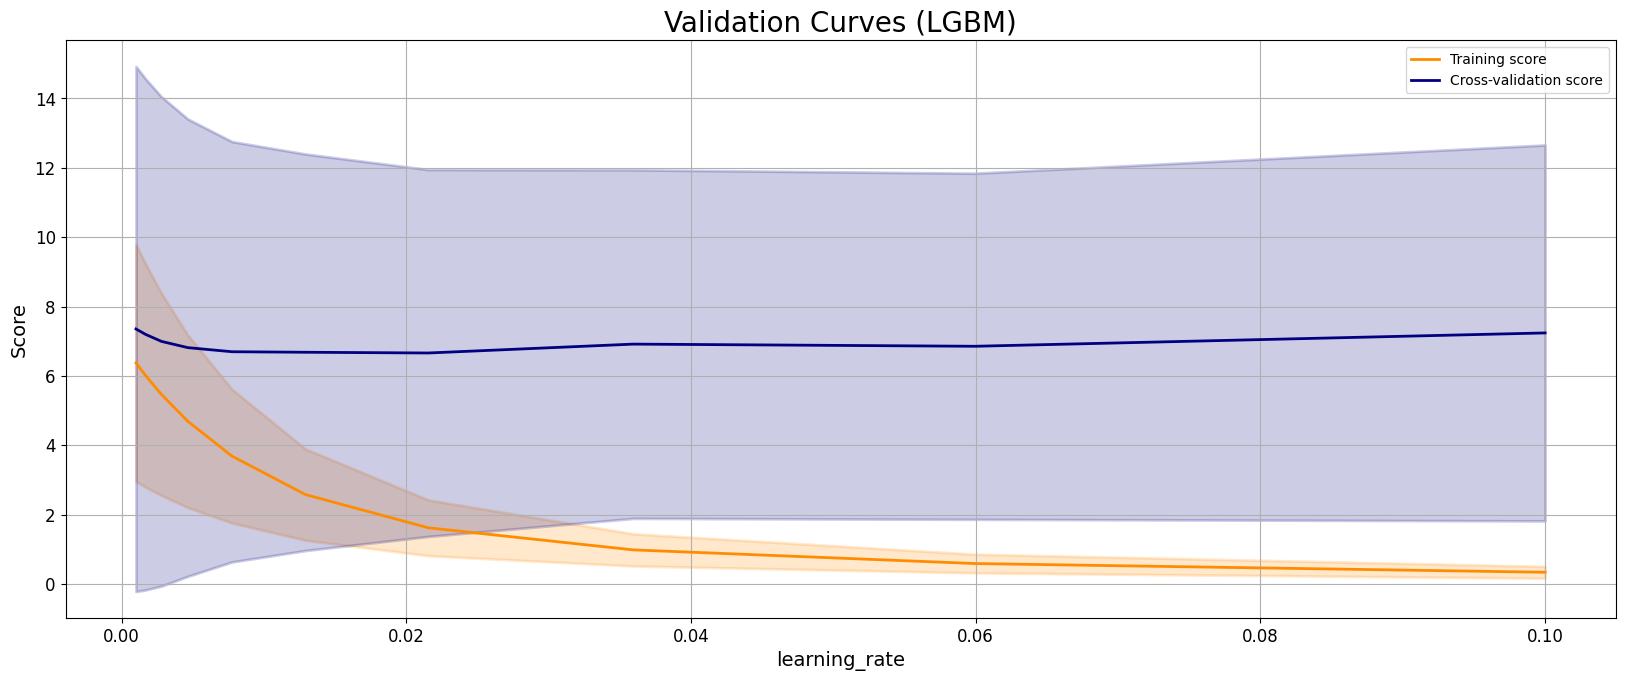

learning_rate with lowest score: 0.021544346900318832


In [ ]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [ ]:
param_name = "num_leaves"
param_range = np.arange(2, 50, 2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

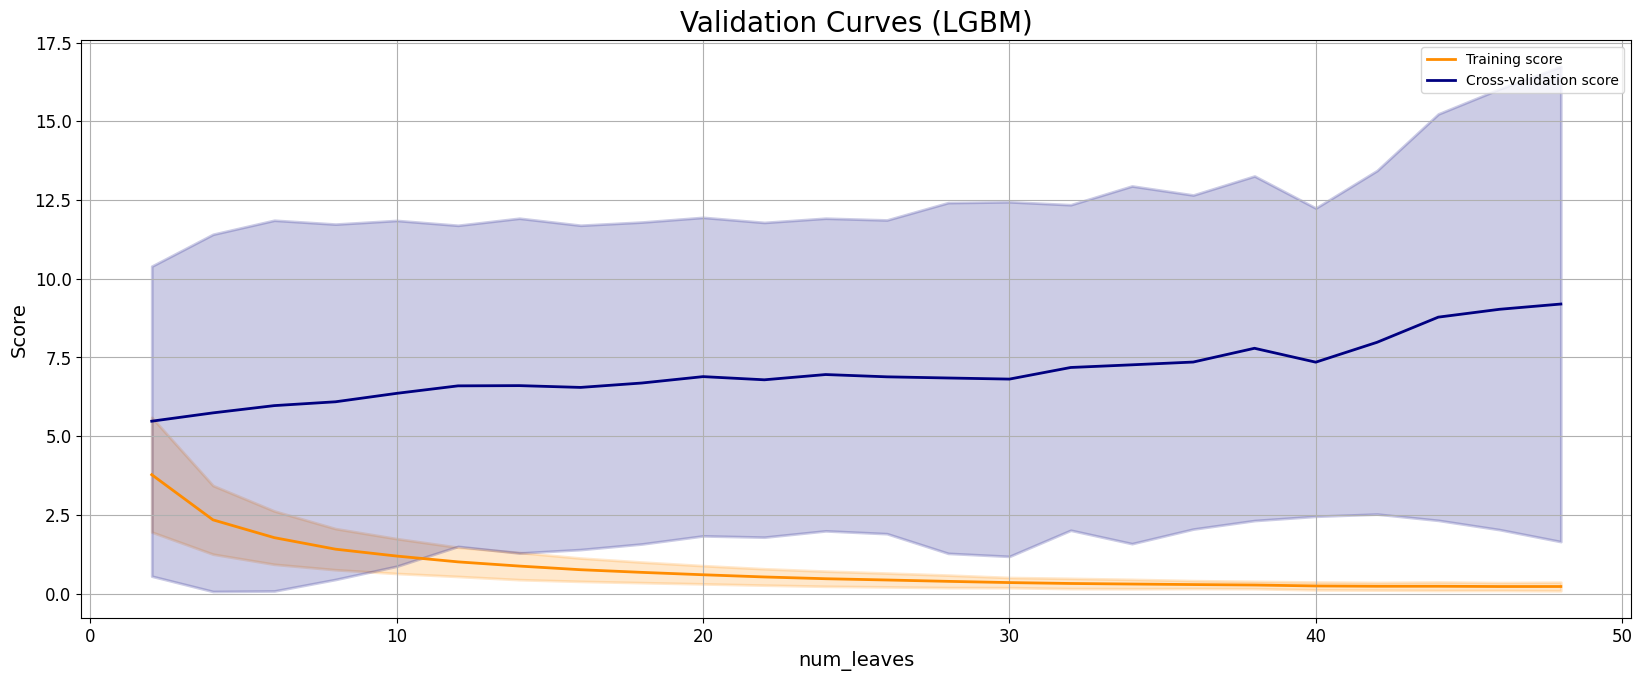

num_leaves with lowest score: 2


In [ ]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [ ]:
param_name = "lambda_l1"
param_range = np.logspace(-5, -1, 10)

[LightGBM] [Warning] lambda_l1 is set=1e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-05
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] lambda_l1 is set=2.782559402207126e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.782559402207126e-05
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=2.782559402207126e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.782559402207126e-05
[Light

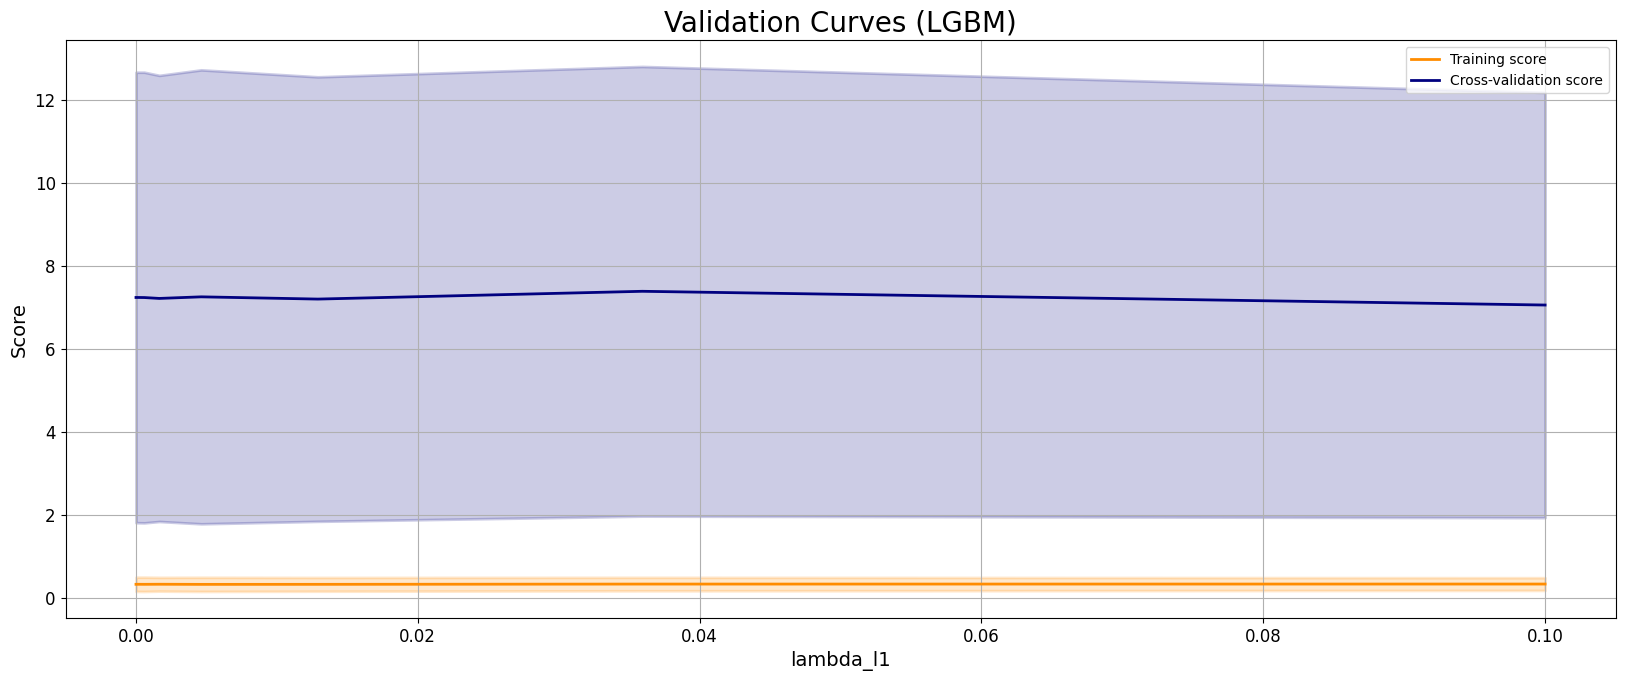

lambda_l1 with lowest score: 0.1


In [ ]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [ ]:
param_name = "lambda_l2"
param_range = np.logspace(-5, -1, 10)

[LightGBM] [Warning] lambda_l2 is set=1e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-05
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=1e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-05
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] lambda_l2 is set=2.782559402207126e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.782559402207126e-05
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=2.782559402207126e-05, reg_lambda=0.0 wi

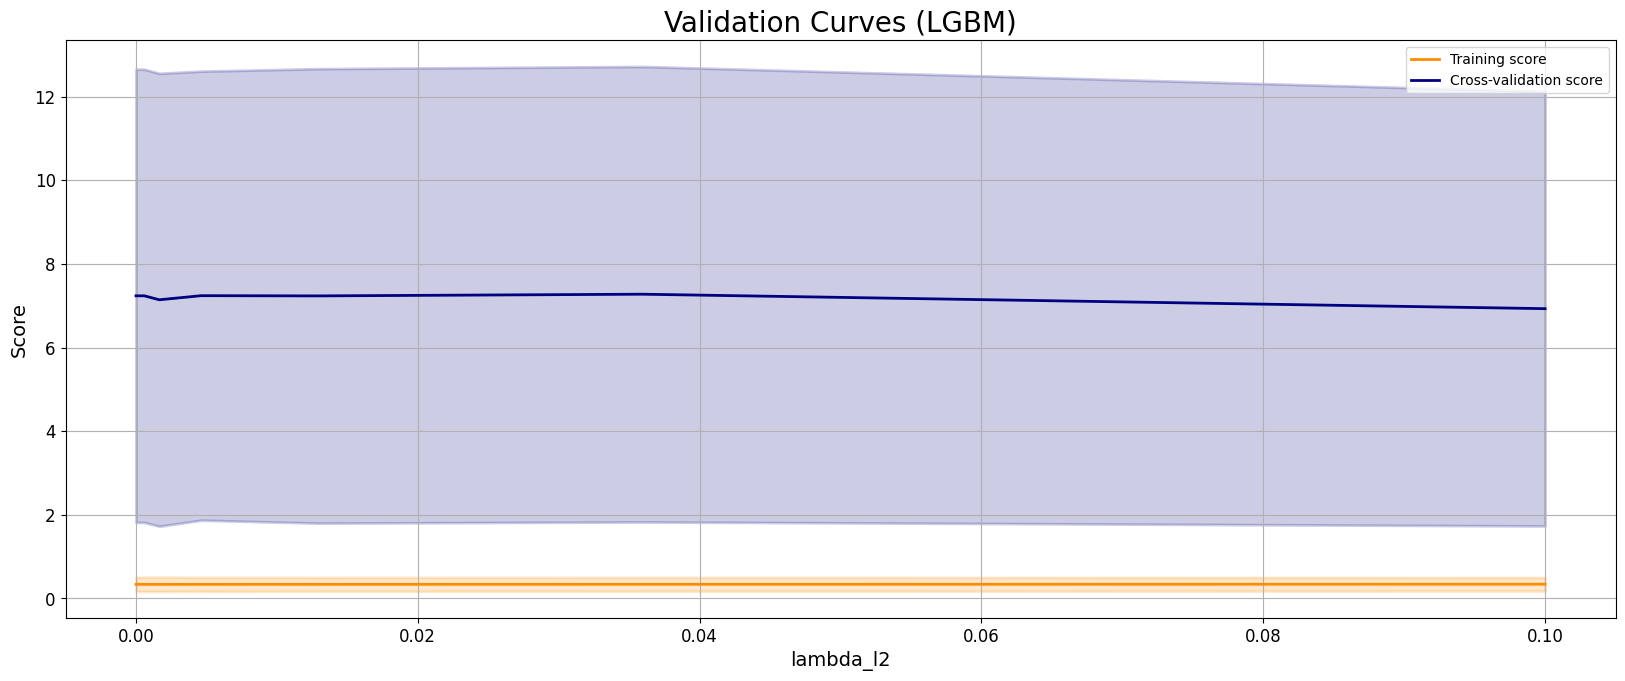

lambda_l2 with lowest score: 0.1


In [ ]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [ ]:
param_name = "max_depth"
param_range = np.arange(2, 20, 1)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

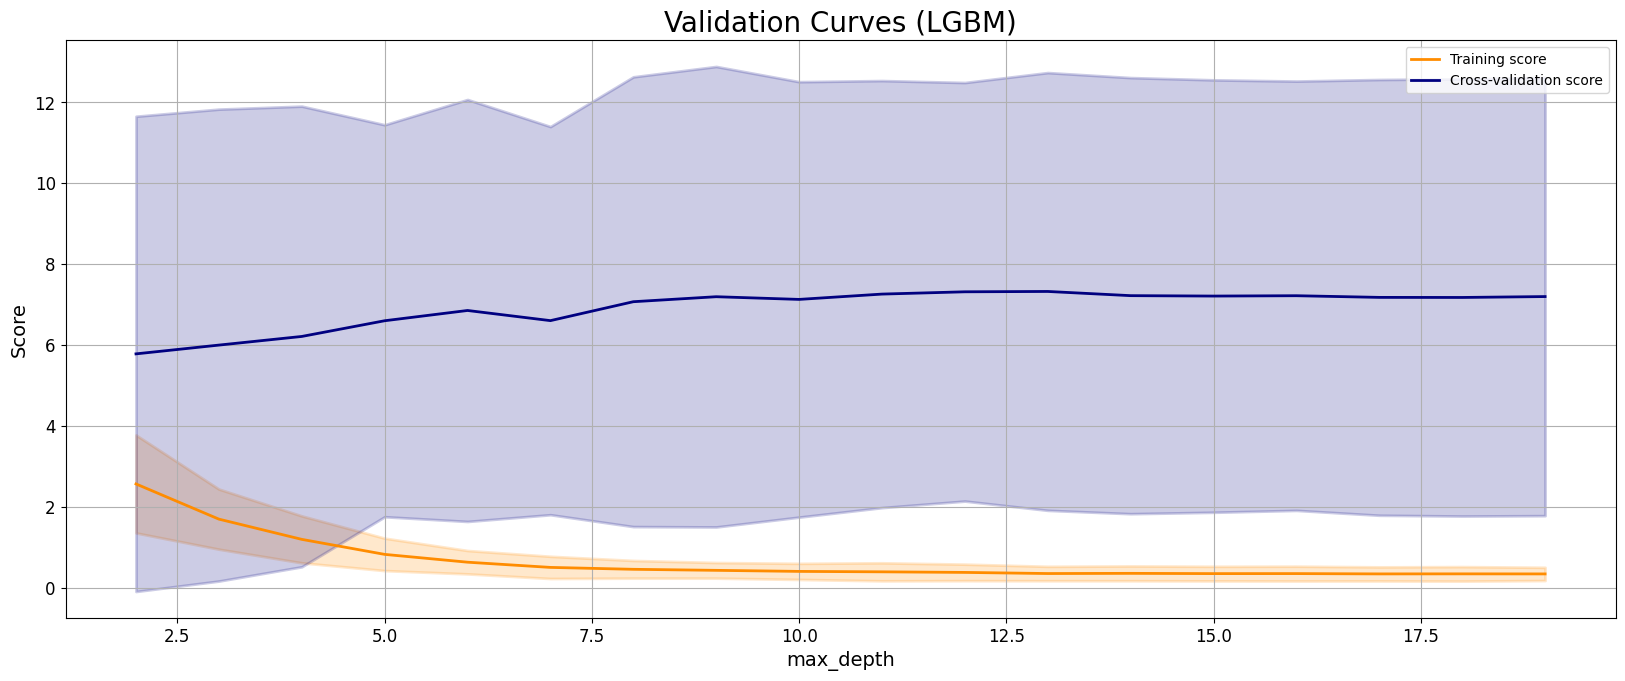

max_depth with lowest score: 2


In [ ]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

In [ ]:
param_name = "max_bin"
param_range = np.arange(2, 255, 5)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 12
[LightGBM] [Info] Start training from score 10.652025
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info

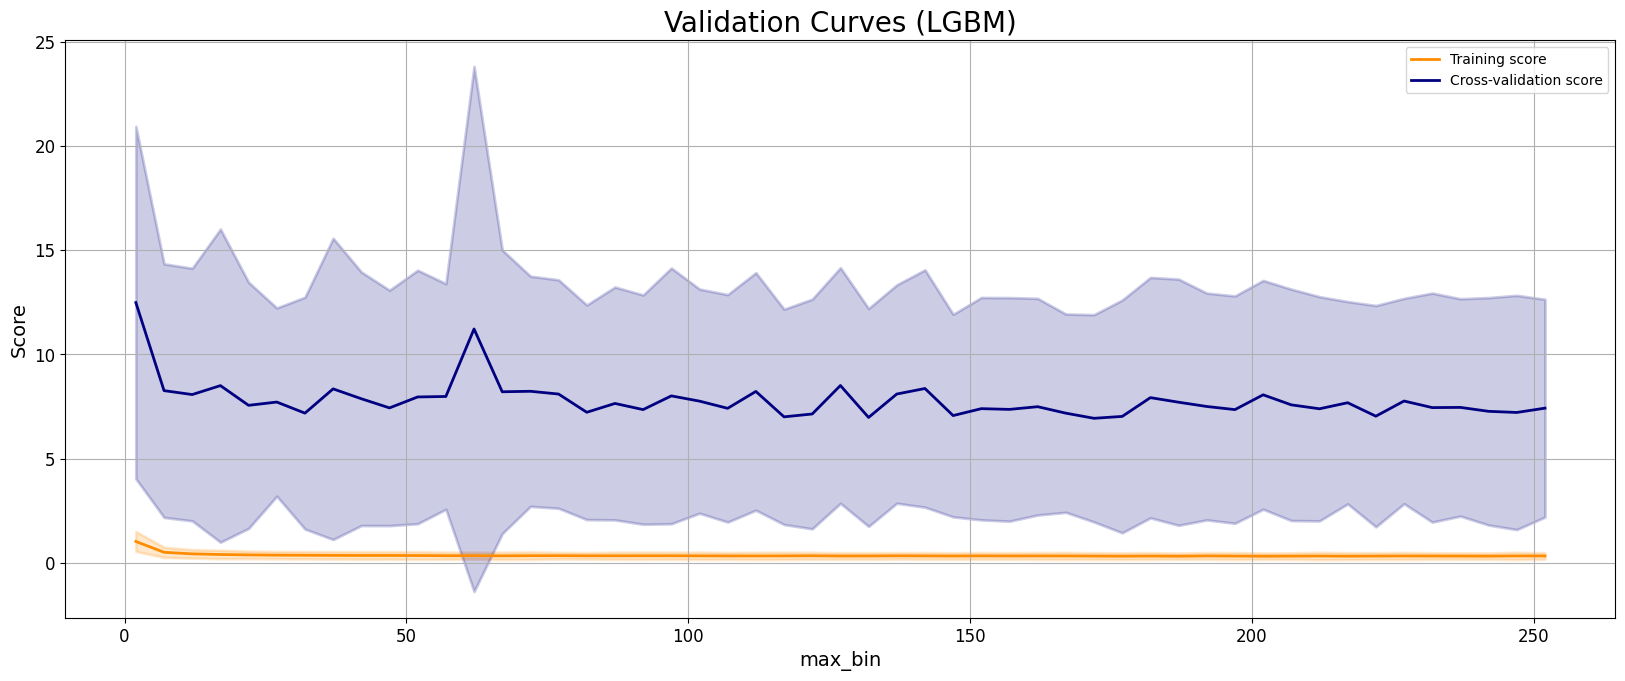

max_bin with lowest score: 172


In [ ]:
validation_curves(
    model,
    title,
    X_train_fit,
    y_train_fit["Absorbance 254nm"],
    cv=5,
    param_name=param_name,
    param_range=param_range,
)

#### Hyperparameter Tuning

In [51]:
def fit_and_validate_lgbm_model(
    X,
    y,
    train_index,
    val_index,
    params,
):
    X_tr, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]

    model = LGBMRegressor(
        objective="regression",
        random_state=42,
        linear_tree=True,
    )

    if params is not None:
        model.set_params(**params)

    # train model
    _ = model.fit(X_tr, y_tr)

    # obtain predictions
    y_val_pred = model.predict(X_val)

    # return metrics
    return mean_squared_error(y_val, y_val_pred, squared=False)

In [52]:
def objective(trial: optuna.trial.Trial) -> float:
    config = {
        "n_estimators": trial.suggest_int(
            "n_estimators", 1, 20, step=1
        ),
        "learning_rate": trial.suggest_float(
            "learning_rate", 1e-3, 1, log=True
        ),
        "max_depth": trial.suggest_int("max_depth", 2, 16, step=1),
        "num_leaves": trial.suggest_int("num_leaves", 2, 20, step=1),
        "min_data_in_leaf": trial.suggest_int(
            "min_data_in_leaf", 2, 50, step=1
        ),
        "lambda_l1": trial.suggest_float(
            "lambda_l1", 1e-3, 10, log=True
        ),
        "lambda_l2": trial.suggest_float(
            "lambda_l2", 1e-3, 10, log=True
        ),
        "min_split_gain": trial.suggest_float(
            "min_split_gain", 0, 15, step=0.5
        ),
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 1e-3, 1, log=True
        ),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 1e-3, 1, log=True
        ),
        "min_child_samples": trial.suggest_int(
            "min_child_samples", 20, 1000, log=True
        ),
        "max_bin": trial.suggest_int("max_bin", 10, 500, step=10),
    }

    n_splits = 5
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    cv_mae = [None] * n_splits
    for i, (train_index, test_index) in enumerate(
        cv.split(X_train_fit, y_train_fit["Absorbance 254nm"])
    ):
        cv_mae[i] = fit_and_validate_lgbm_model(
            X_train_fit,
            y_train_fit["Absorbance 254nm"],
            train_index,
            test_index,
            config,
        )

    # saving the individual fold holdout metrics
    # uncomment this line if you don't want this
    trial.set_user_attr("split_mae", cv_mae)

    return np.mean(cv_mae)

In [53]:
study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///LGBM.sqlite3",
    study_name="Hyperparameter Tuning - All Features"
    + " + "
    + str(further_features),
    load_if_exists=True,
)
study.optimize(objective, n_trials=400, show_progress_bar=True)

[I 2024-04-04 12:16:12,901] Using an existing study with name 'Hyperparameter Tuning - All Features + ['Year']' instead of creating a new one.


  0%|          | 0/400 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.6567499716362774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6567499716362774
[LightGBM] [Warning] lambda_l2 is set=0.01401945720397897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01401945720397897
[LightGBM] [Warning] bagging_fraction is set=0.004913094736598305, subsample=0.30490229607188923 will be ignored. Current value: bagging_fraction=0.004913094736598305
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=180 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] feature_fraction is set=0.006068836787517044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.006068836787517044
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.6567499716362774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6567499716362774
[LightGBM] [Warning] lambda_l2 is set=0.01401945720397897, reg_lambda=

KeyboardInterrupt: 

In [54]:
study.best_params

{'n_estimators': 17,
 'learning_rate': 0.6704270447866529,
 'max_depth': 5,
 'num_leaves': 16,
 'min_data_in_leaf': 34,
 'lambda_l1': 0.5831151410852462,
 'lambda_l2': 0.013664416492044728,
 'min_split_gain': 8.5,
 'subsample': 0.5246088619028575,
 'bagging_fraction': 0.022658564852536835,
 'feature_fraction': 0.0016630853004879736,
 'min_child_samples': 107,
 'max_bin': 20}

In [55]:
params = study.best_params

# params['n_estimators'] = 20
params["max_bin"] = 30
params["learning_rate"] = 0.6
# params['lambda_l2'] = 1

In [56]:
%%script false --no-raise-error
params = {
    'n_estimators': 20,
    'learning_rate': 0.2355,
    'max_depth': 10,
    'num_leaves': 20,
    'min_data_in_leaf': 23,
    'lambda_l1': 0.12046319959934189,
    'lambda_l2': 0.0020380665600964157,
    'min_split_gain': 2.0,
    'subsample': 0.714993442284089,
    'bagging_fraction': 0.3723469453323971,
    'feature_fraction': 0.7631924074906202,
    'min_child_samples': 870,
    'max_bin': 365
}

#### Train model with mapie

In [57]:
alpha = 0.1
estimator = LGBMRegressor(
    objective="regression", random_state=42, linear_tree=True, **params
)

estimator.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

[LightGBM] [Warning] lambda_l1 is set=0.5831151410852462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5831151410852462
[LightGBM] [Warning] lambda_l2 is set=0.013664416492044728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013664416492044728
[LightGBM] [Warning] bagging_fraction is set=0.022658564852536835, subsample=0.5246088619028575 will be ignored. Current value: bagging_fraction=0.022658564852536835
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=107 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.0016630853004879736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0016630853004879736
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.5831151410852462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5831151410852462
[LightGBM] [Warning] lambda_l2 is set=0.013664416492044728, reg_lam

LGBMRegressor(bagging_fraction=0.022658564852536835,
              feature_fraction=0.0016630853004879736,
              lambda_l1=0.5831151410852462, lambda_l2=0.013664416492044728,
              learning_rate=0.6, linear_tree=True, max_bin=30, max_depth=5,
              min_child_samples=107, min_data_in_leaf=34, min_split_gain=8.5,
              n_estimators=17, num_leaves=16, objective='regression',
              random_state=42, subsample=0.5246088619028575)

In [58]:
# Calibrate uncertainties on calibration set
mapie_cqr = MapieRegressor(estimator, cv="prefit", random_state=42)
mapie_cqr.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

[LightGBM] [Warning] lambda_l1 is set=0.5831151410852462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5831151410852462
[LightGBM] [Warning] lambda_l2 is set=0.013664416492044728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013664416492044728
[LightGBM] [Warning] bagging_fraction is set=0.022658564852536835, subsample=0.5246088619028575 will be ignored. Current value: bagging_fraction=0.022658564852536835
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=107 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.0016630853004879736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0016630853004879736


MapieRegressor(cv='prefit',
               estimator=LGBMRegressor(bagging_fraction=0.022658564852536835,
                                       feature_fraction=0.0016630853004879736,
                                       lambda_l1=0.5831151410852462,
                                       lambda_l2=0.013664416492044728,
                                       learning_rate=0.6, linear_tree=True,
                                       max_bin=30, max_depth=5,
                                       min_child_samples=107,
                                       min_data_in_leaf=34, min_split_gain=8.5,
                                       n_estimators=17, num_leaves=16,
                                       objective='regression', random_state=42,
                                       subsample=0.5246088619028575),
               method='base', random_state=42)

### Feature Importance

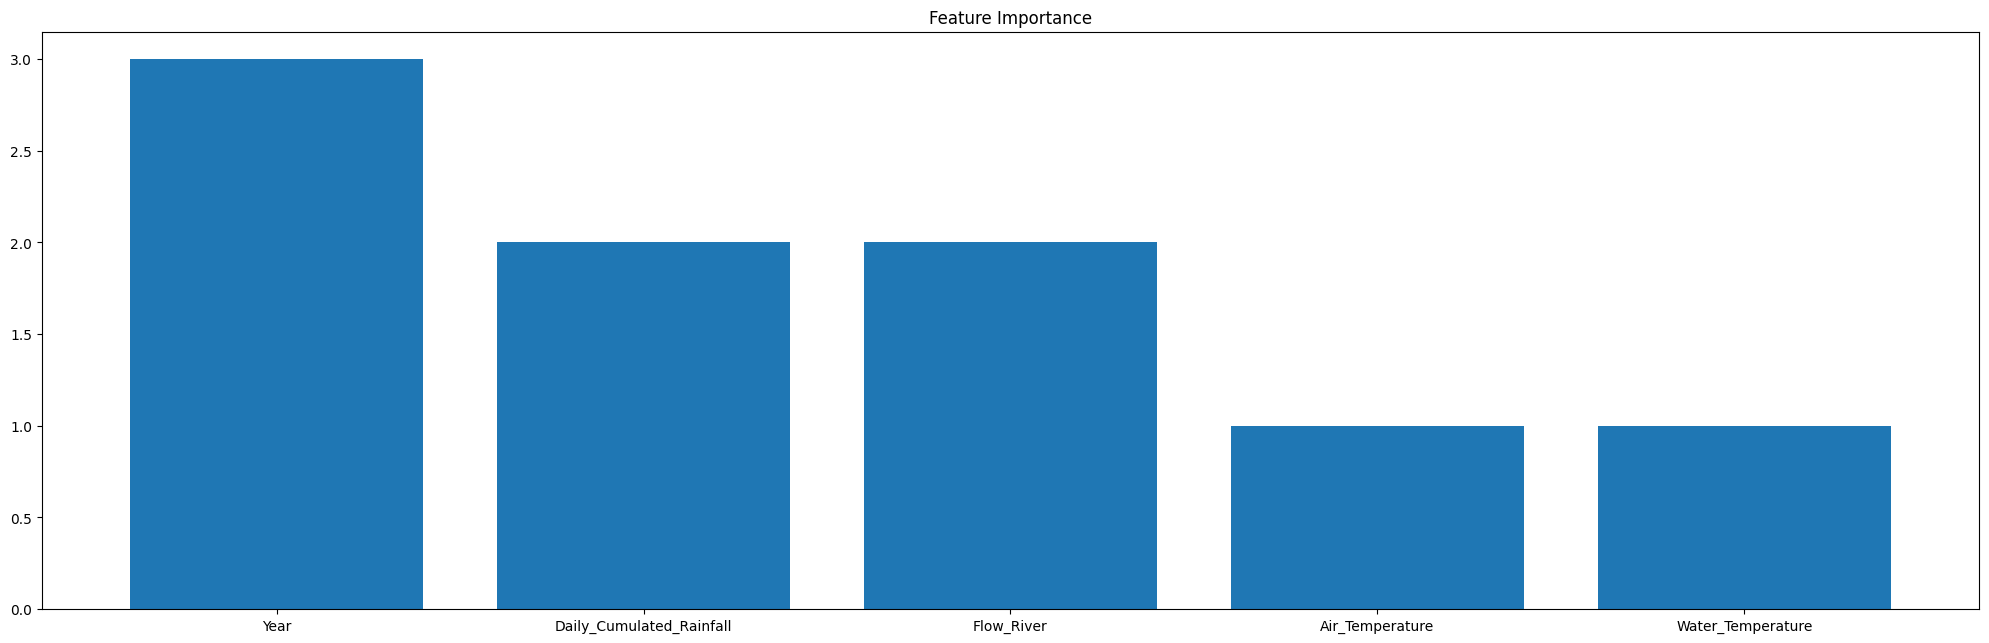

In [59]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance["feature"] = estimator.feature_name_
feature_importance["importance"] = estimator.feature_importances_

feature_importance = feature_importance.sort_values(
    by="importance", ascending=False
)

# plot the importance of each feature
plt.figure(figsize=(25, 7.5))
plt.bar(
    x=feature_importance["feature"],
    height=feature_importance["importance"],
)
plt.title("Feature Importance")
plt.show()

### Predictions

In [60]:
# Evaluate prediction and coverage level on testing set
y_med, y_pis_cqr = mapie_cqr.predict(X_test_fit, alpha=alpha)
y_lower = y_pis_cqr[:, 0, 0]
y_upper = y_pis_cqr[:, 1, 0]

coverage_cqr = regression_coverage_score(
    y_test_fit["Absorbance 254nm"], y_lower, y_upper
)

[LightGBM] [Warning] lambda_l1 is set=0.5831151410852462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5831151410852462
[LightGBM] [Warning] lambda_l2 is set=0.013664416492044728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013664416492044728
[LightGBM] [Warning] bagging_fraction is set=0.022658564852536835, subsample=0.5246088619028575 will be ignored. Current value: bagging_fraction=0.022658564852536835
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=107 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.0016630853004879736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0016630853004879736


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


In [61]:
print("Coverage:", coverage_cqr)

Coverage: 0.9696969696969697


#### Compute Measures

In [62]:
rmse = np.sqrt(
    mean_squared_error(y_test_fit["Absorbance 254nm"], y_med)
)
r2 = r2_score(y_test_fit["Absorbance 254nm"], y_med)

print(f"RMSE: {rmse:.4f}")
print(f"R\u00b2: {r2:.4f}")

RMSE: 3.0189
R²: 0.2777


### Plots

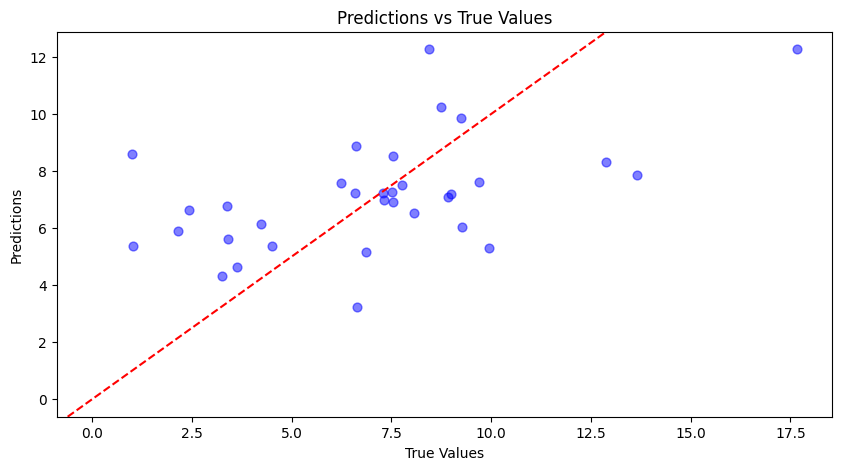

In [63]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(
    y_test_fit["Absorbance 254nm"], y_med, c="b", s=40, alpha=0.5
)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

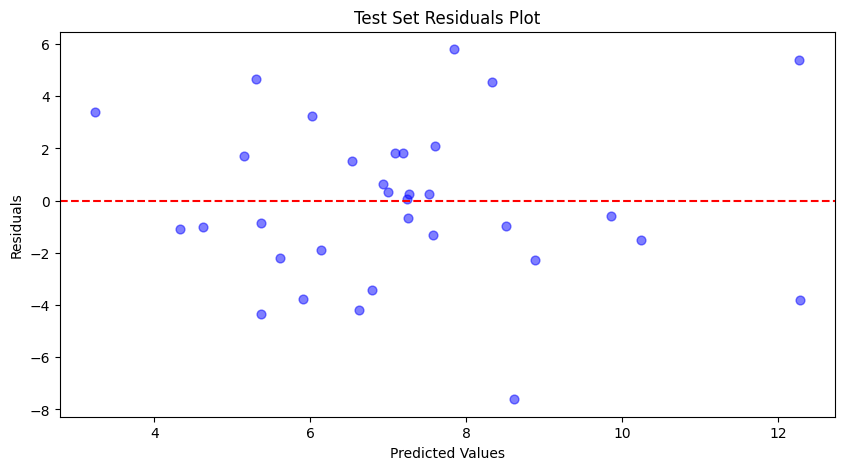

In [64]:
# plot the residuals
residuals = y_test_fit["Absorbance 254nm"] - y_med
plt.figure(figsize=(10, 5))
plt.scatter(y_med, residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

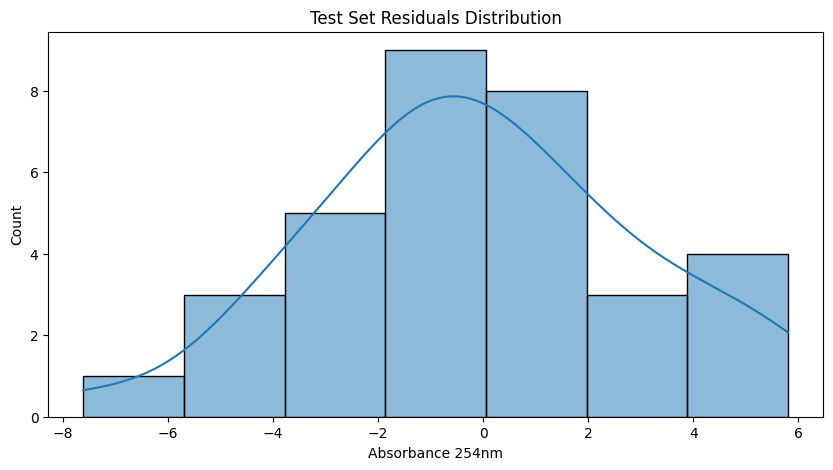

In [65]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

In [66]:
# get training residuals
train_predictions, _ = mapie_cqr.predict(X_train_fit, alpha=alpha)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

[LightGBM] [Warning] lambda_l1 is set=0.5831151410852462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5831151410852462
[LightGBM] [Warning] lambda_l2 is set=0.013664416492044728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013664416492044728
[LightGBM] [Warning] bagging_fraction is set=0.022658564852536835, subsample=0.5246088619028575 will be ignored. Current value: bagging_fraction=0.022658564852536835
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=107 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.0016630853004879736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0016630853004879736


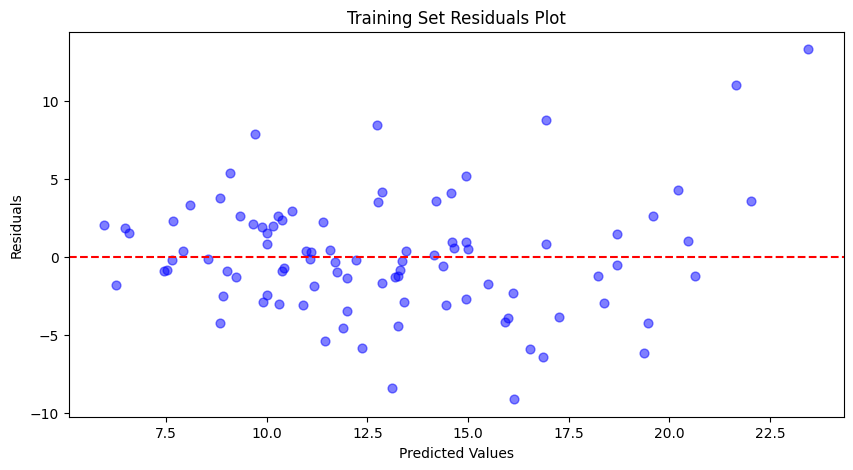

In [67]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

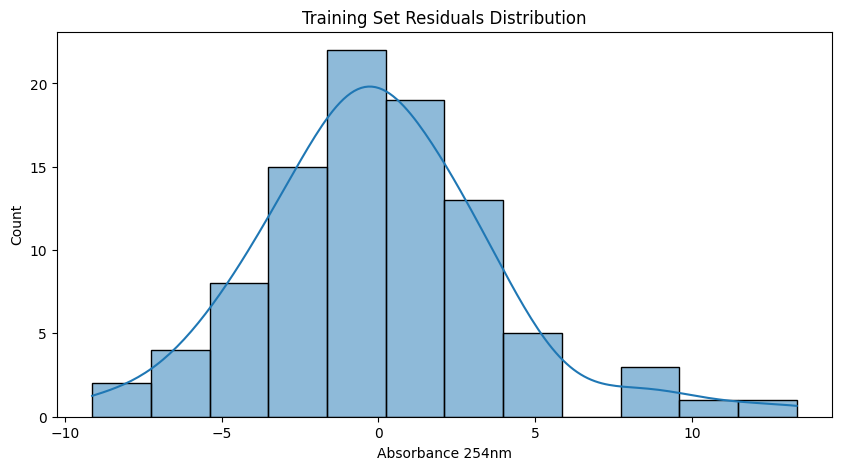

In [68]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

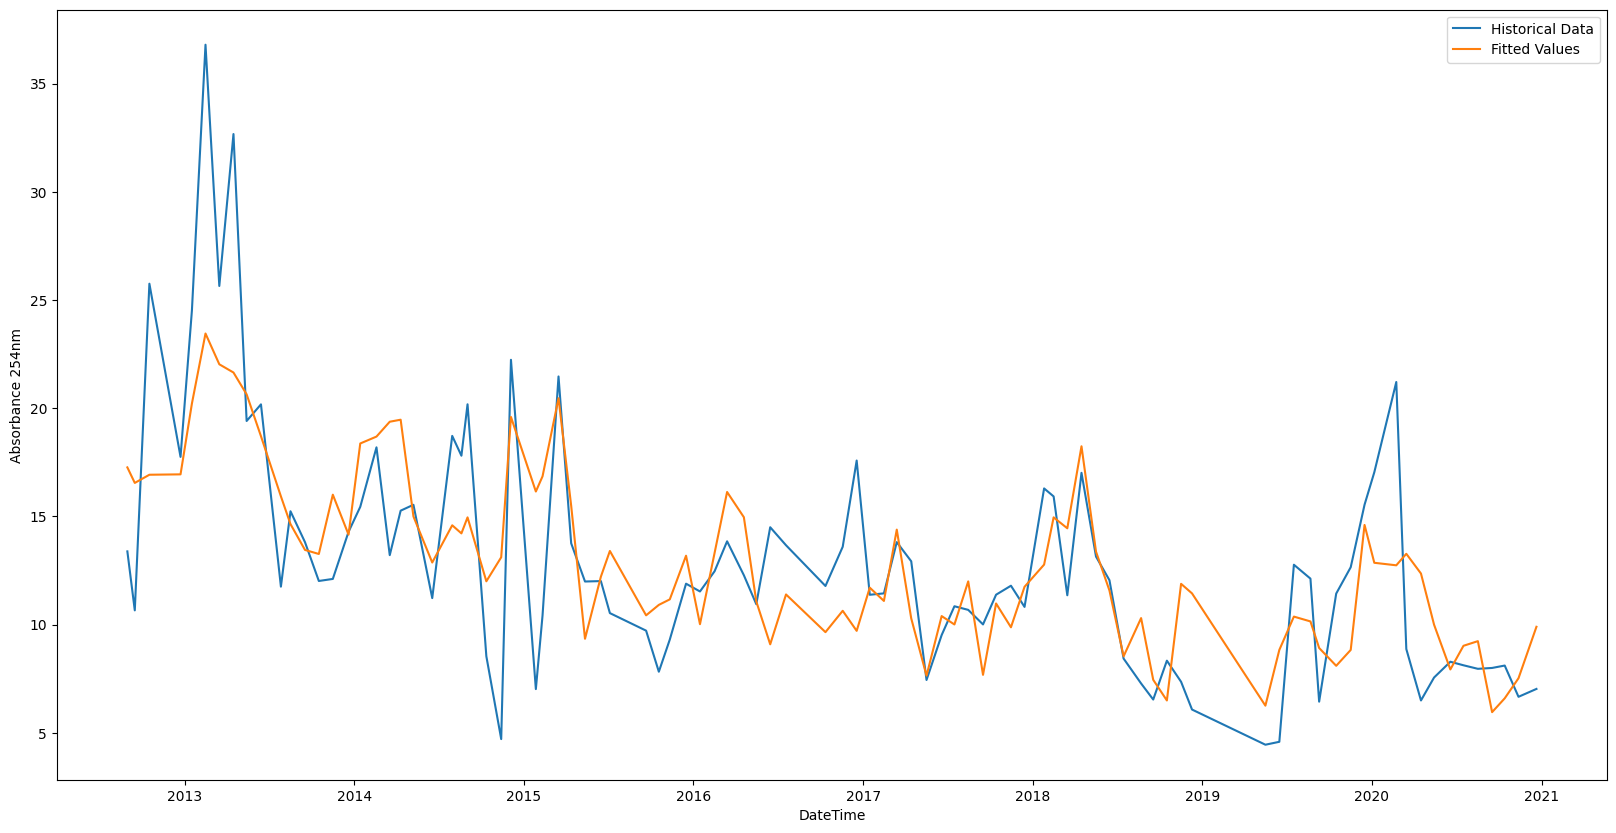

In [69]:
# plot the time series fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=y_train_fit["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=train_predictions,
    label="Fitted Values",
)

plt.show()

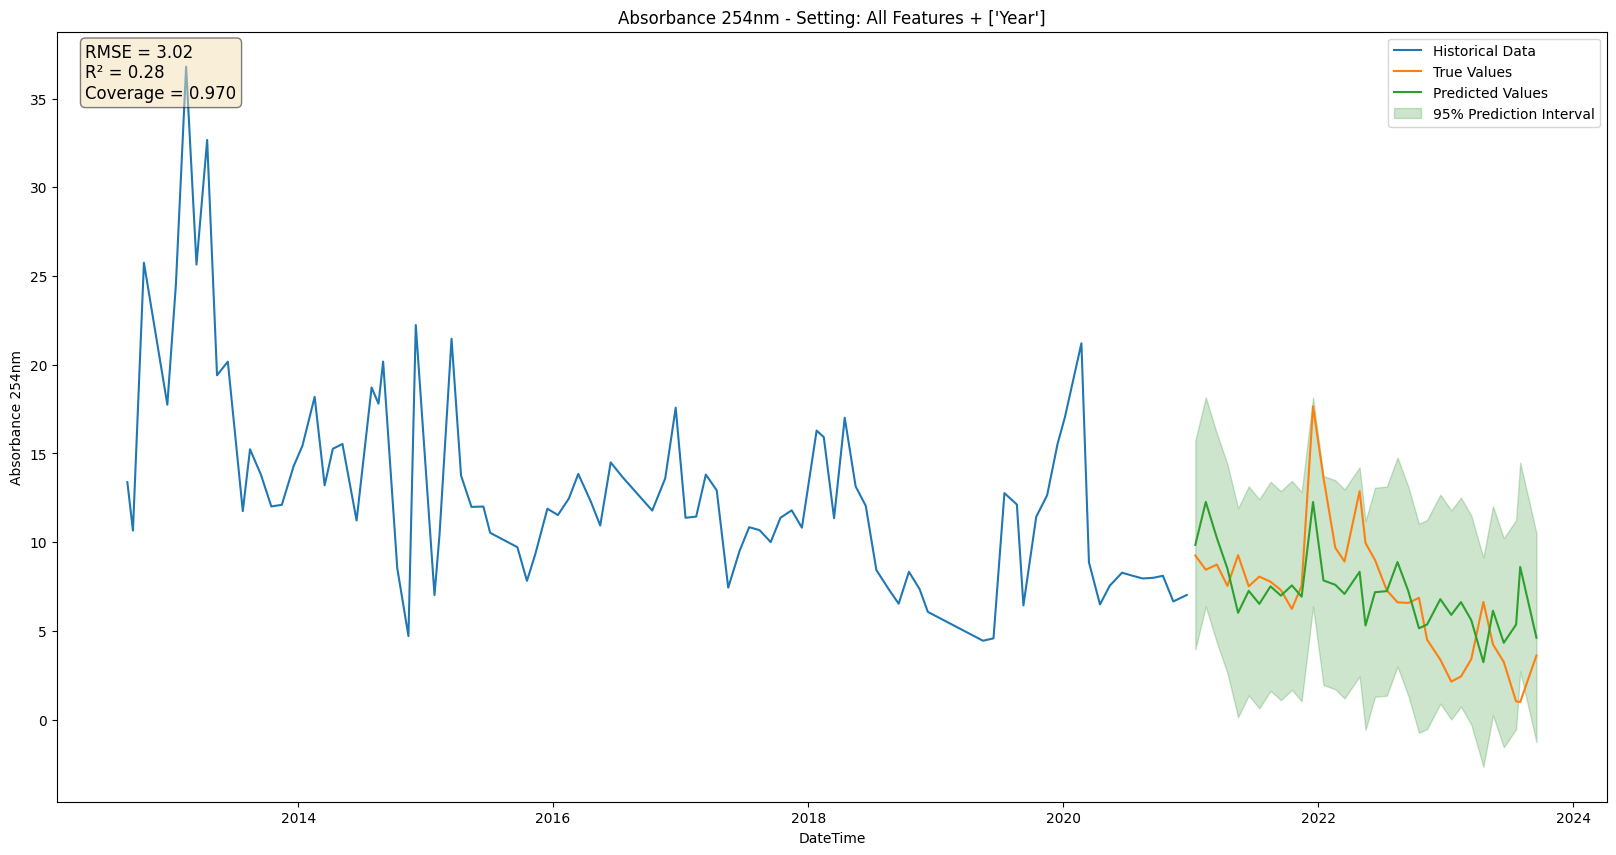

In [70]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=y_train_fit["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test_fit["DateTime"],
    y=y_test_fit["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test_fit["DateTime"], y=y_med, label="Predicted Values"
)
# plot std of predictions
plt.fill_between(
    y_test_fit["DateTime"],
    y_lower.flatten(),
    y2=y_upper.flatten(),
    alpha=0.2,
    label="95% Prediction Interval",
    color="g",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
        f"Coverage = {coverage_cqr:.3f}",
    )
)

plt.text(
    y_train_fit["DateTime"].iloc[0] - pd.Timedelta(days=120),
    35,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(
    f"Absorbance 254nm - Setting: All Features + {further_features}"
)

plt.legend()
plt.show()

Comment: prevede un trend crescente, probabilmente dato da qualche feature 

### Store Results

In [71]:
lgbm_pred = y_med
lgbm_lower_bound = y_lower
lgbm_upper_bound = y_upper
lgbm_rmse = rmse
lgbm_r2 = r2

# Neural Network

## Split Data

In [173]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Season", "Month"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [174]:
# split data such that 2022 and 2023 are test data
X_train = X[X["DateTime"] < "2021-01-01"]
X_test = X[X["DateTime"] >= "2021-01-01"]

y_train = y[y["DateTime"] < "2021-01-01"]
y_test = y[y["DateTime"] >= "2021-01-01"]

In [175]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train.copy()
y_test_fit = y_test.copy()

In [176]:
scaler = StandardScaler()
# scale the data and keep the column names
X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

X_train_fit = pd.DataFrame(
    X_train_fit, columns=X_train.columns.difference(["DateTime"])
)
X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_test.columns.difference(["DateTime"])
)

## Train the model

### Hyperparameter Tuning

In [125]:
def fit_and_validate_nn_model(
    X,
    y,
    train_index,
    val_index,
    params,
):
    X_tr, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]

    model = MLPRegressor(
        random_state=42,
        hidden_layer_sizes=tuple(params["layers"]),
        max_iter=1000,
    )

    param = params.copy()
    param.pop("layers")
    model.set_params(**param)

    # train model
    _ = model.fit(X_tr, y_tr)

    # obtain predictions
    y_val_pred = model.predict(X_val)

    # return metrics
    return mean_squared_error(y_val, y_val_pred, squared=False)

In [178]:
def objective(trial: optuna.trial.Trial) -> float:
    config = {
        "layers": [
            trial.suggest_int(f"n_units_{i}", 50, 100, step=5)
            for i in range(trial.suggest_int("n_layers", 2, 2))
        ],
        "activation": trial.suggest_categorical(
            "activation", ["identity", "logistic", "tanh", "relu"]
        ),
        "solver": trial.suggest_categorical("solver", ["sgd", "adam"]),
        "alpha": trial.suggest_float("alpha", 1e-5, 1),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", ["constant", "invscaling", "adaptive"]
        ),
        "power_t": trial.suggest_float("power_t", 0.1, 1),
        "beta_1": trial.suggest_float("beta_1", 0.1, 1),
        "beta_2": trial.suggest_float("beta_2", 0.1, 1),
        "epsilon": trial.suggest_float("epsilon", 1e-8, 1),
        "early_stopping": True,
    }

    n_splits = 5
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    cv_mae = [None] * n_splits
    for i, (train_index, test_index) in enumerate(
        cv.split(X_train_fit, y_train_fit["Absorbance 254nm"])
    ):
        cv_mae[i] = fit_and_validate_nn_model(
            X_train_fit,
            y_train_fit["Absorbance 254nm"],
            train_index,
            test_index,
            config,
        )

    # saving the individual fold holdout metrics
    # uncomment this line if you don't want this
    trial.set_user_attr("split_mae", cv_mae)

    return np.mean(cv_mae)

In [180]:
study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///NeuralNetwork.sqlite3",
    study_name="Hyperparameter Tuning - All Features"
    + " + "
    + str(further_features),
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-04-04 12:49:07,879] A new study created in RDB with name: Hyperparameter Tuning - All Features + ['Year']


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-04-04 12:49:09,345] Trial 0 finished with value: 4.509922353459385 and parameters: {'n_layers': 2, 'n_units_0': 75, 'n_units_1': 85, 'activation': 'identity', 'solver': 'adam', 'alpha': 0.3838868028262881, 'learning_rate': 'constant', 'power_t': 0.6344736717940379, 'beta_1': 0.6552506029307329, 'beta_2': 0.8068644525650908, 'epsilon': 0.46491293656648514}. Best is trial 0 with value: 4.509922353459385.
[I 2024-04-04 12:49:10,443] Trial 1 finished with value: 5.407371921255406 and parameters: {'n_layers': 2, 'n_units_0': 60, 'n_units_1': 70, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.23574577154029133, 'learning_rate': 'constant', 'power_t': 0.8916530255929773, 'beta_1': 0.9562786579034491, 'beta_2': 0.7395635857369879, 'epsilon': 0.702203730999251}. Best is trial 0 with value: 4.509922353459385.
[I 2024-04-04 12:49:11,324] Trial 2 finished with value: 4.7604490827821735 and parameters: {'n_layers': 2, 'n_units_0': 95, 'n_units_1': 65, 'activation': 'relu', 'solver': 'ad

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-ch

[I 2024-04-04 12:49:16,350] Trial 7 finished with value: 9.498825968432485 and parameters: {'n_layers': 2, 'n_units_0': 50, 'n_units_1': 65, 'activation': 'identity', 'solver': 'sgd', 'alpha': 0.7144936454470082, 'learning_rate': 'invscaling', 'power_t': 0.6385139490167795, 'beta_1': 0.931534541170162, 'beta_2': 0.9381757145572128, 'epsilon': 0.03563014156347994}. Best is trial 0 with value: 4.509922353459385.
[I 2024-04-04 12:49:16,536] Trial 8 finished with value: 4.686540325906714 and parameters: {'n_layers': 2, 'n_units_0': 85, 'n_units_1': 55, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.5125874872252019, 'learning_rate': 'constant', 'power_t': 0.6740324575915748, 'beta_1': 0.268257429947745, 'beta_2': 0.8859873905462201, 'epsilon': 0.5404196929294931}. Best is trial 0 with value: 4.509922353459385.
[I 2024-04-04 12:49:18,492] Trial 9 finished with value: 5.463736566499465 and parameters: {'n_layers': 2, 'n_units_0': 70, 'n_units_1': 60, 'activation': 'logistic', 'solver': 'a

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2024-04-04 12:49:25,442] Trial 19 finished with value: 5.457725857106656 and parameters: {'n_layers': 2, 'n_units_0': 70, 'n_units_1': 90, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.06440117769666942, 'learning_rate': 'adaptive', 'power_t': 0.46635203268140213, 'beta_1': 0.7666808033881477, 'beta_2': 0.36643534805073175, 'epsilon': 0.3516714183005715}. Best is trial 10 with value: 4.374059777612203.
[I 2024-04-04 12:49:26,608] Trial 20 finished with value: 4.360080400765776 and parameters: {'n_layers': 2, 'n_units_0': 55, 'n_units_1': 100, 'activation': 'identity', 'solver': 'adam', 'alpha': 0.6100883036270238, 'learning_rate': 'adaptive', 'power_t': 0.18501726987585468, 'beta_1': 0.10289841921285786, 'beta_2': 0.13945310118858234, 'epsilon': 0.9956288967993298}. Best is trial 20 with value: 4.360080400765776.
[I 2024-04-04 12:49:27,622] Trial 21 finished with value: 4.366227416134448 and parameters: {'n_layers': 2, 'n_units_0': 55, 'n_units_1': 100, 'activation': 'ident

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-ch

[I 2024-04-04 12:49:44,367] Trial 43 finished with value: 8.148496443547433 and parameters: {'n_layers': 2, 'n_units_0': 100, 'n_units_1': 60, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.4860224995231175, 'learning_rate': 'invscaling', 'power_t': 0.5621252547500543, 'beta_1': 0.5971265917914464, 'beta_2': 0.6992228873384464, 'epsilon': 0.06938220697723145}. Best is trial 35 with value: 4.290106837743265.
[I 2024-04-04 12:49:45,918] Trial 44 finished with value: 4.455462546503686 and parameters: {'n_layers': 2, 'n_units_0': 70, 'n_units_1': 65, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.4183422832034106, 'learning_rate': 'constant', 'power_t': 0.18443360989355082, 'beta_1': 0.6987998033845729, 'beta_2': 0.8084176815913965, 'epsilon': 0.13091551981902833}. Best is trial 35 with value: 4.290106837743265.
[I 2024-04-04 12:49:46,502] Trial 45 finished with value: 4.818847922869421 and parameters: {'n_layers': 2, 'n_units_0': 90, 'n_units_1': 70, 'activation': 'relu', 'solver':

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2024-04-04 12:49:50,475] Trial 49 finished with value: 12.676658424793475 and parameters: {'n_layers': 2, 'n_units_0': 95, 'n_units_1': 65, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.3497662932922829, 'learning_rate': 'invscaling', 'power_t': 0.8242921943035121, 'beta_1': 0.89989253496167, 'beta_2': 0.6761106023757327, 'epsilon': 0.023022277343282094}. Best is trial 46 with value: 4.206948312826106.
[I 2024-04-04 12:49:51,060] Trial 50 finished with value: 4.327595392937789 and parameters: {'n_layers': 2, 'n_units_0': 75, 'n_units_1': 75, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.19655072466900428, 'learning_rate': 'adaptive', 'power_t': 0.7490616995119117, 'beta_1': 0.7742365063205758, 'beta_2': 0.8574824073617399, 'epsilon': 0.14534688283706235}. Best is trial 46 with value: 4.206948312826106.
[I 2024-04-04 12:49:51,446] Trial 51 finished with value: 4.327581004648055 and parameters: {'n_layers': 2, 'n_units_0': 75, 'n_units_1': 75, 'activation': 'relu', 'solver': '

In [181]:
study.best_params

{'n_layers': 2,
 'n_units_0': 75,
 'n_units_1': 80,
 'activation': 'relu',
 'solver': 'sgd',
 'alpha': 0.04020925262297215,
 'learning_rate': 'adaptive',
 'power_t': 0.8924480313349424,
 'beta_1': 0.8458425075209282,
 'beta_2': 0.6585605624473299,
 'epsilon': 0.43501579939349455}

In [189]:
params = study.best_params.copy()
params["n_units_1"] = 80
# params['learning_rate'] = 'invscaling'
params["activation"] = "identity"

hidden_layer_sizes = [
    params[f"n_units_{i}"] for i in range(params["n_layers"])
]

for i in range(params["n_layers"]):
    params.pop(f"n_units_{i}")

params.pop("n_layers")

2

#### Train model with mapie

In [190]:
alpha = 0.1
estimator = MLPRegressor(
    random_state=42,
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter=1000,
    early_stopping=True,
    **params
)

estimator.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

MLPRegressor(activation='identity', alpha=0.04020925262297215,
             beta_1=0.8458425075209282, beta_2=0.6585605624473299,
             early_stopping=True, epsilon=0.43501579939349455,
             hidden_layer_sizes=[75, 80], learning_rate='adaptive',
             max_iter=1000, power_t=0.8924480313349424, random_state=42,
             solver='sgd')

In [191]:
# Calibrate uncertainties on calibration set
mapie_cqr = MapieRegressor(estimator, cv="prefit", random_state=42)
mapie_cqr.fit(X_train_fit, y_train_fit["Absorbance 254nm"])

MapieRegressor(cv='prefit',
               estimator=MLPRegressor(activation='identity',
                                      alpha=0.04020925262297215,
                                      beta_1=0.8458425075209282,
                                      beta_2=0.6585605624473299,
                                      early_stopping=True,
                                      epsilon=0.43501579939349455,
                                      hidden_layer_sizes=[75, 80],
                                      learning_rate='adaptive', max_iter=1000,
                                      power_t=0.8924480313349424,
                                      random_state=42, solver='sgd'),
               method='base', random_state=42)

## Prediction

In [192]:
# Evaluate prediction and coverage level on testing set
y_med, y_pis_cqr = mapie_cqr.predict(X_test_fit, alpha=alpha)
y_lower = y_pis_cqr[:, 0, 0]
y_upper = y_pis_cqr[:, 1, 0]

coverage_cqr = regression_coverage_score(
    y_test_fit["Absorbance 254nm"], y_lower, y_upper
)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.11/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


In [193]:
print("Coverage:", coverage_cqr)

Coverage: 1.0


#### Compute Measures

In [194]:
rmse = np.sqrt(
    mean_squared_error(y_test_fit["Absorbance 254nm"], y_med)
)
r2 = r2_score(y_test_fit["Absorbance 254nm"], y_med)

print(f"RMSE: {rmse:.4f}")
print(f"R\u00b2: {r2:.4f}")

RMSE: 2.9011
R²: 0.3330


## Plots

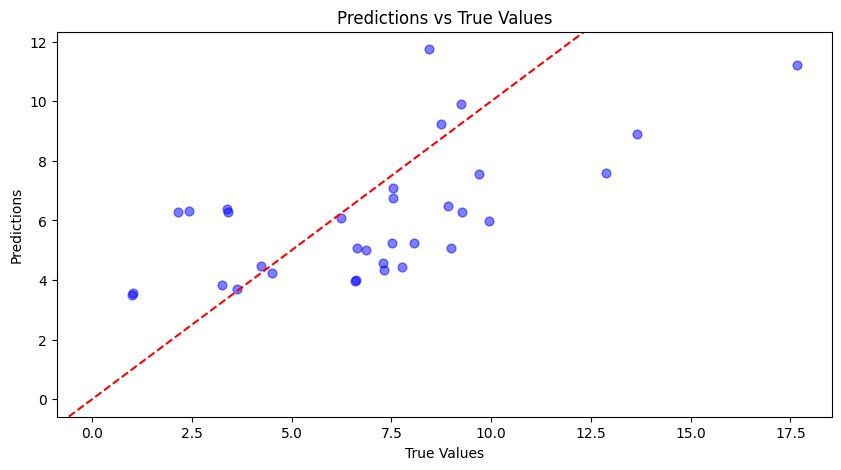

In [195]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(
    y_test_fit["Absorbance 254nm"], y_med, c="b", s=40, alpha=0.5
)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

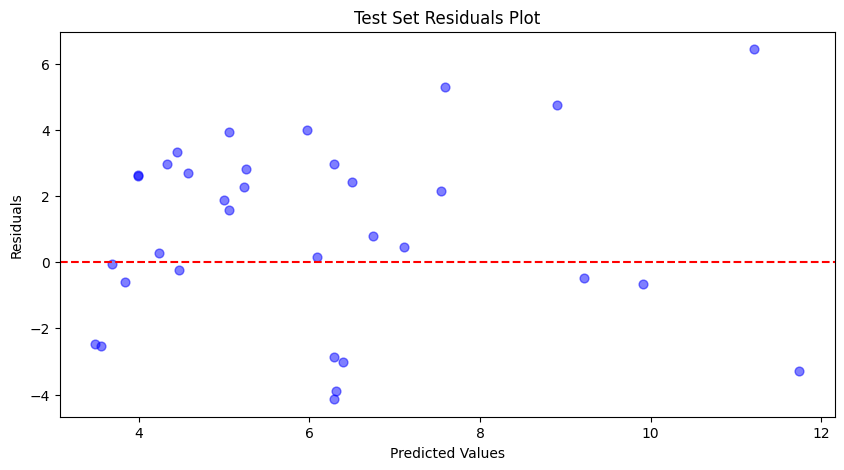

In [196]:
# plot the residuals
residuals = y_test_fit["Absorbance 254nm"] - y_med
plt.figure(figsize=(10, 5))
plt.scatter(y_med, residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

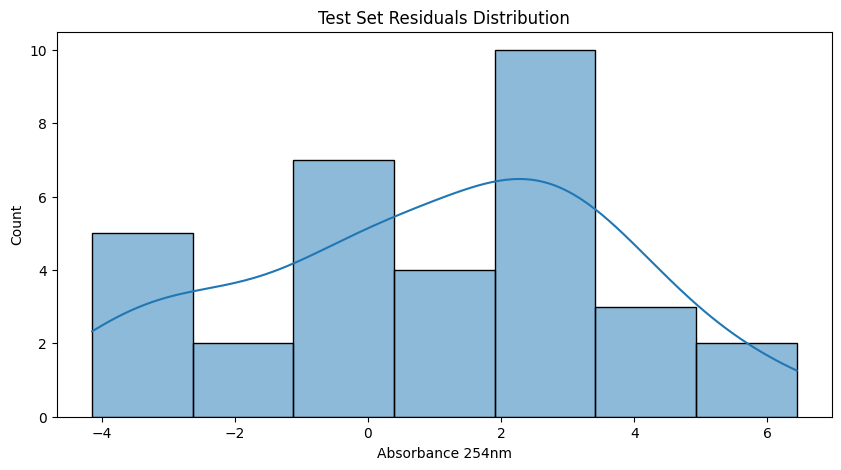

In [197]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

In [198]:
# get training residuals
train_predictions, _ = mapie_cqr.predict(X_train_fit, alpha=alpha)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

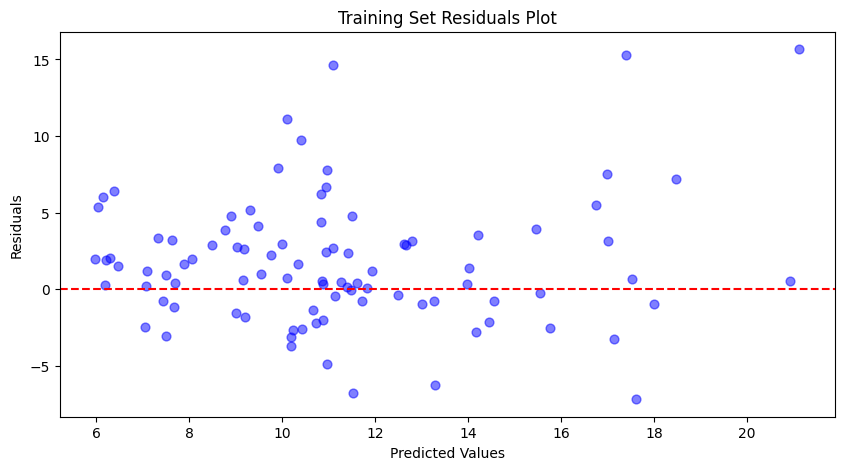

In [199]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(
    train_predictions.flatten(), train_residuals, c="b", s=40, alpha=0.5
)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

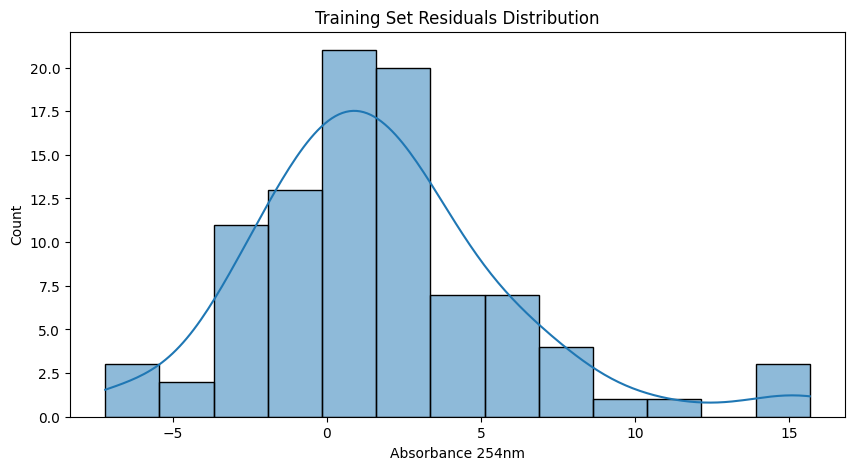

In [200]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

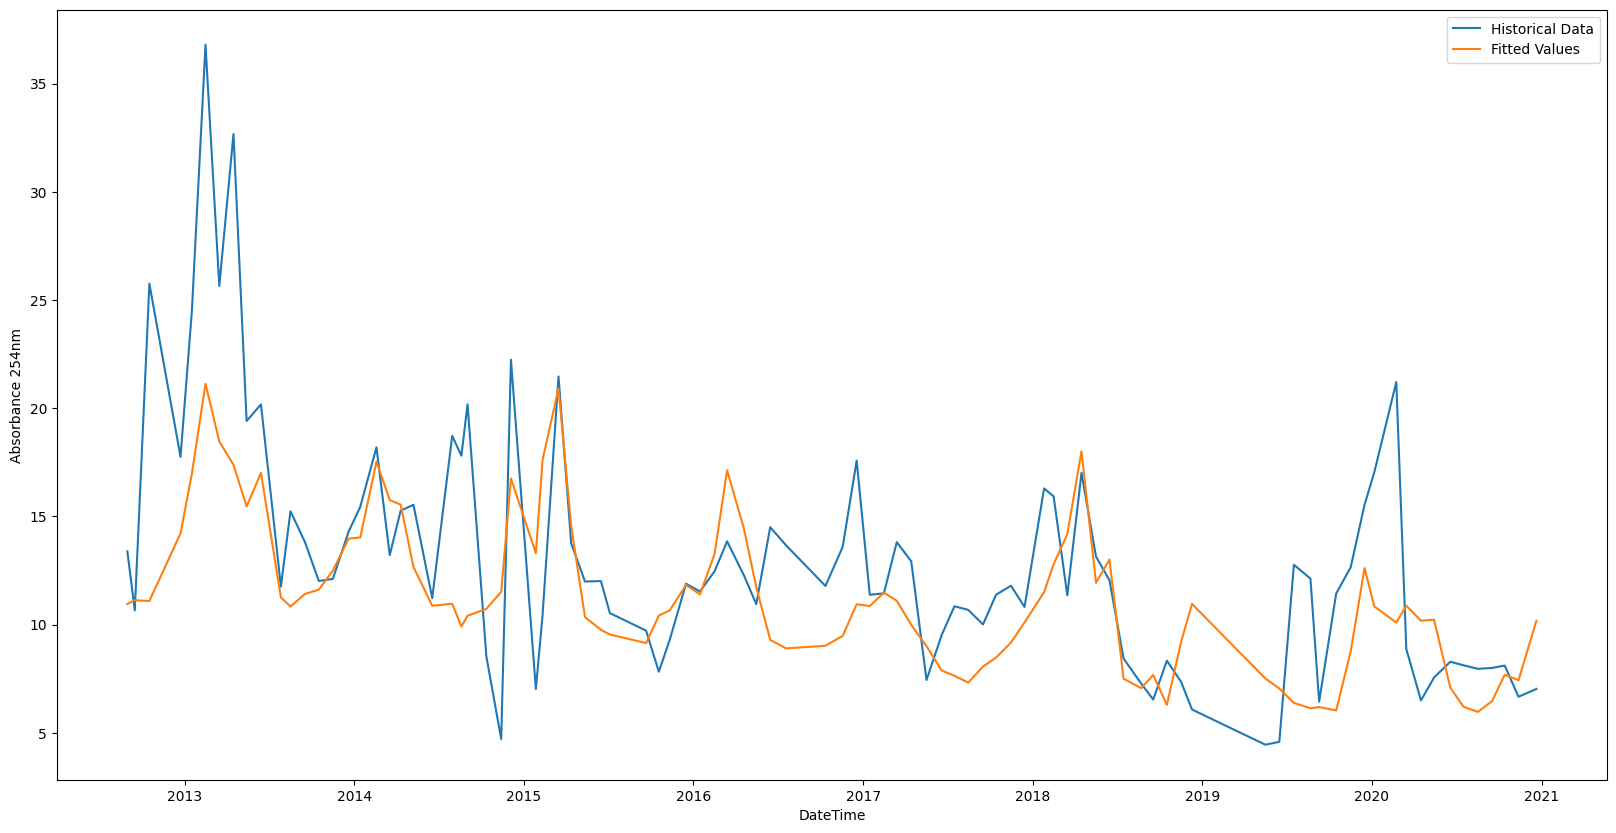

In [201]:
# plot the time series fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=y_train_fit["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=train_predictions,
    label="Fitted Values",
)

plt.show()

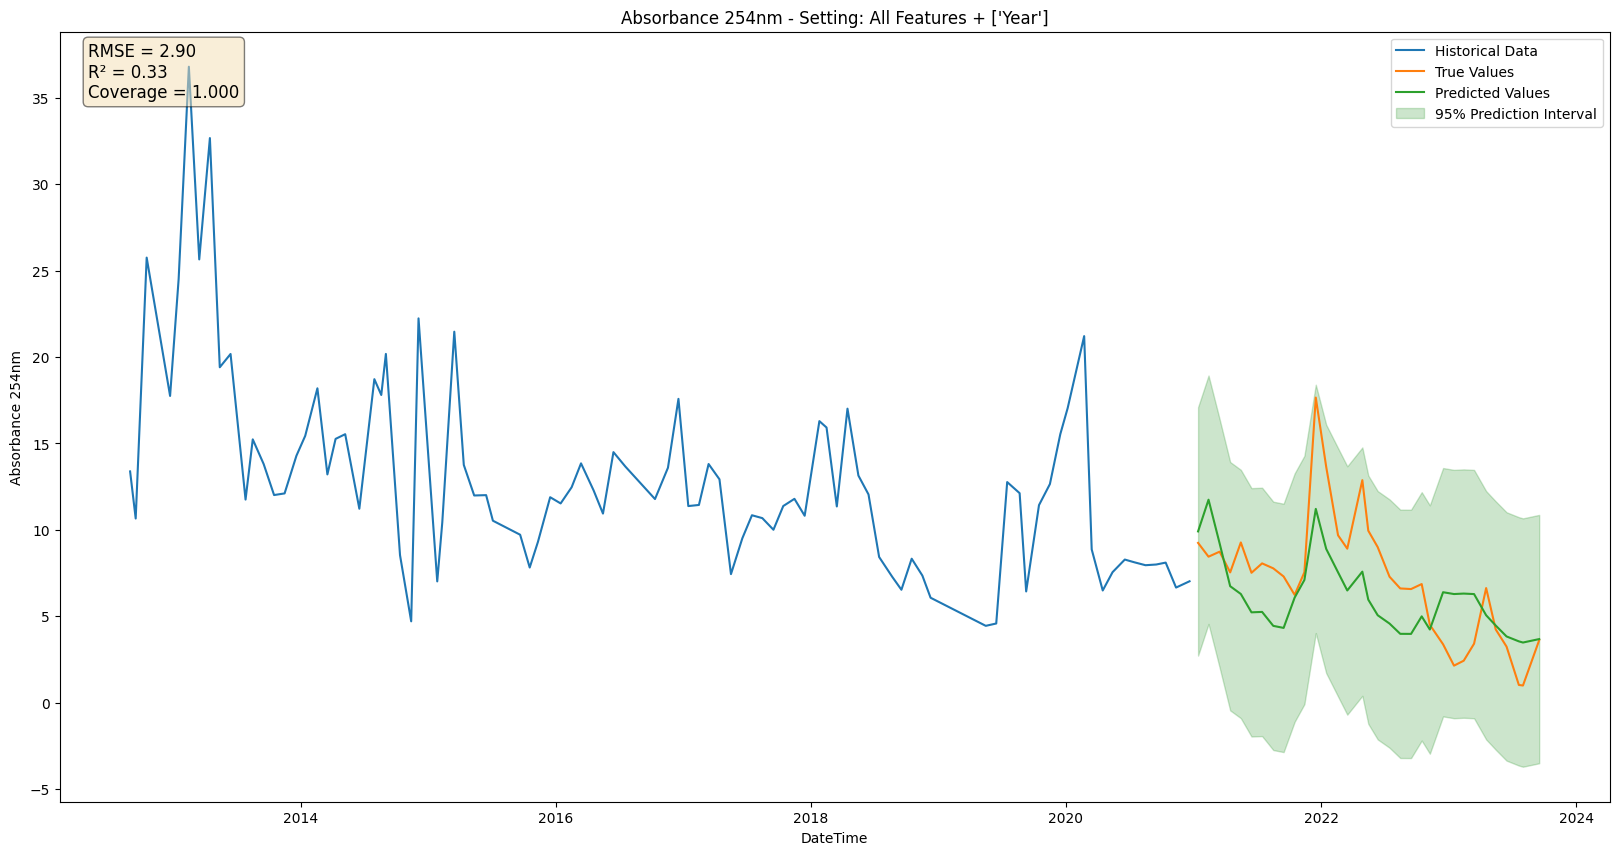

In [202]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train_fit["DateTime"],
    y=y_train_fit["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test_fit["DateTime"],
    y=y_test_fit["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test_fit["DateTime"], y=y_med, label="Predicted Values"
)
# plot std of predictions
plt.fill_between(
    y_test_fit["DateTime"],
    y_lower.flatten(),
    y2=y_upper.flatten(),
    alpha=0.2,
    label="95% Prediction Interval",
    color="g",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
        f"Coverage = {coverage_cqr:.3f}",
    )
)

plt.text(
    y_train_fit["DateTime"].iloc[0] - pd.Timedelta(days=120),
    35,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(
    f"Absorbance 254nm - Setting: All Features + {further_features}"
)

plt.legend()
plt.show()

## Store Results

In [203]:
nn_pred = y_med
nn_lower_bound = y_lower
nn_upper_bound = y_upper
nn_rmse = rmse
nn_r2 = r2

# Final Plot

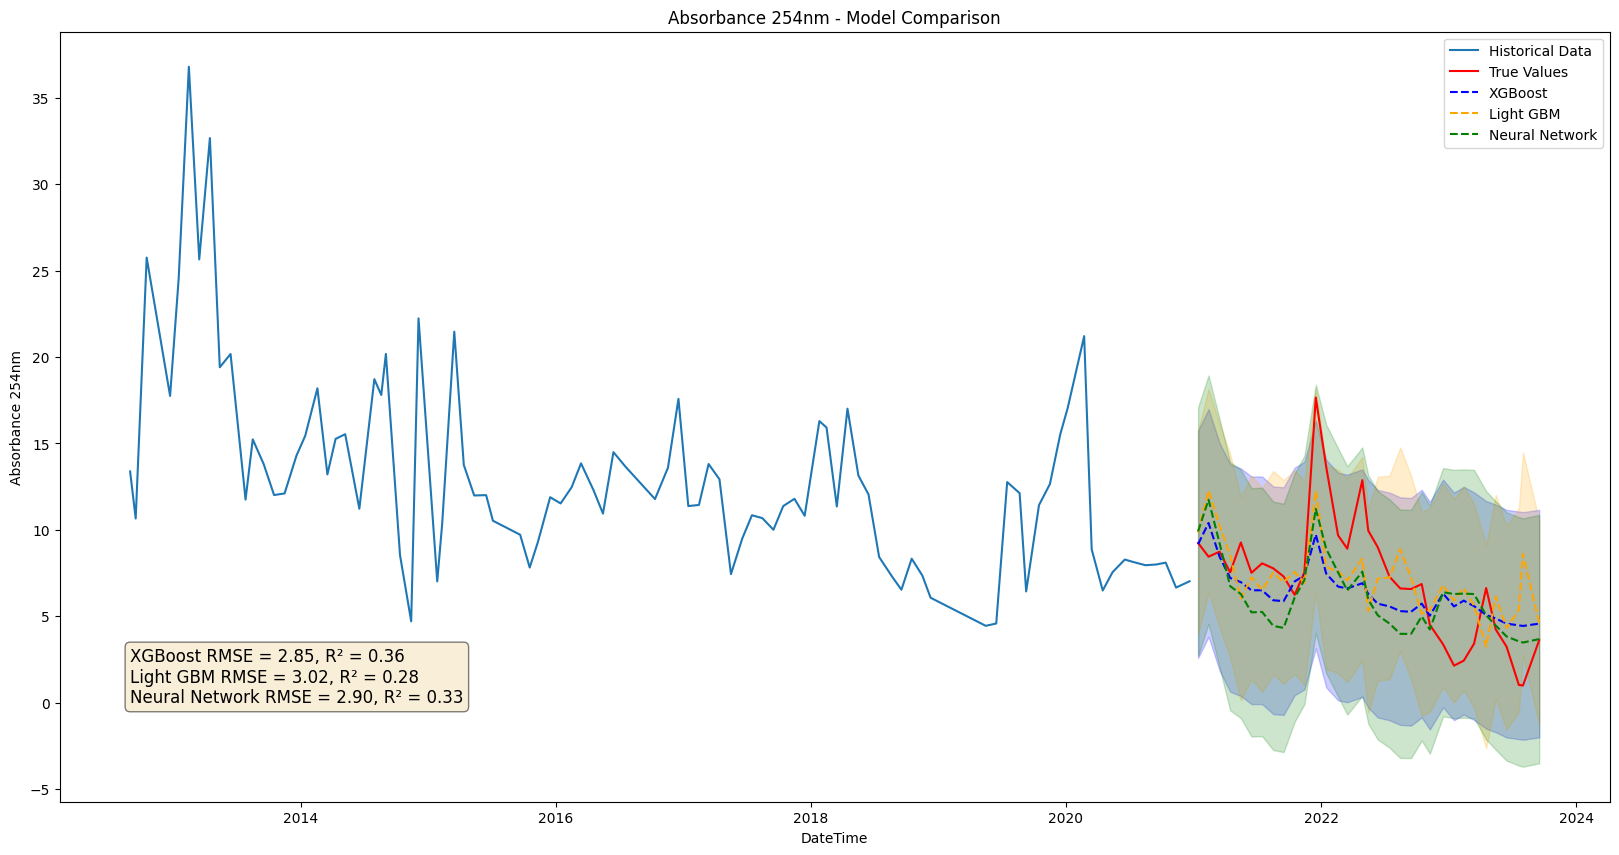

In [204]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
    color="red",
)

# Linear Regression
sns.lineplot(
    x=y_test["DateTime"],
    y=boost_pred,
    label="XGBoost",
    linestyle="--",
    color="blue",
)
plt.fill_between(
    y_test["DateTime"],
    boost_lower_bound,
    boost_upper_bound,
    alpha=0.2,
    color="blue",
)

# Random Forest
sns.lineplot(
    x=y_test["DateTime"],
    y=lgbm_pred,
    label="Light GBM",
    linestyle="--",
    color="orange",
)
plt.fill_between(
    y_test["DateTime"],
    lgbm_lower_bound,
    lgbm_upper_bound,
    alpha=0.2,
    color="orange",
)

# Neural Network
sns.lineplot(
    x=y_test["DateTime"],
    y=nn_pred,
    label="Neural Network",
    linestyle="--",
    color="green",
)
plt.fill_between(
    y_test["DateTime"],
    nn_lower_bound,
    nn_upper_bound,
    alpha=0.2,
    color="green",
)

plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"XGBoost RMSE = {boost_rmse:.2f}, R\u00b2 = {boost_r2:.2f}",
        f"Light GBM RMSE = {lgbm_rmse:.2f}, R\u00b2 = {lgbm_r2:.2f}",
        f"Neural Network RMSE = {nn_rmse:.2f}, R\u00b2 = {nn_r2:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0],
    0,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Model Comparison")

plt.legend()
plt.show()

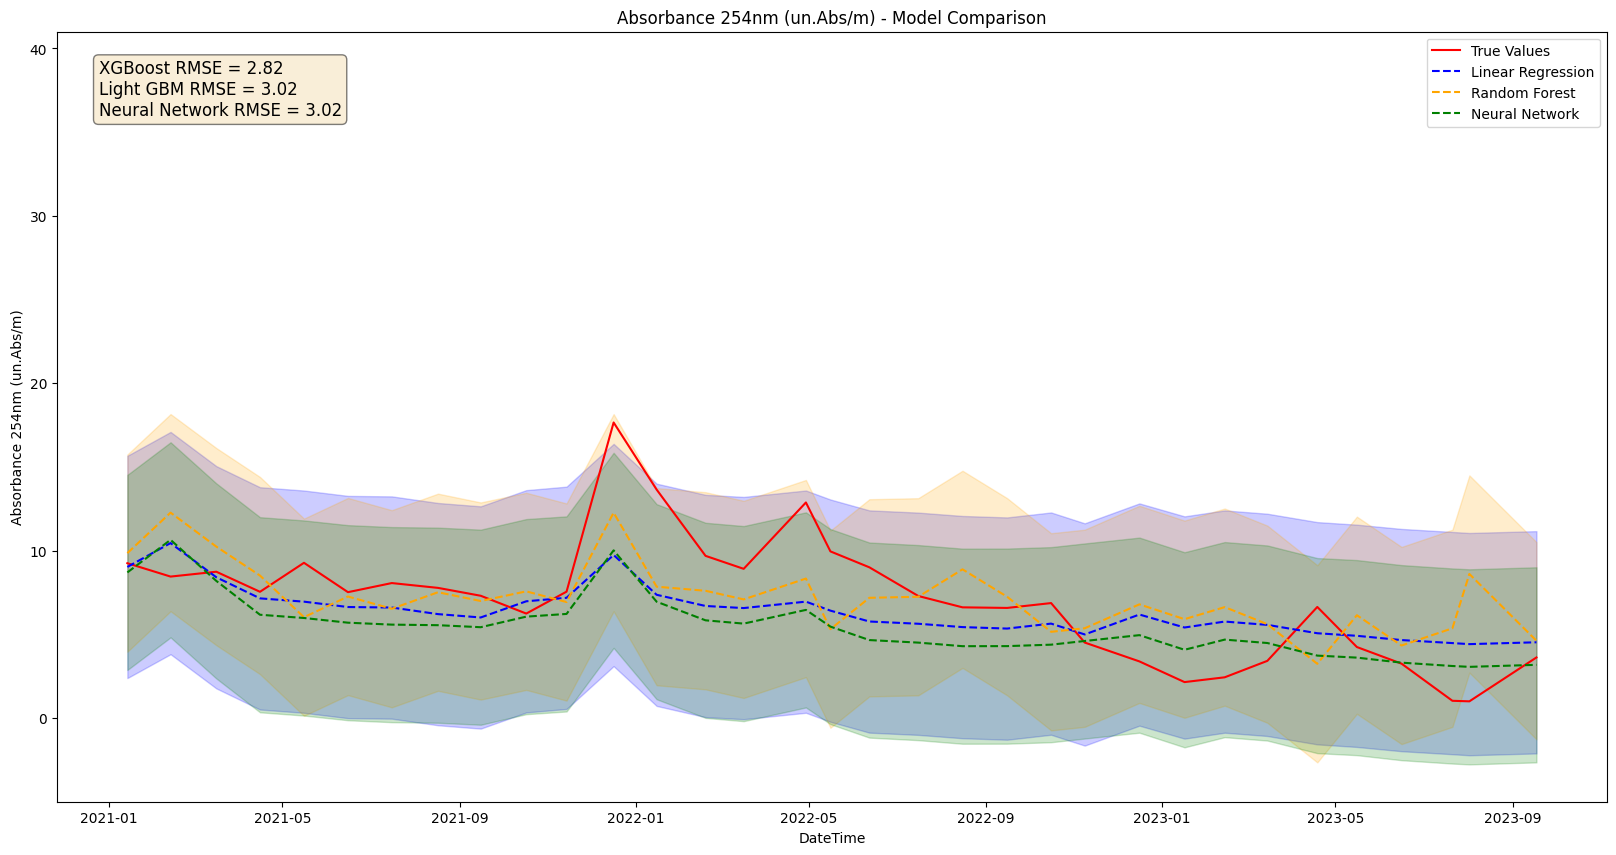

In [132]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
# sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
    color="red",
)

# Linear Regression
sns.lineplot(
    x=y_test["DateTime"],
    y=boost_pred,
    label="Linear Regression",
    linestyle="--",
    color="blue",
)
plt.fill_between(
    y_test["DateTime"],
    boost_lower_bound,
    boost_upper_bound,
    alpha=0.2,
    color="blue",
)

# Random Forest
sns.lineplot(
    x=y_test["DateTime"],
    y=lgbm_pred,
    label="Random Forest",
    linestyle="--",
    color="orange",
)
plt.fill_between(
    y_test["DateTime"],
    lgbm_lower_bound,
    lgbm_upper_bound,
    alpha=0.2,
    color="orange",
)

# Neural Network
sns.lineplot(
    x=y_test["DateTime"],
    y=nn_pred,
    label="Neural Network",
    linestyle="--",
    color="green",
)
plt.fill_between(
    y_test["DateTime"],
    nn_lower_bound,
    nn_upper_bound,
    alpha=0.2,
    color="green",
)

plt.ylim(-5, 41)

plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm (un.Abs/m)")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"XGBoost RMSE = {boost_rmse:.2f}",
        f"Light GBM RMSE = {lgbm_rmse:.2f}",
        f"Neural Network RMSE = {nn_rmse:.2f}",
    )
)

plt.text(
    y_test["DateTime"].iloc[0] - pd.Timedelta(days=20),
    36,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm (un.Abs/m) - Model Comparison")

plt.legend()
plt.show()